# Settings

In [7]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [8]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [9]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, cluster, glmgampoi,
               EnsDb.Hsapiens.v86, 
               logr, parallel, future,
               fpc,
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

In [10]:
# Load genome
#suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
#genome(annotations) <- 'hg38'
#seqlevelsStyle(annotations) <- 'UCSC'
# Save table
# writeRDS(annotations, "/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")

# Load table
annotations = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

# Seq info downloaded from: https://github.com/broadinstitute/ichorCNA/issues/84
seq.info = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/seqinfo_hg38_ucsc.rds")

In [11]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

# set Future
plan("multicore", workers = 6)
# set RAM treshold
## 1000 = 1gb
RAM.tresh = 10000 * 1024^2
options(future.globals.maxSize = RAM.tresh)

In [12]:
# Set directories
base.dir = "/nfs/lab/projects/mega_heart/"
assets.dir = "/nfs/lab/projects/mega_heart/Assets/"

cellranger.links.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/cellranger.symlinks/"

step1.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/"

In [13]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers_4.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = c("Muscular", "Vascular", "Neuro", "Stromal", "Immune", "Erythroid"))
cell.markers$CellType = factor(cell.markers$CellType,
                        levels = c("CardioMyocyte", "a-CM", "v-CM", "SM", "Endothelial", "Arterial-Endo", "Venous-Endo", "Capillary-Endo", "Endocardial", "Epicardial", "Lymph-Endo", "Pericyte", "Neuronal", "Fibroblast", "a-Fibroblast", "Adipocyte", "Macrophage", "DC", "T", "T-CD4", "T-CD8", "NK", "NK-16", "NK-56", "B", "Plasma", "Mast", "Erythroid"))

cell.compartment = cell.markers[,-3]

In [8]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".4_FinalMap.log", sep="")

In [9]:
log_open(log.file)

[1] "/nfs/lab/projects/mega_heart/log/2024-07-18.4_FinalMap.log"

# Load seurat

In [10]:
adata = readRDS(paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds", sep = ""))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



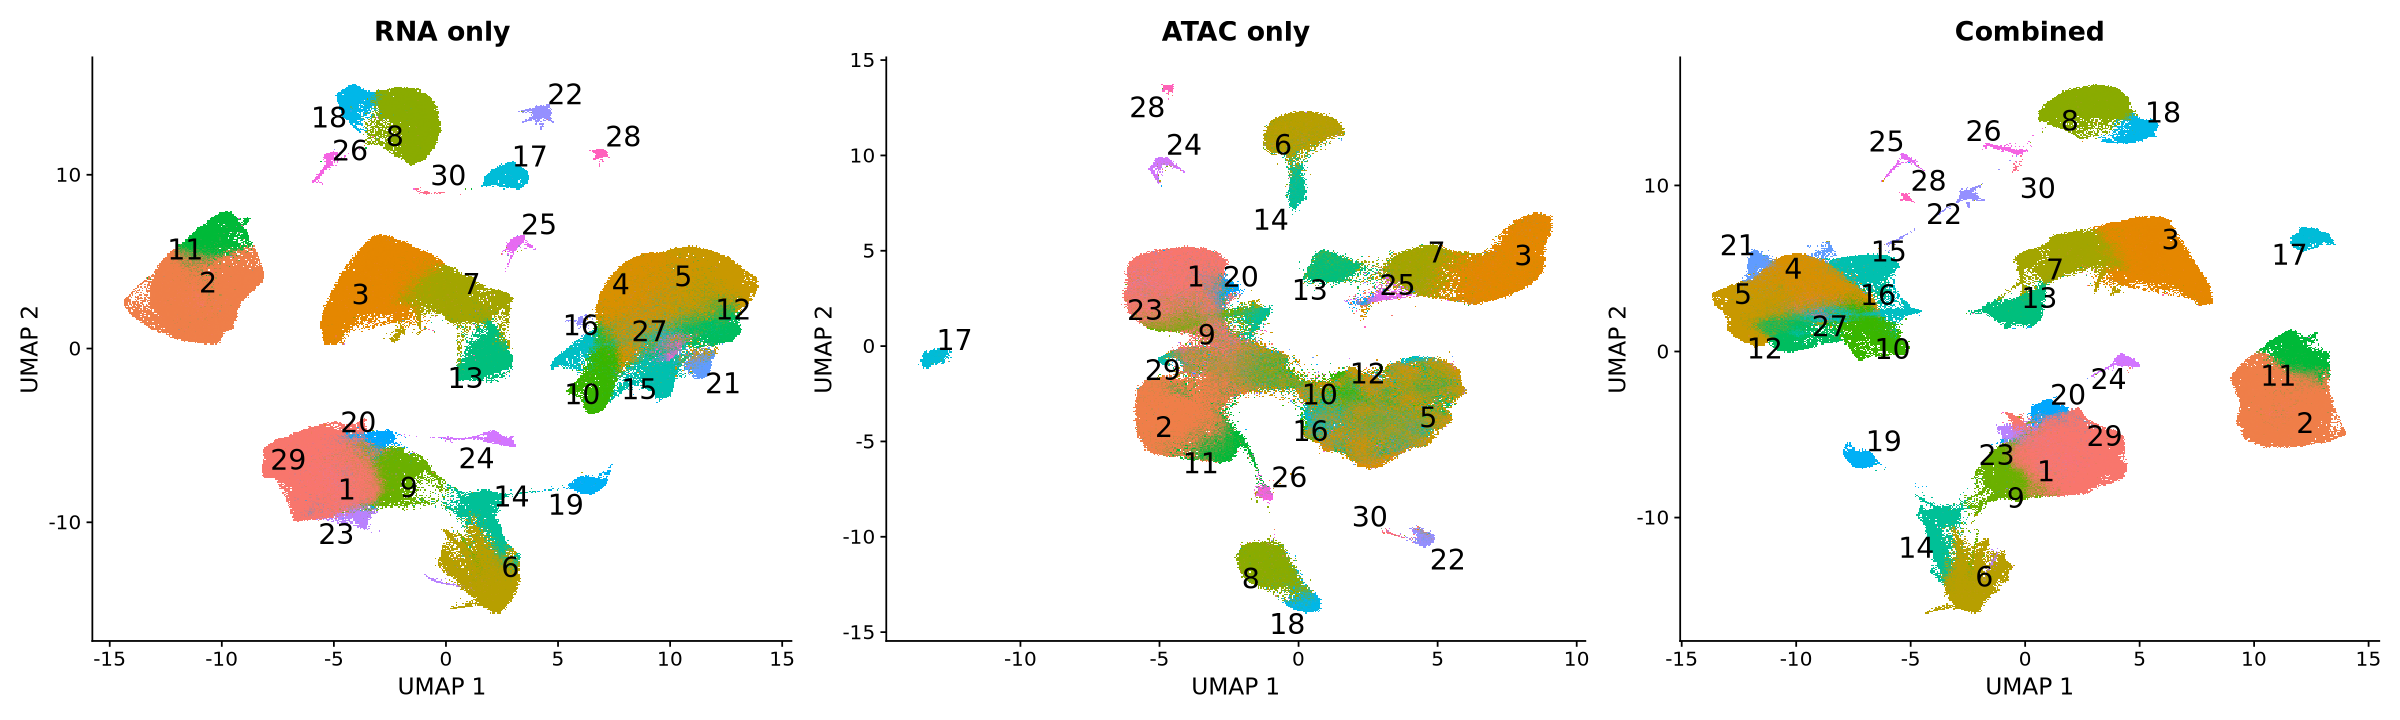

In [11]:
options(repr.plot.width=20, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



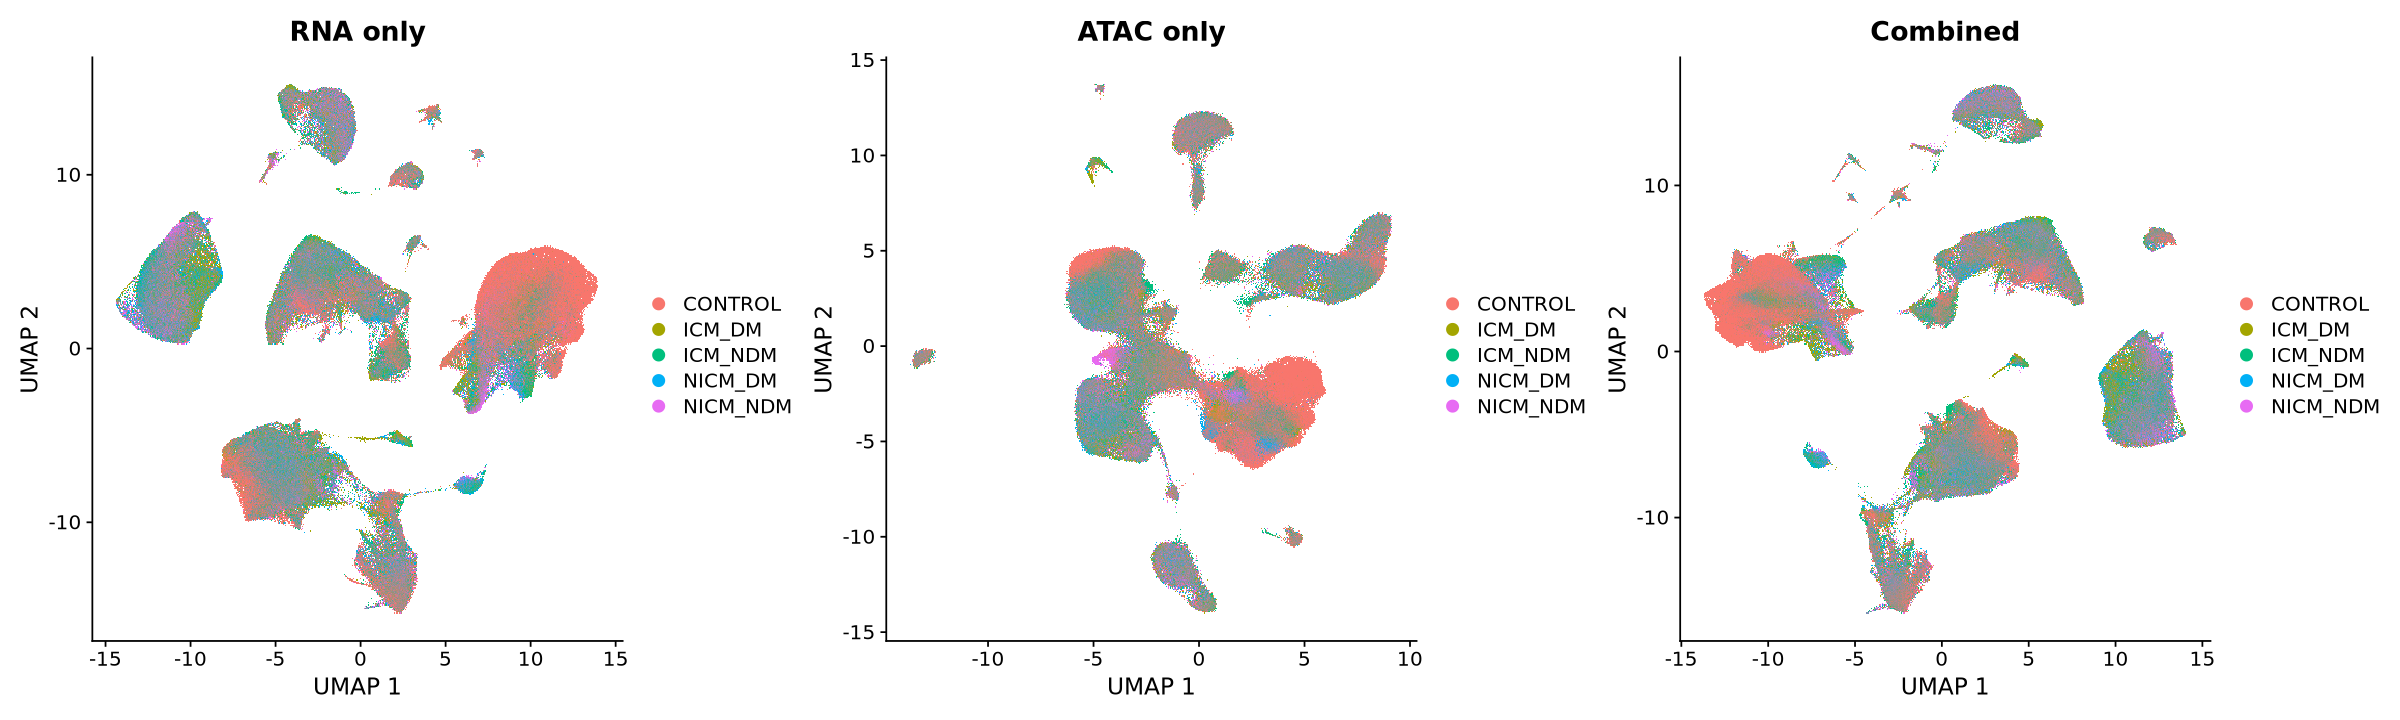

In [12]:
options(repr.plot.width=20, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='condition', label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='condition',  label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='condition', label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & theme(plot.title=element_text(hjust=0.5))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



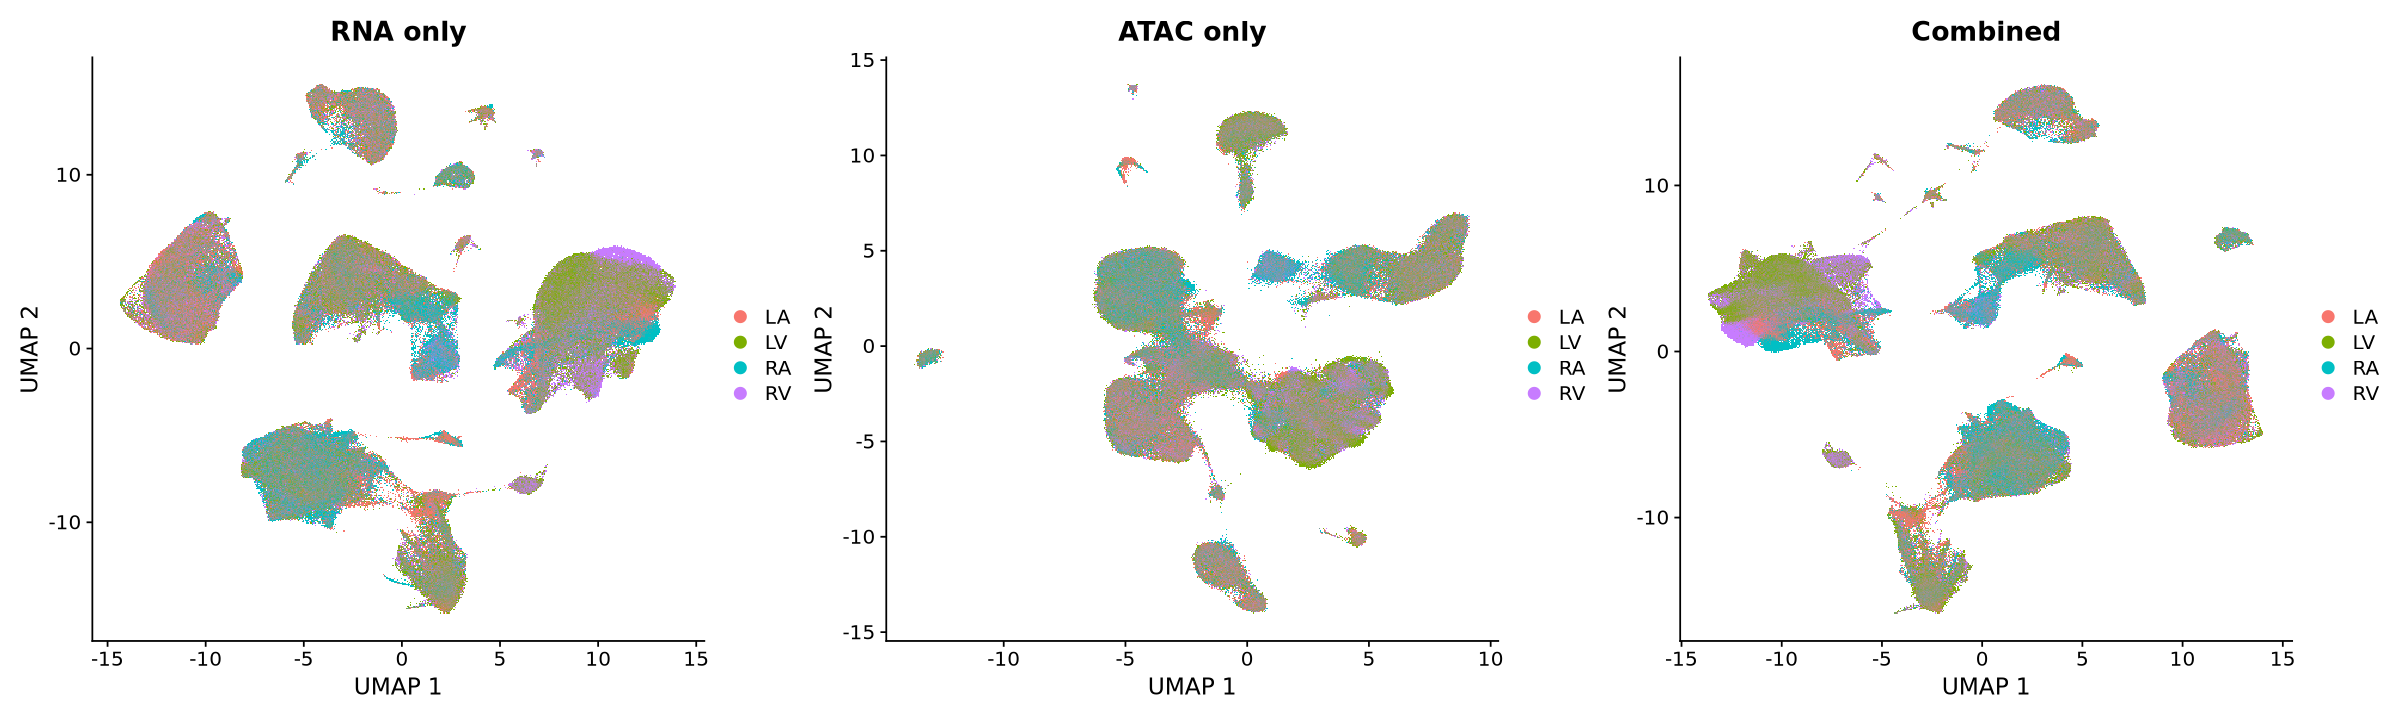

In [13]:
options(repr.plot.width=20, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='chamber', label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='chamber', label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='chamber',  label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & theme(plot.title=element_text(hjust=0.5))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



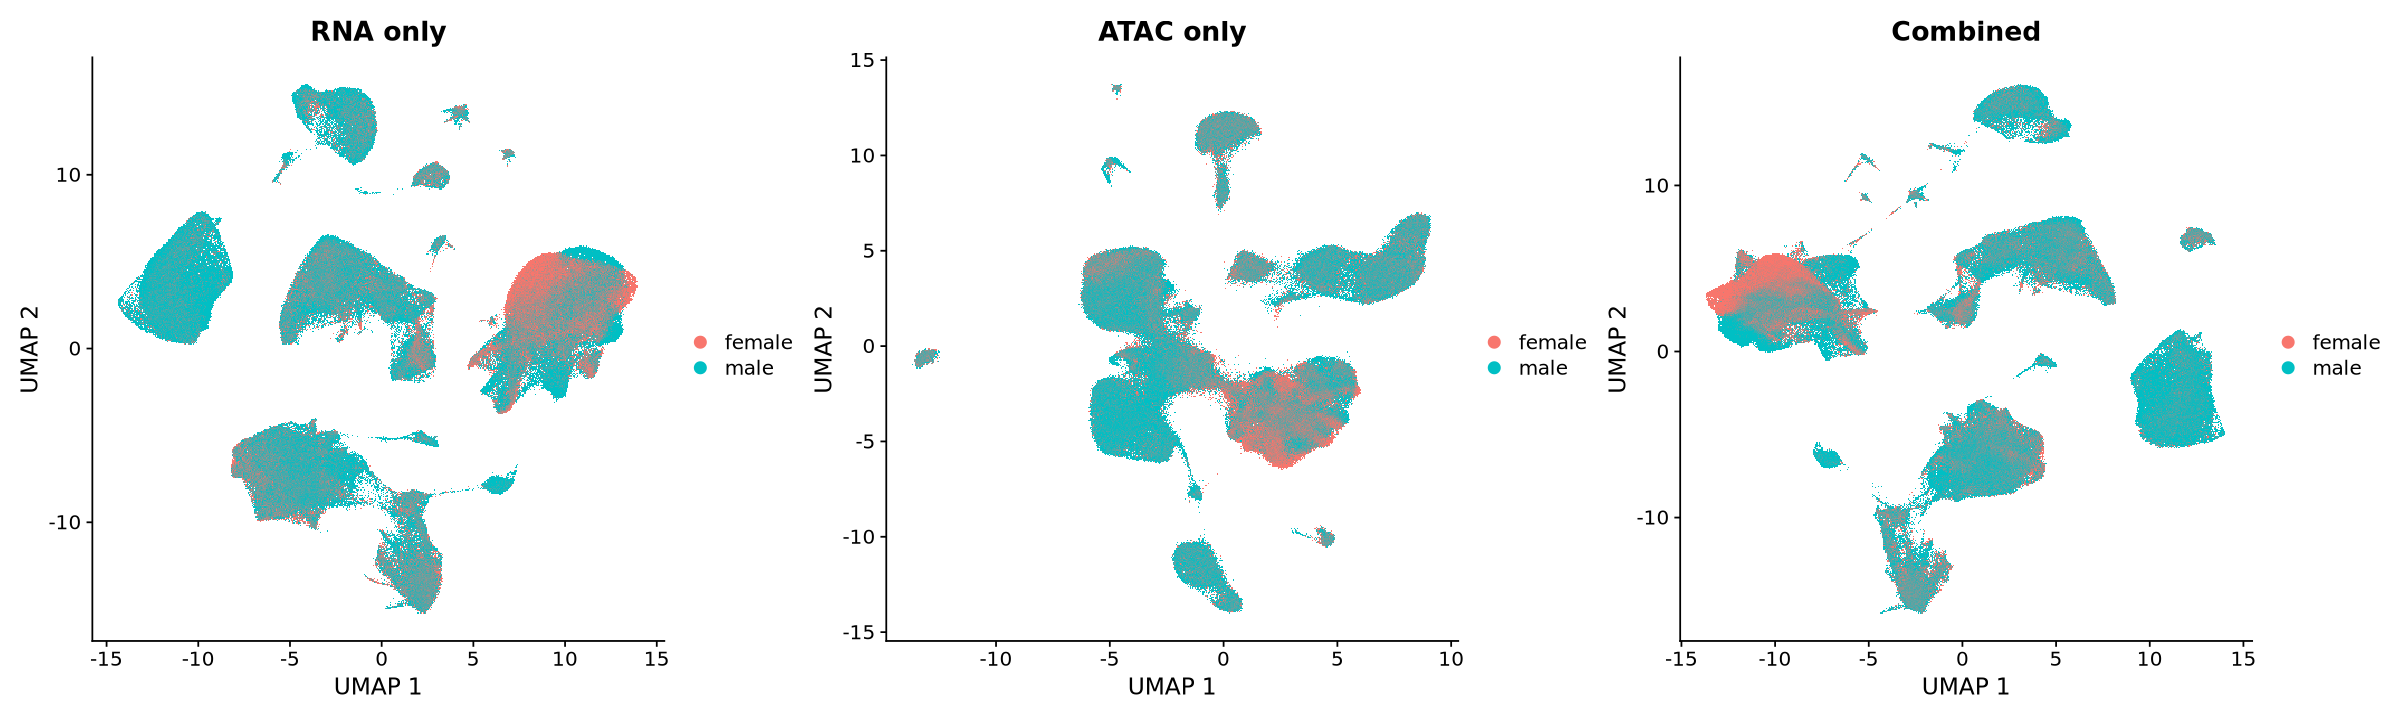

In [14]:
options(repr.plot.width=20, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='sex', label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='sex', label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='sex',  label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & theme(plot.title=element_text(hjust=0.5))

# Major CellType assignment

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



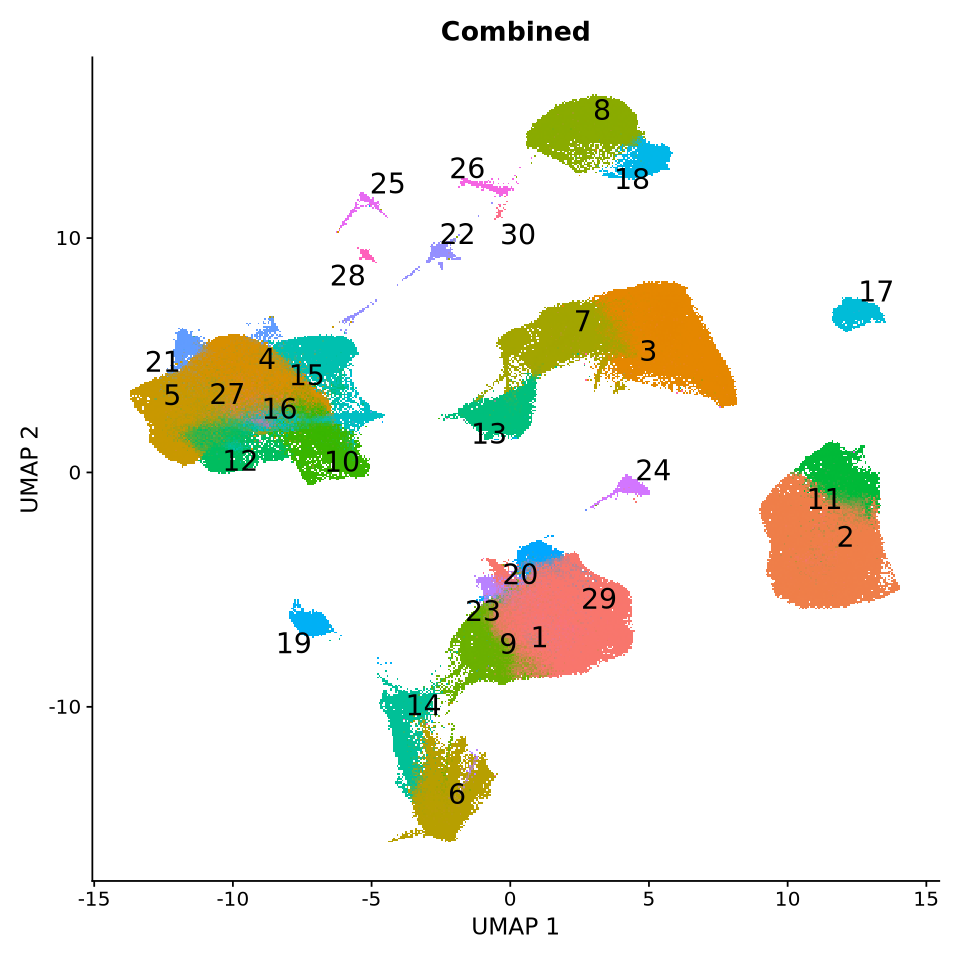

In [15]:
# Visualize clusters
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, group.by = "seurat_clusters", reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

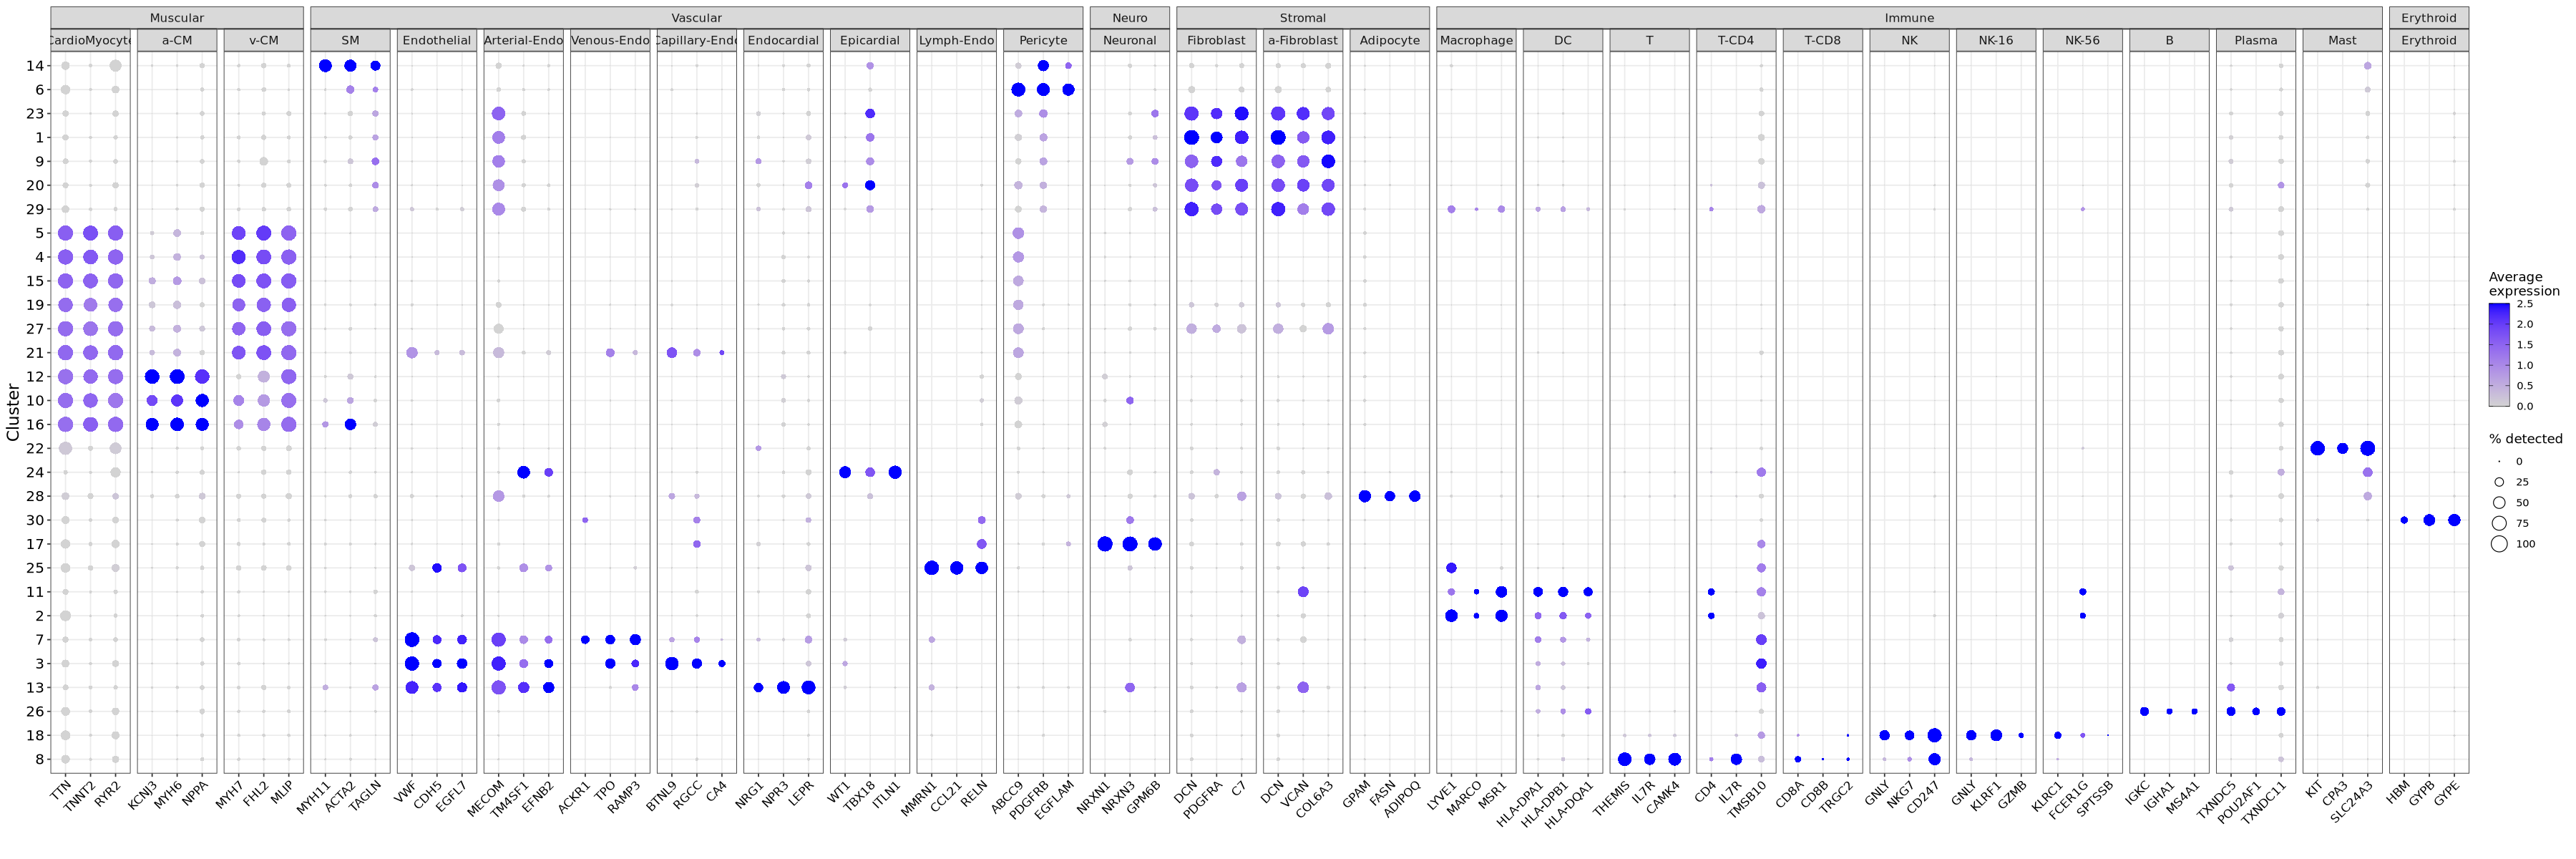

In [16]:
adata <- SetIdent(adata, value = adata$seurat_clusters)
g = DotPlot(adata, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=30, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [17]:
levels(cell.markers$CellType)

[1] "CardioMyocyte"  "a-CM"           "v-CM"           "SM"            
 [5] "Endothelial"    "Arterial-Endo"  "Venous-Endo"    "Capillary-Endo"
 [9] "Endocardial"    "Epicardial"     "Lymph-Endo"     "Pericyte"      
[13] "Neuronal"       "Fibroblast"     "a-Fibroblast"   "Adipocyte"     
[17] "Macrophage"     "DC"             "T"              "T-CD4"         
[21] "T-CD8"          "NK"             "NK-16"          "NK-56"         
[25] "B"              "Plasma"         "Mast"           "Erythroid"

In [18]:
# list cluster numbers as they appear in the dotplot
clusters = rev(levels(g$data$id))
clusters
# visually determine celltypes
celltypes = c("SM", "Pericyte", 
              "Fibroblast", "Fibroblast", "Fibroblast", "Fibroblast", "Fibroblast", 
              "CM", "CM", "CM", "CM", "CM", "CM", "CM", "CM", "CM",
              "Mast", 'Epicardial', "Adipocyte", 'Erythroid', 
              "Neuronal", 'Lymph-Endo', "DC", "Macrophage", 
              "Endothelial", "Endothelial", "Endocardial", 
              "B", "NK", "T")

length(clusters)
length(celltypes)

clusters.celltypes = data.frame(seurat_clusters = clusters,
                               celltypes = celltypes)

[1] "14" "6"  "23" "1"  "9"  "20" "29" "5"  "4"  "15" "19" "27" "21" "12" "10"
[16] "16" "22" "24" "28" "30" "17" "25" "11" "2"  "7"  "3"  "13" "26" "18" "8"

[1] 30

[1] 30

In [19]:
adata <- SetIdent(adata, value = adata$seurat_clusters)
levels(adata)
adata$major.celltypes <- clusters.celltypes$celltypes[match(adata$seurat_clusters, clusters.celltypes$seurat_clusters)]
adata <- SetIdent(adata, value = adata$major.celltypes)
levels(adata)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"

[1] "Fibroblast"  "Endothelial" "CM"          "Macrophage"  "Pericyte"   
 [6] "Mast"        "Endocardial" "T"           "Adipocyte"   "SM"         
[11] "DC"          "B"           "Neuronal"    "NK"          "Lymph-Endo" 
[16] "Epicardial"  "Erythroid"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



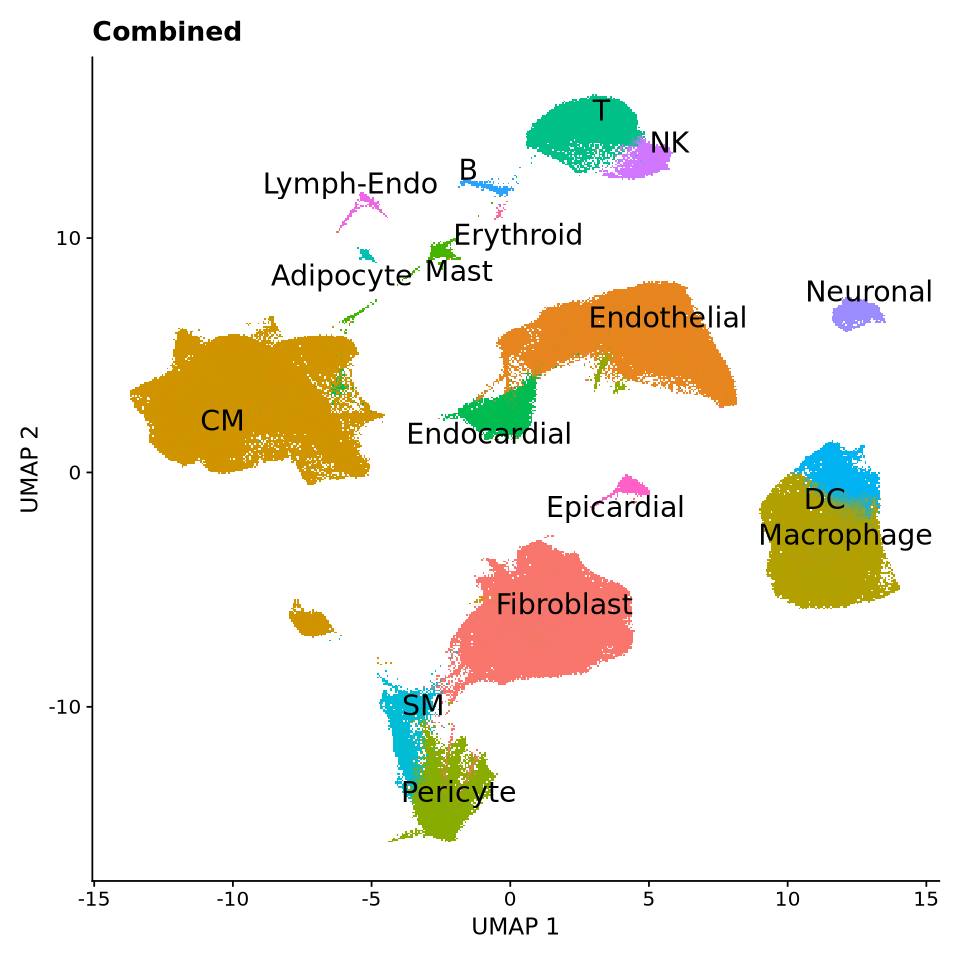

In [20]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') + theme(legend.position = "none")

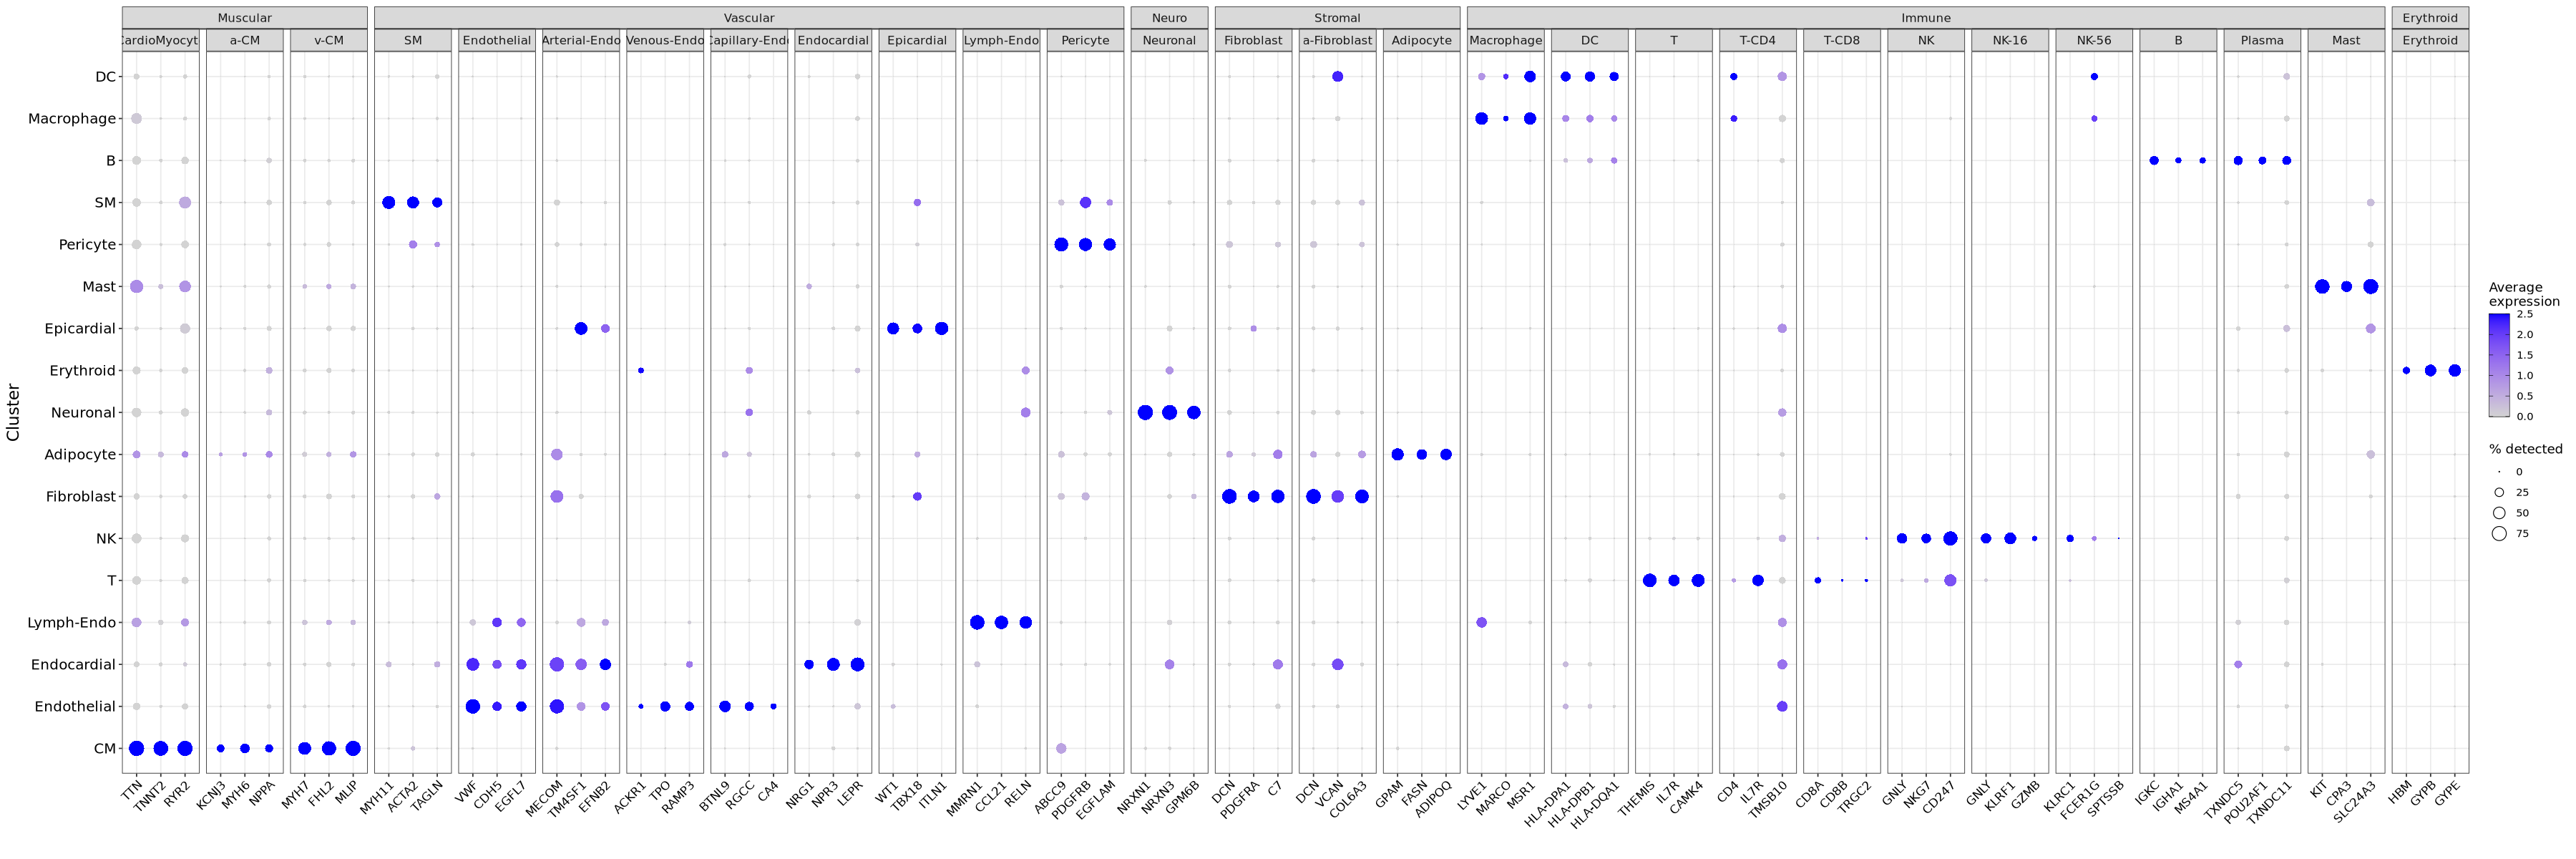

In [117]:
adata <- SetIdent(adata, value = adata$major.celltypes)
g = DotPlot(adata, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=30, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [150]:
cell.order = c('CM',
  
  'SM',
  'Endothelial', 
  'Endocardial',
  'Epicardial',
  'Lymph-Endo',
  'Pericyte',
  
  'Fibroblast', 
  'Adipocyte',
  'Neuronal',
  
  'Macrophage', 
  'DC',
  'Mast', 
  'T', 
  'NK', 
  'B', 
  'Erythroid')

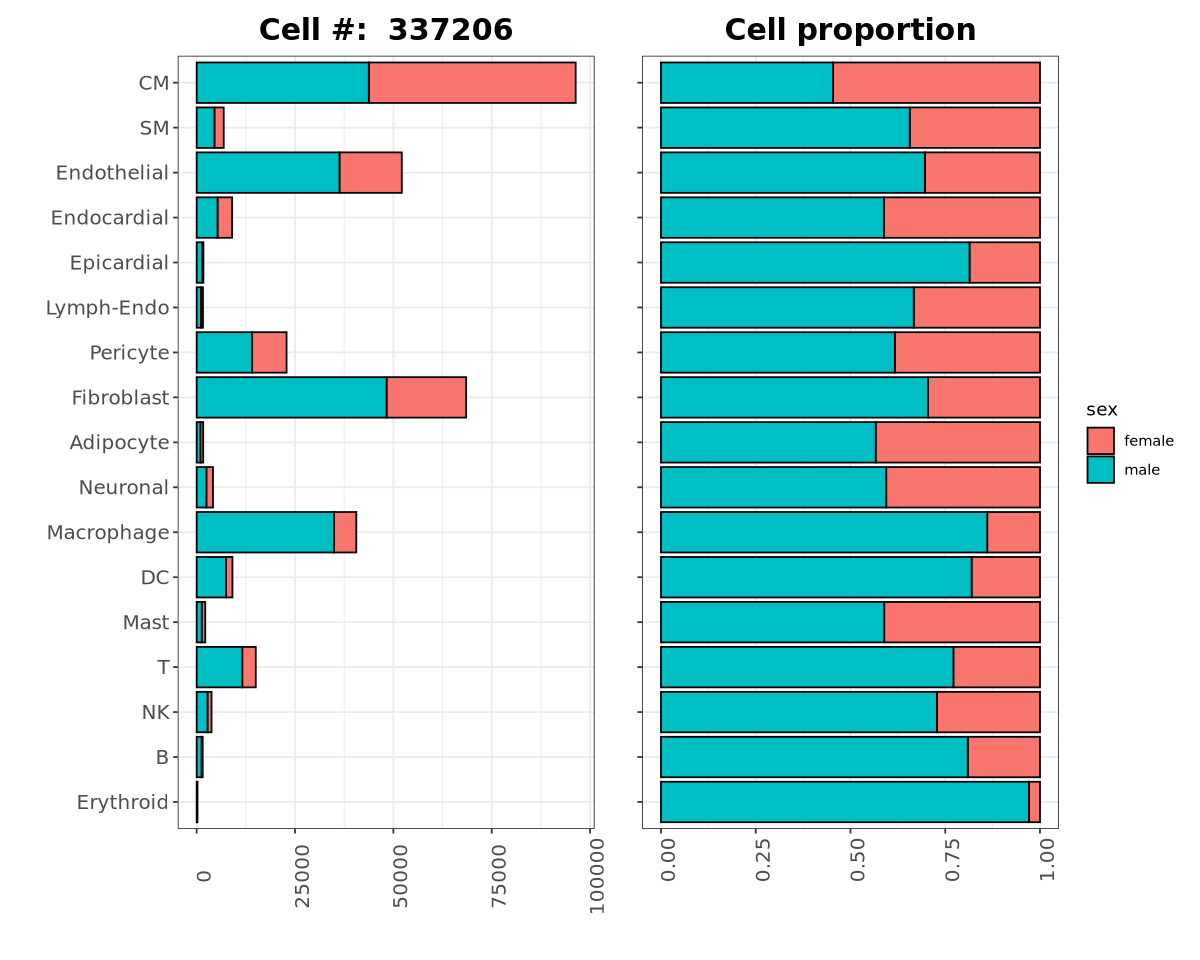

In [152]:
cell.sample = as.data.frame(table(adata$major.celltypes, adata$sex))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "sex"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$celltypes = factor(cell.sample$celltypes, levels = rev(cell.order))

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = celltypes, y = Freq, fill = sex, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = sex, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=10, repr.plot.height=8)
gg1 + gg2

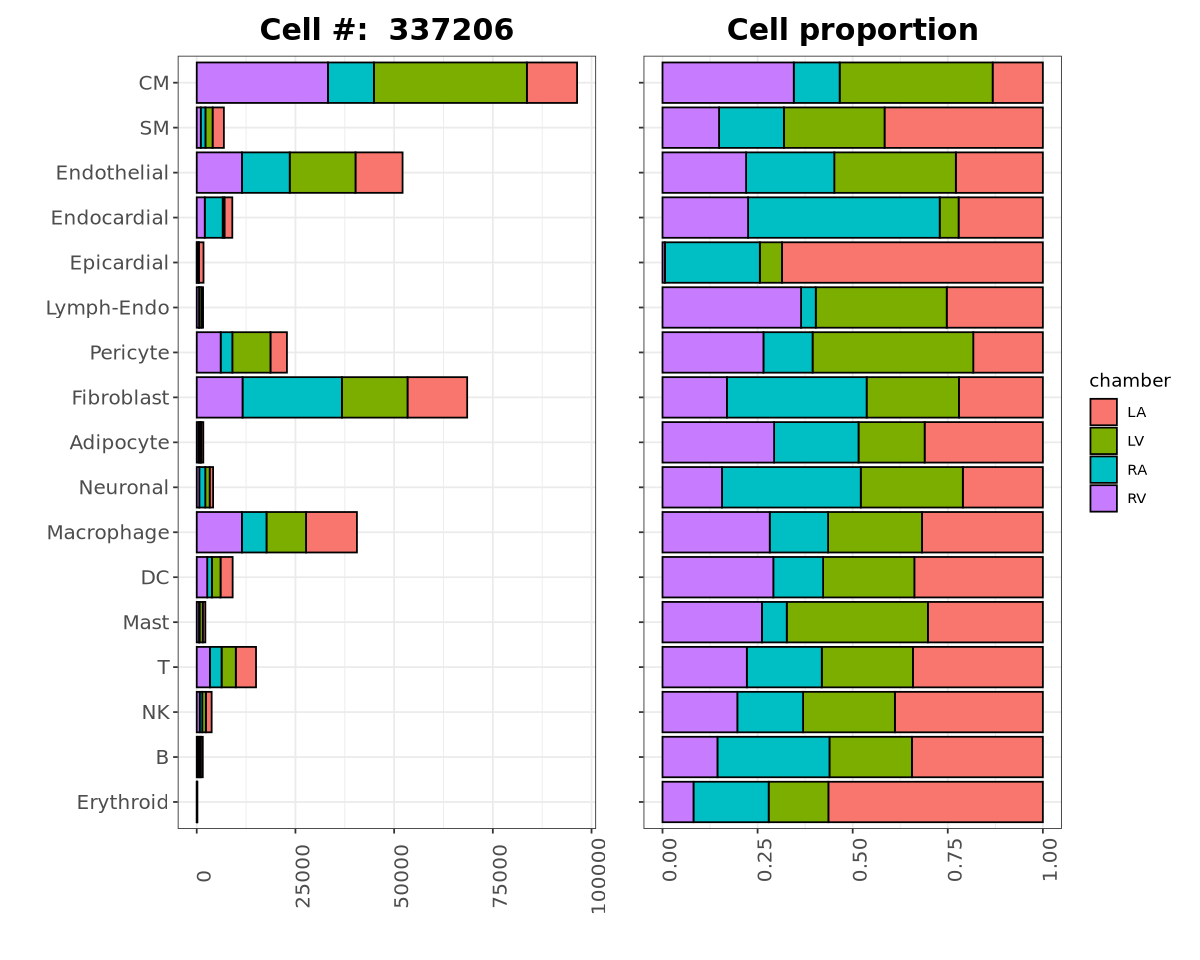

In [155]:
cell.sample = as.data.frame(table(adata$major.celltypes, adata$chamber))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "chamber"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$celltypes = factor(cell.sample$celltypes, levels = rev(cell.order))

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = celltypes, y = Freq, fill = chamber, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=10, repr.plot.height=8)
gg1 + gg2

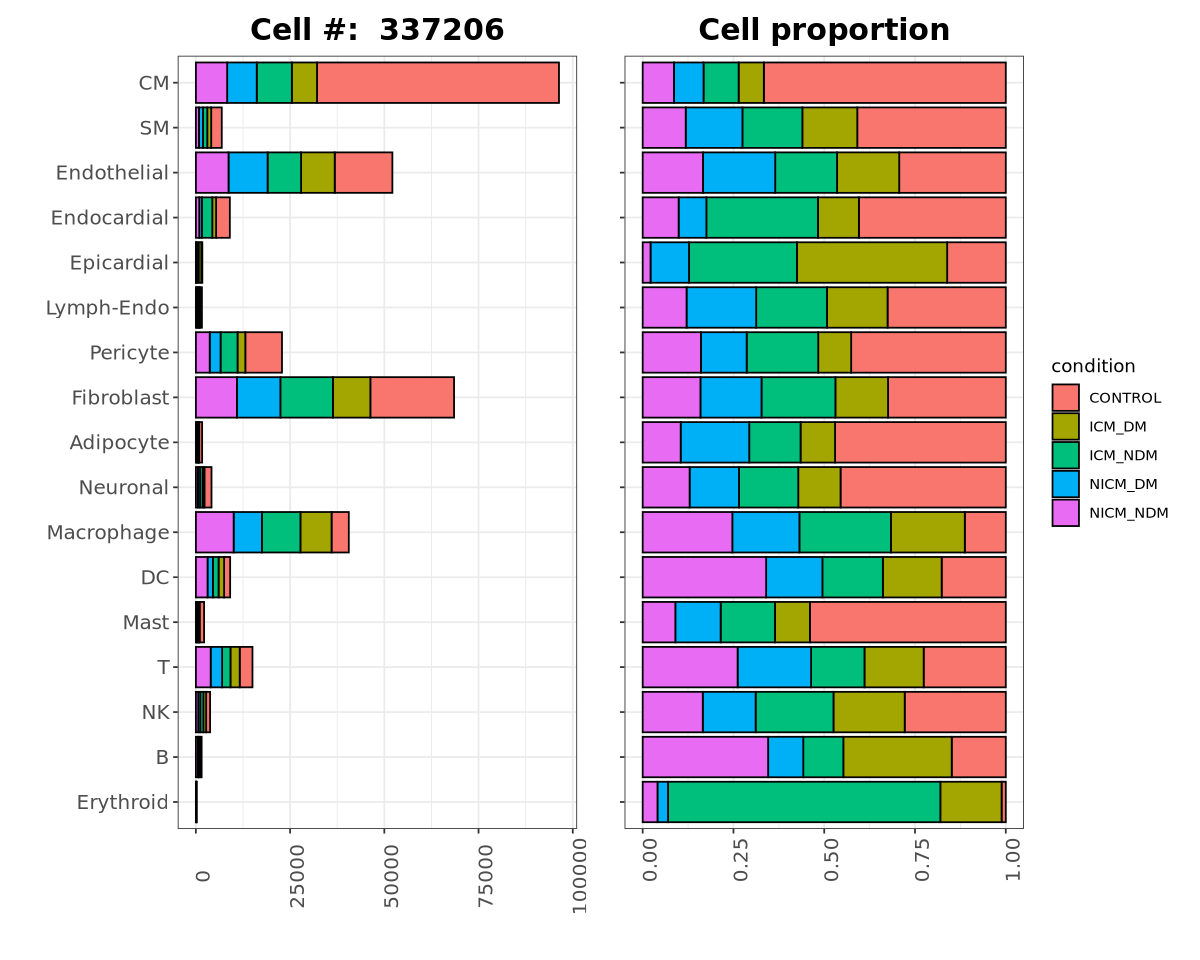

In [156]:
cell.sample = as.data.frame(table(adata$major.celltypes, adata$condition))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$celltypes = factor(cell.sample$celltypes, levels = rev(cell.order))

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = celltypes, y = Freq, fill = condition, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=10, repr.plot.height=8)
gg1 + gg2

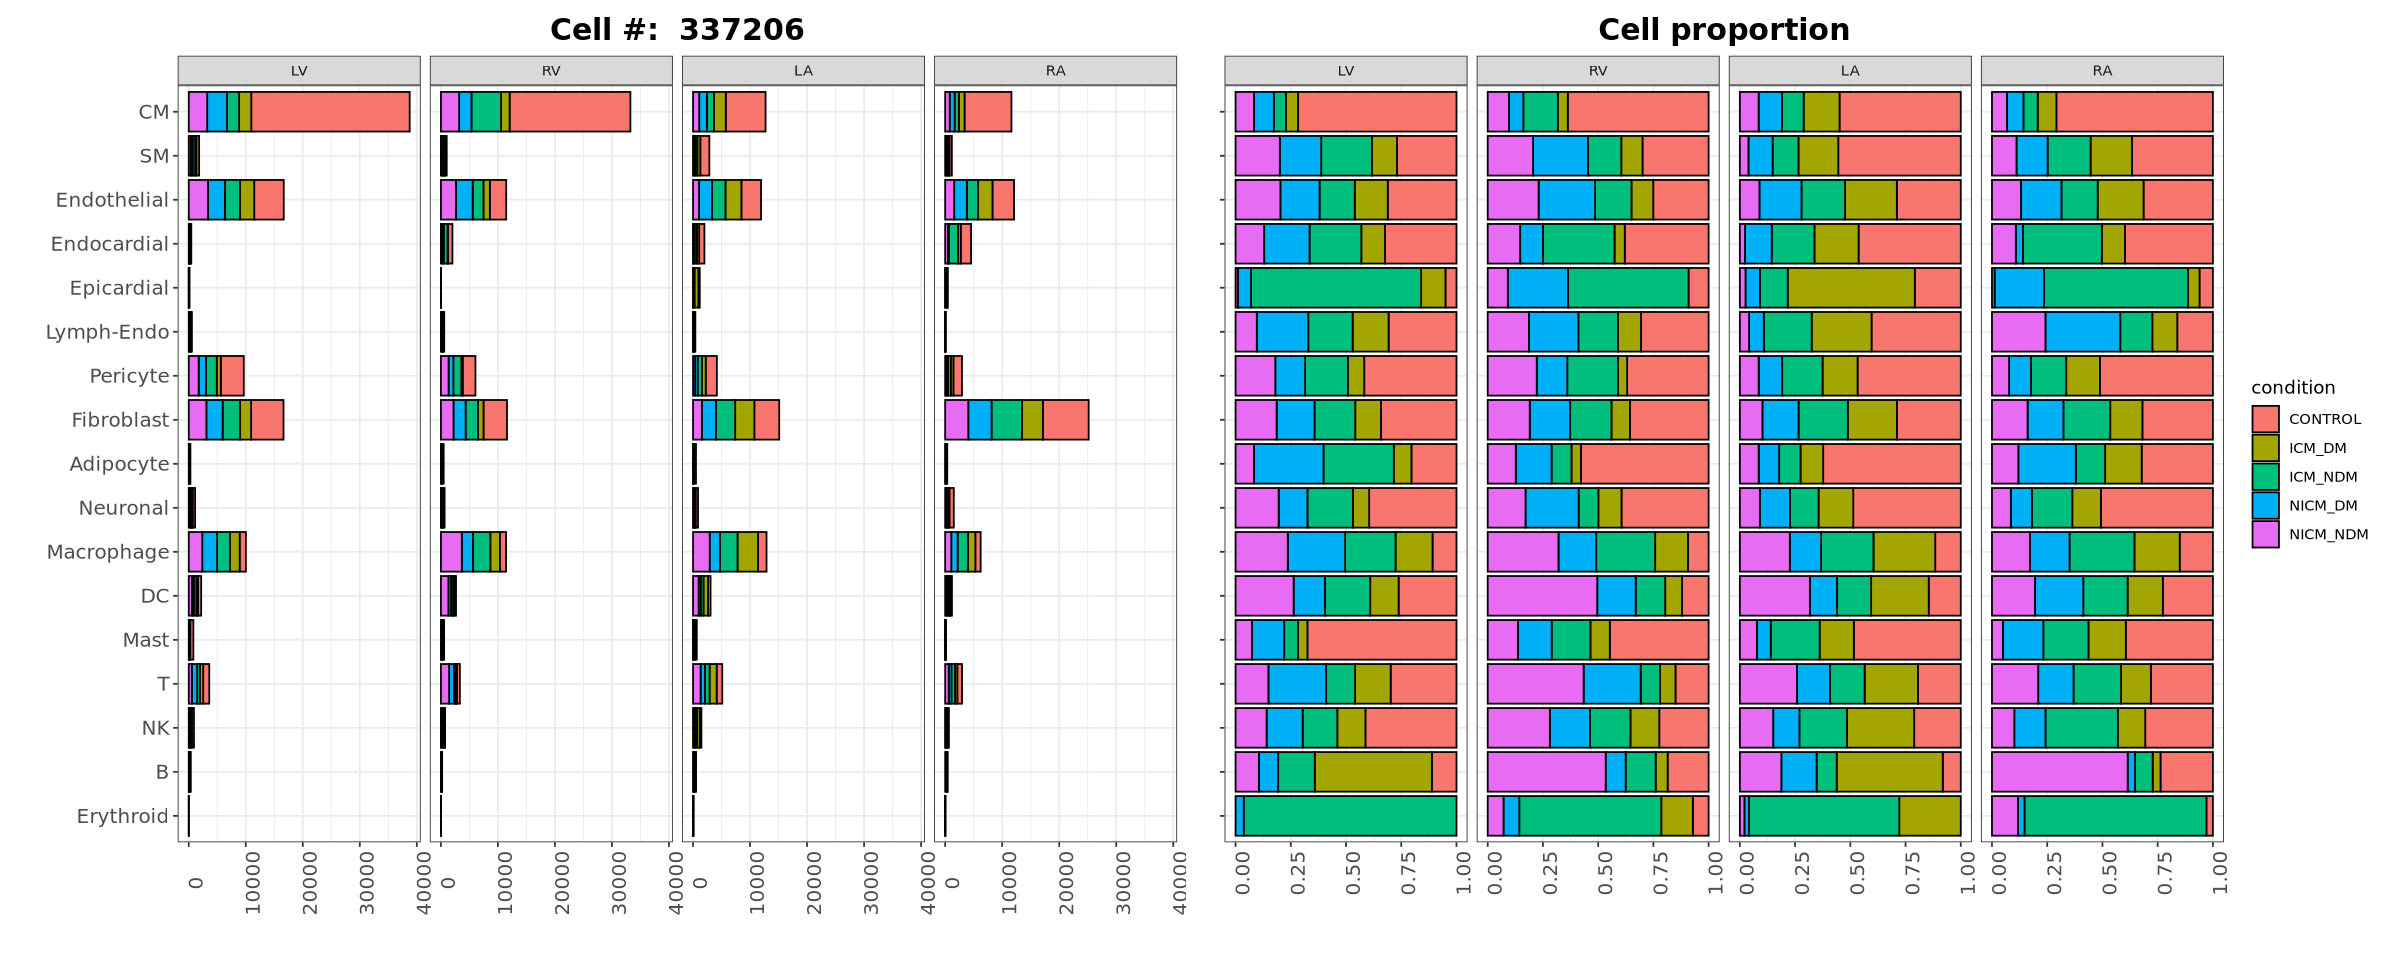

In [160]:
cell.sample = as.data.frame(table(adata$major.celltypes, adata$chamber, adata$condition))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "chamber"
colnames(cell.sample)[3] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$celltypes = factor(cell.sample$celltypes, levels = rev(cell.order))
cell.sample$chamber = factor(cell.sample$chamber, levels = c("LV", "RV", "LA", "RA"))

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = celltypes, y = Freq, fill = condition, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip() +
  facet_nested(cols = vars(chamber), scales = "fixed", space = "free")


gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip() +
  facet_nested(cols = vars(chamber), scales = "free", space = "free")

options(repr.plot.width=20, repr.plot.height=8)
gg1 + gg2

In [41]:
### Write  RDS
log_print("Saving RDS")
file = paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds", sep = "")
saveRDS(adata, file = file)
log_print("RDS - Saved")

[1] "Saving RDS"
[1] "RDS - Saved"


# Cell-subtype assignment

In [21]:
# initialize dataframe:
barcodes.celltype = NULL
# Backup object
# adata.bkp = adata
# adata = adata.bkp

## Endothelial

In [24]:
cluster = "3"

In [38]:
gc(reset = TRUE)
adata <- SetIdent(adata, value = adata$seurat_clusters)
# Subcluster
adata.use <- FindSubCluster(adata, 
                                 cluster=cluster,
                                 resolution = 0.1,
                                 algorithm = 4,
                                 graph.name = 'wsnn')
# Subset the tmp obj 4 visualization
adata.use <- subset(adata.use, subset=seurat_clusters == cluster)

used        (Mb)     gc trigger  (Mb)     max used    (Mb)    
Ncells    14215877    759.3    26637987   1422.7    14215877    759.3
Vcells 13842590075 105610.6 37240421714 284121.9 13842590075 105610.6

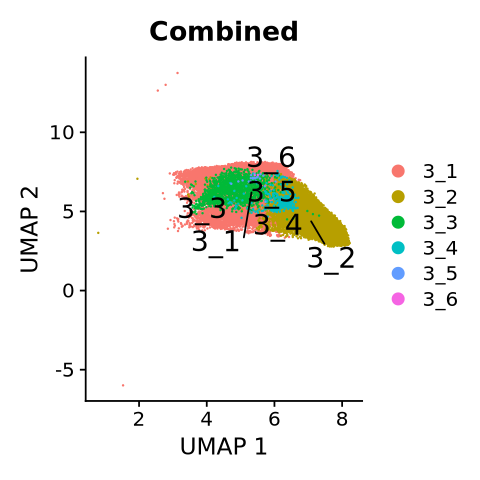

In [39]:
# Visualize clusters
options(repr.plot.width=4, repr.plot.height=4)
DimPlot(adata.use, group.by = "sub.cluster", reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE, order = TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

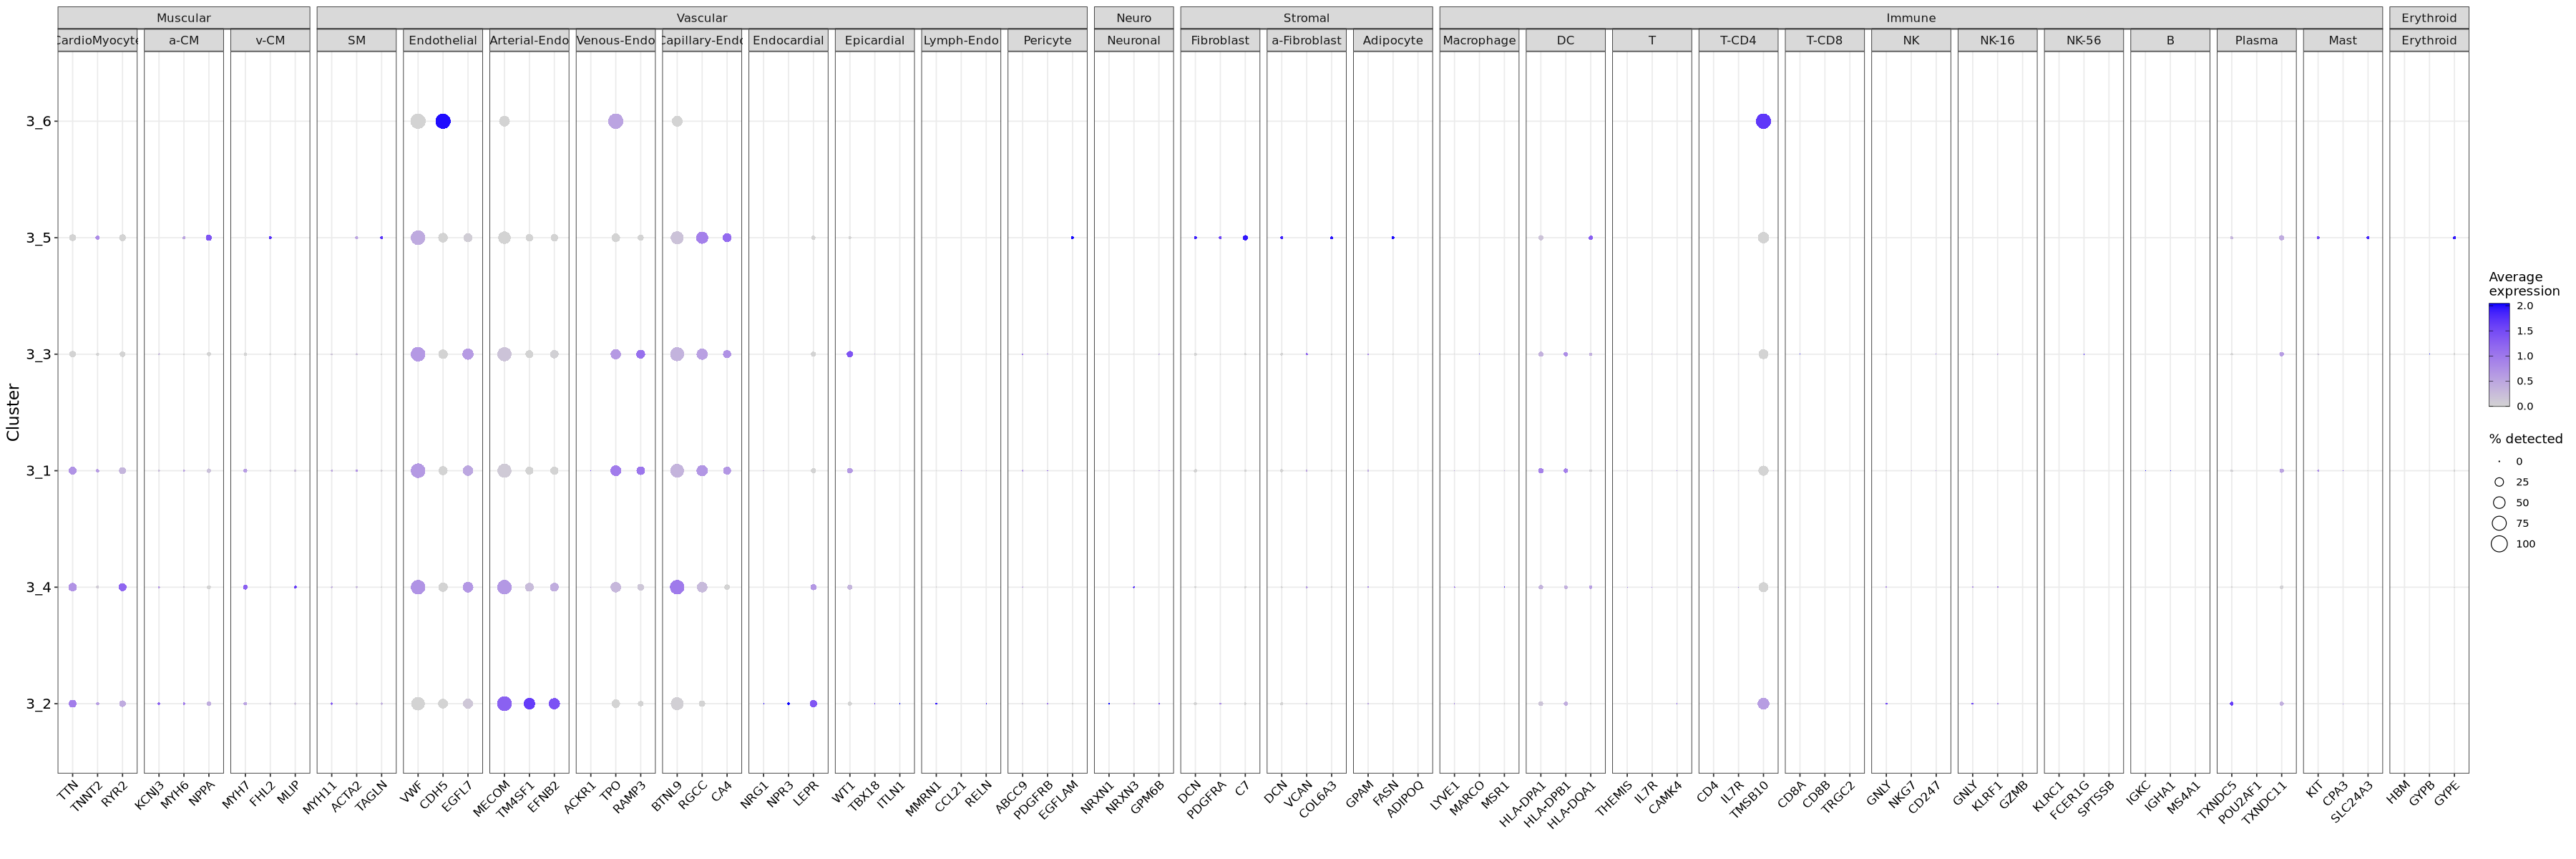

In [40]:
adata.use <- SetIdent(adata.use, value = adata.use$sub.cluster)
g = DotPlot(adata.use, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=30, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [42]:
adata.use <- SetIdent(adata.use, value = adata.use$sub.cluster)

# Arterial
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata.use, ident = c("3_2", "3_4")),
                                   celltype = "Art-Endo")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Capillary
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata.use, ident = c("3_1", "3_3", "3_5", "3_6")),
                                   celltype = "Cap-Endo")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

In [43]:
# Venous
adata <- SetIdent(adata, value = adata$seurat_clusters)

barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "7"),
                                   celltype = "Ven-Endo")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

## B

In [44]:
cluster = "B"
unique(adata$major.celltypes)

[1] "Fibroblast"  "Endothelial" "CM"          "Macrophage"  "Pericyte"   
 [6] "Mast"        "Endocardial" "T"           "Adipocyte"   "SM"         
[11] "DC"          "B"           "Neuronal"    "NK"          "Lymph-Endo" 
[16] "Epicardial"  "Erythroid"

In [45]:
gc(reset = TRUE)
adata <- SetIdent(adata, value = adata$major.celltypes)
# Subcluster
adata.use <- FindSubCluster(adata, 
                                 cluster=cluster,
                                 resolution = 0.1,
                                 algorithm = 4,
                                 graph.name = 'wsnn')
# Subset the tmp obj 4 visualization
adata.use <- subset(adata.use, subset=major.celltypes == cluster)

used        (Mb)     gc trigger  (Mb)     max used    (Mb)    
Ncells    14214971    759.2    26637987   1422.7    14214971    759.2
Vcells 13842225789 105607.9 37240421714 284121.9 13842225789 105607.9

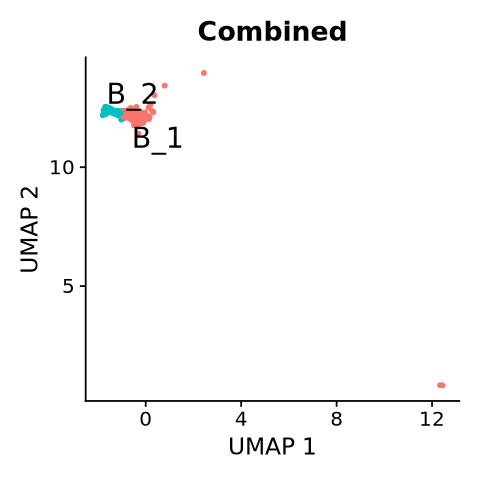

In [46]:
# Visualize clusters
options(repr.plot.width=4, repr.plot.height=4)
DimPlot(adata.use, group.by = "sub.cluster", reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

In [47]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "B-markers.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]

cell.compartment = cell.markers[,-3]

gather: reorganized (Marker.1, Marker.2, Marker.3, Marker.4, Marker.5, …) into (Key, marker) [was 6x13, now 66x4]


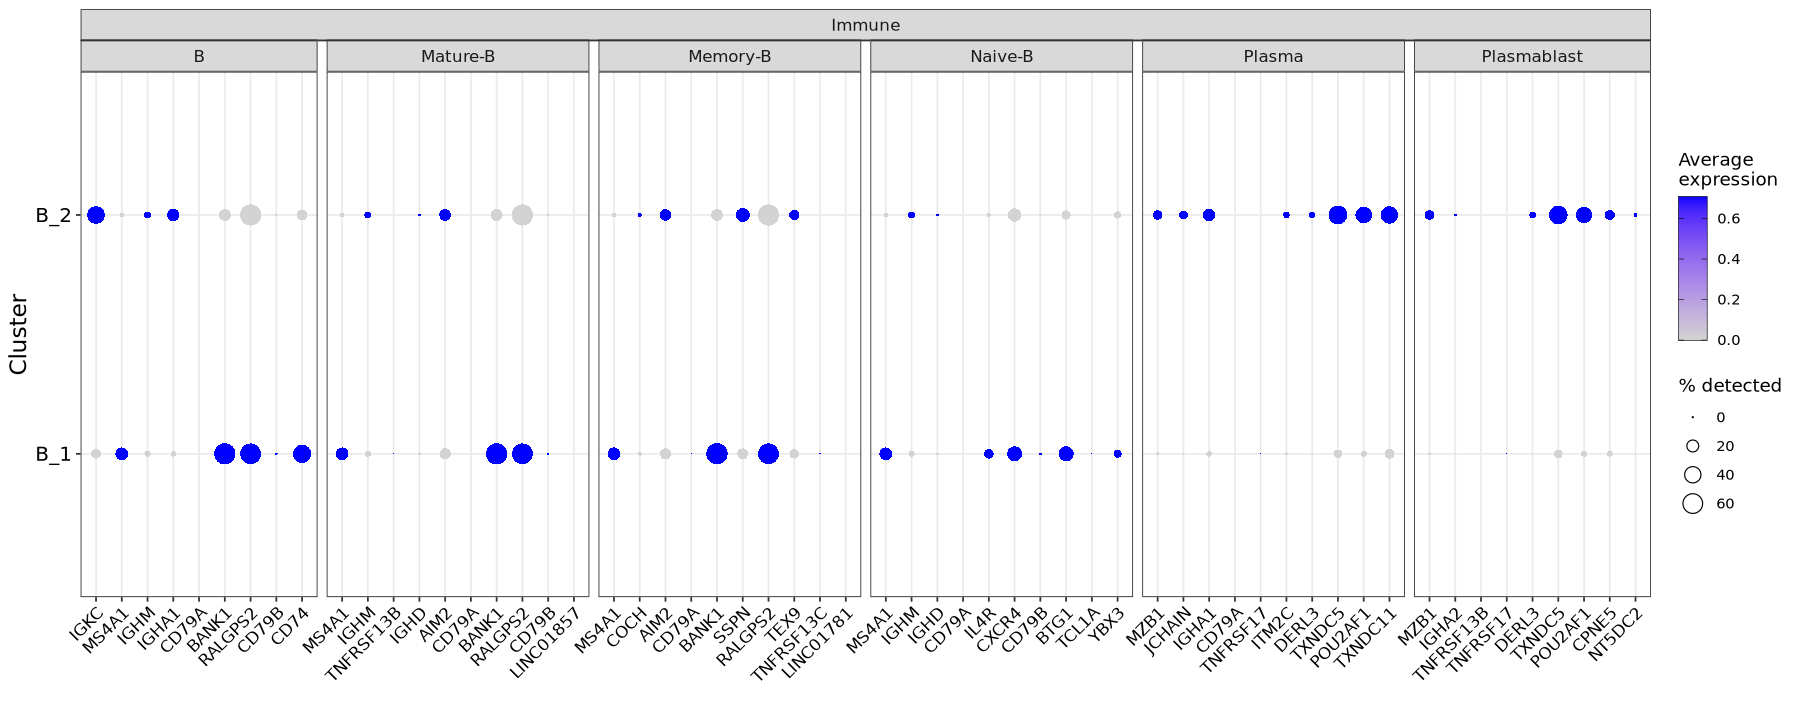

In [48]:
g = DotPlot(adata.use, assay='SCT', group.by = "sub.cluster", features = unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=15, repr.plot.height=6)
    ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")

In [49]:
# B2 is Plasma and B1 is B cells

In [50]:
adata.use <- SetIdent(adata.use, value = adata.use$sub.cluster)

# B
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata.use, ident = "B_1"),
                                   celltype = "B")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Plasma
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata.use, ident = "B_2"),
                                   celltype = "Plasma")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

## T

In [51]:
cluster = "T"
unique(adata$major.celltypes)

[1] "Fibroblast"  "Endothelial" "CM"          "Macrophage"  "Pericyte"   
 [6] "Mast"        "Endocardial" "T"           "Adipocyte"   "SM"         
[11] "DC"          "B"           "Neuronal"    "NK"          "Lymph-Endo" 
[16] "Epicardial"  "Erythroid"

In [52]:
gc(reset = TRUE)
adata <- SetIdent(adata, value = adata$major.celltypes)
# Subcluster
adata.use <- FindSubCluster(adata, 
                                 cluster=cluster,
                                 resolution = 0.1,
                                 algorithm = 4,
                                 graph.name = 'wsnn')
# Subset the tmp obj 4 visualization
adata.use <- subset(adata.use, subset=major.celltypes == cluster)

used        (Mb)    gc trigger  (Mb)     max used    (Mb)   
Ncells    14187035   757.7    26637987   1422.7    14187035   757.7
Vcells 13048537839 99552.5 37240421714 284121.9 13048537839 99552.5

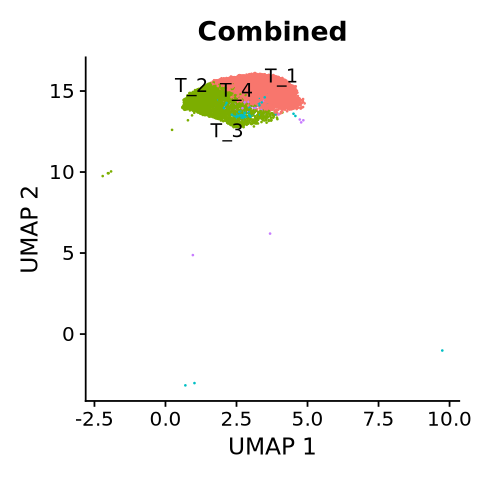

In [53]:
# Visualize clusters
options(repr.plot.width=4, repr.plot.height=4)
DimPlot(adata.use, group.by = "sub.cluster", reduction='umap.wnn', label=TRUE, label.size=4, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

In [54]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "T-markers.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]

cell.compartment = cell.markers[,-3]

gather: reorganized (Marker.1, Marker.2, Marker.3, Marker.4, Marker.5, …) into (Key, marker) [was 12x12, now 120x4]


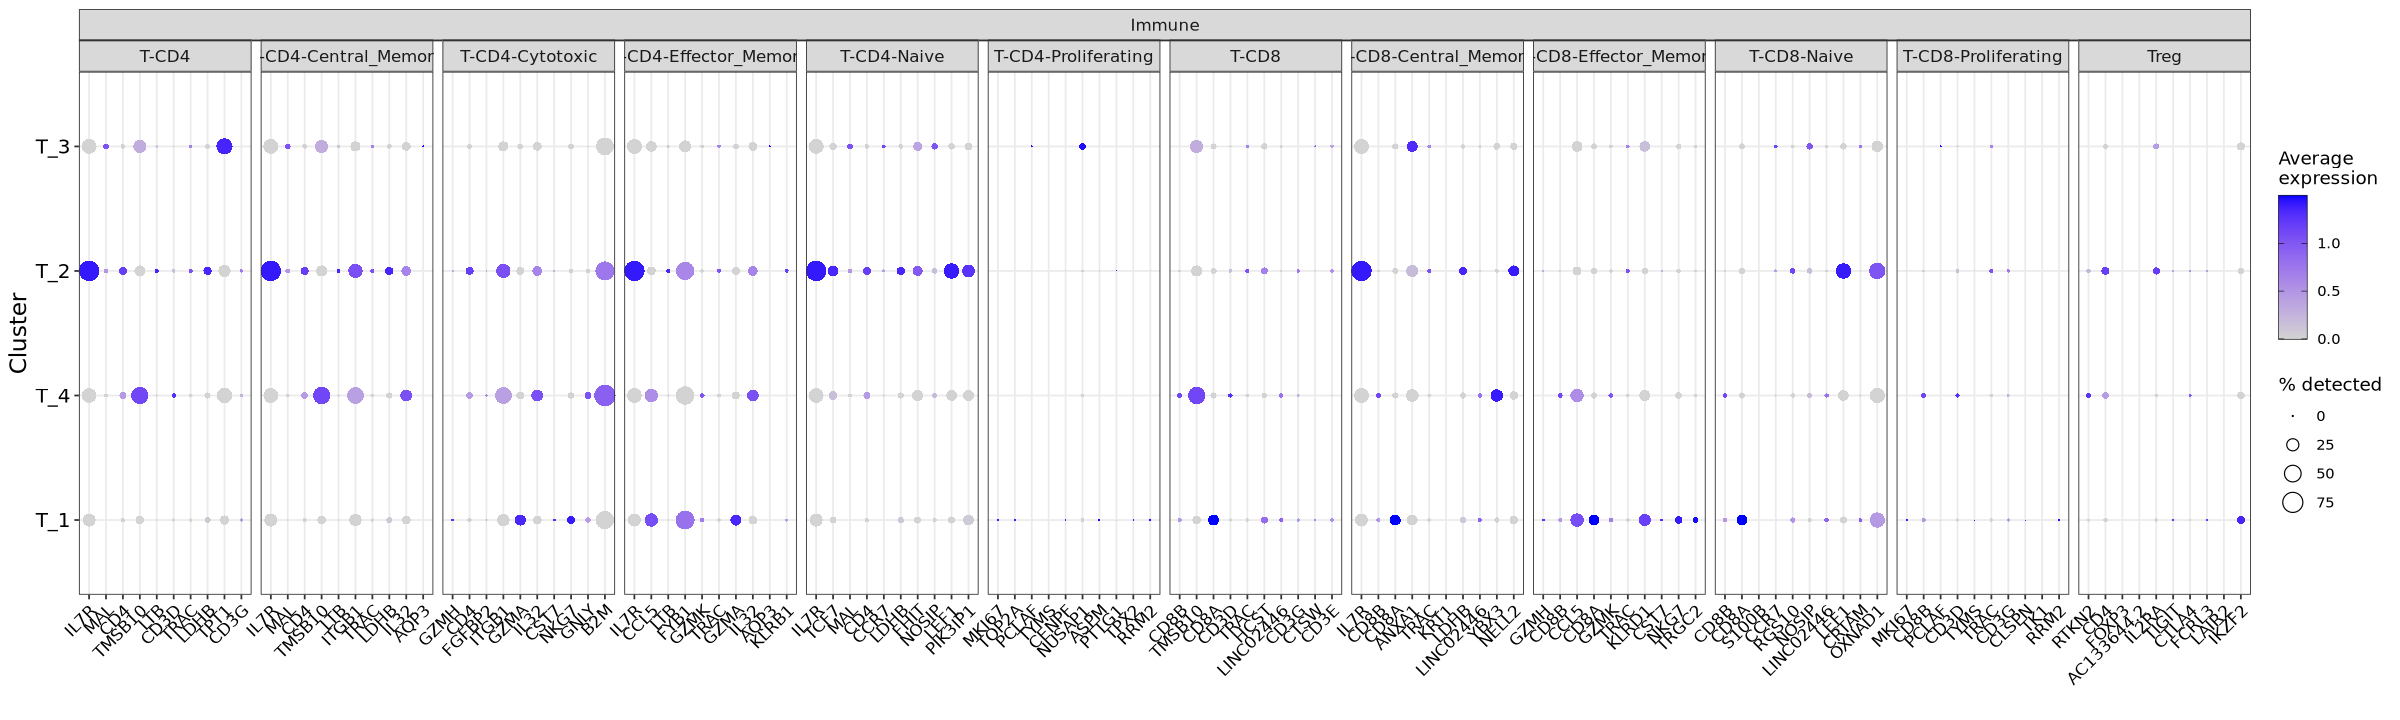

In [55]:
g = DotPlot(adata.use, assay='SCT', group.by = "sub.cluster", features = unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=20, repr.plot.height=6)
    ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")

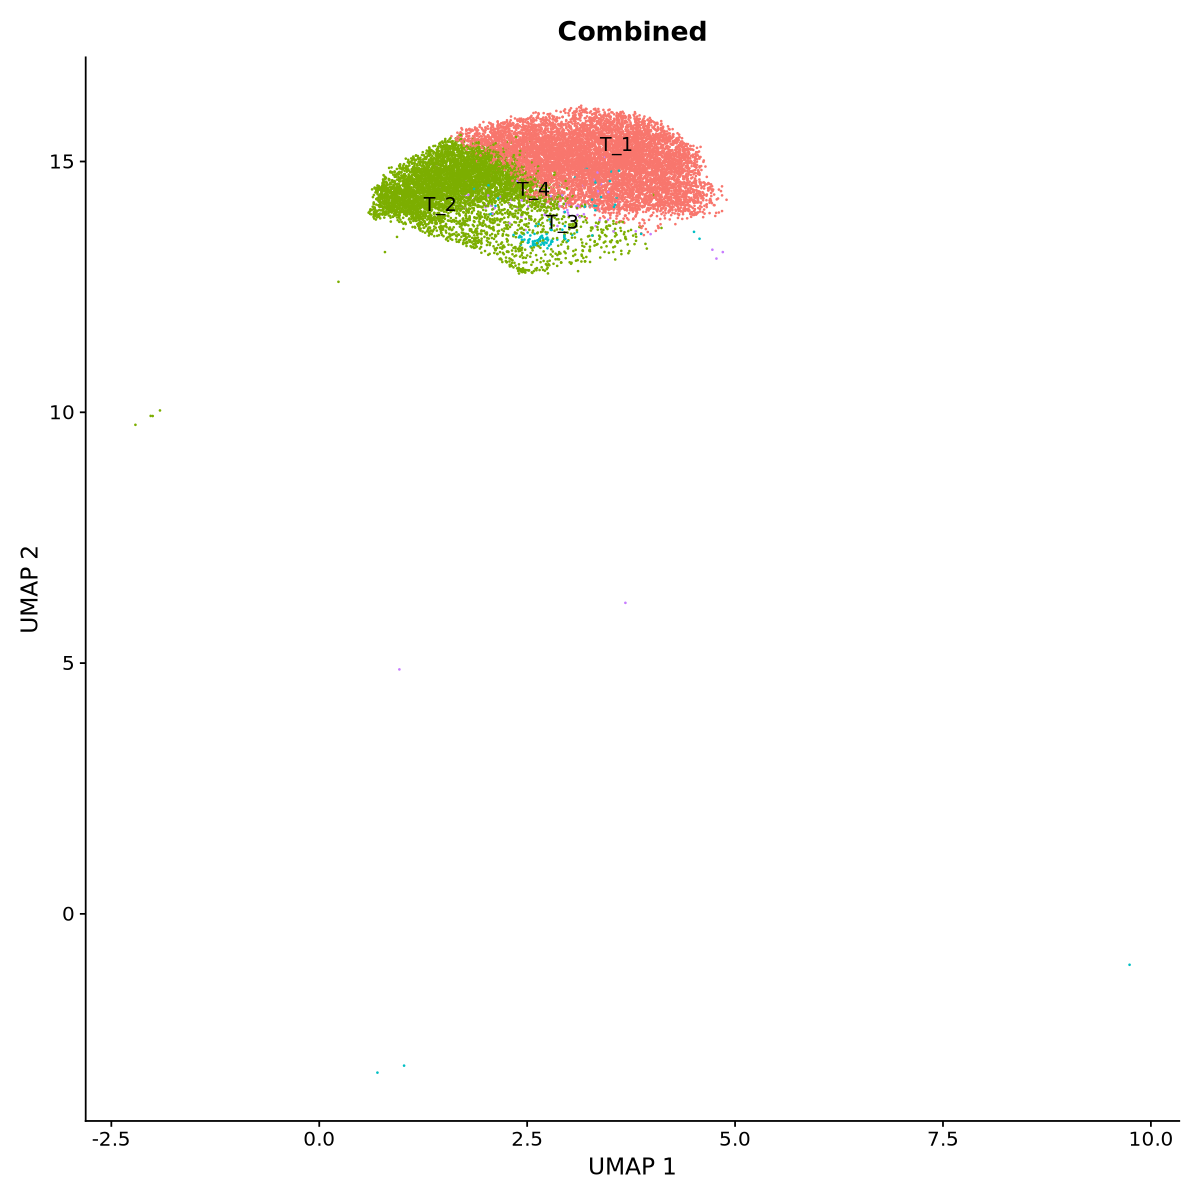

In [56]:
# Visualize clusters
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata.use, group.by = "sub.cluster", reduction='umap.wnn', label=TRUE, label.size=4, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

In [57]:
table(adata.use$sub.cluster)


 T_1  T_2  T_3  T_4 
8789 6025  105  100 

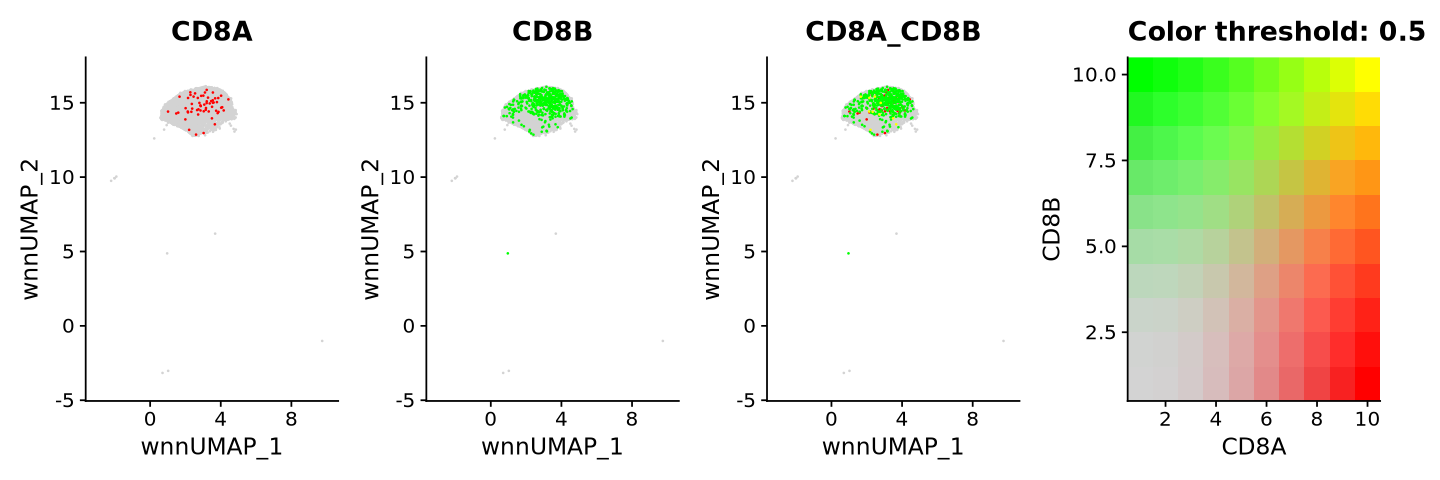

In [58]:
options(repr.plot.width=12, repr.plot.height=4)
DefaultAssay(adata.use) <- 'SCT'
FeaturePlot(adata.use, reduction = "umap.wnn",
            features = c("CD8A", "CD8B"), blend = TRUE, order = TRUE)

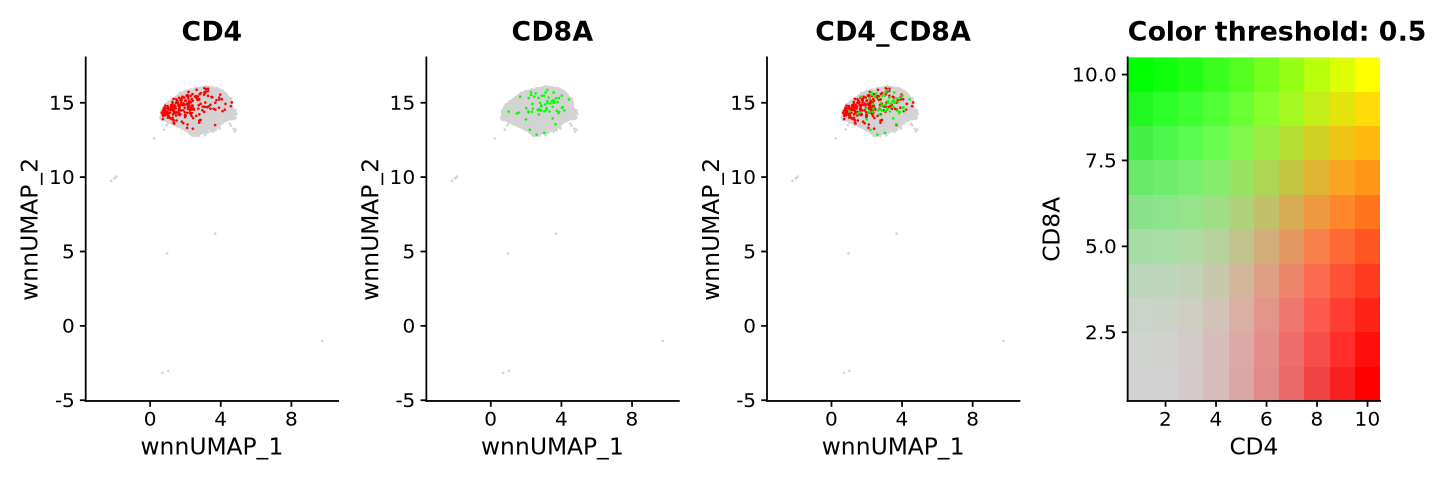

In [59]:
options(repr.plot.width=12, repr.plot.height=4)
DefaultAssay(adata.use) <- 'SCT'
FeaturePlot(adata.use,reduction = "umap.wnn",
            features = c("CD4", "CD8A"), blend = TRUE, order = TRUE)

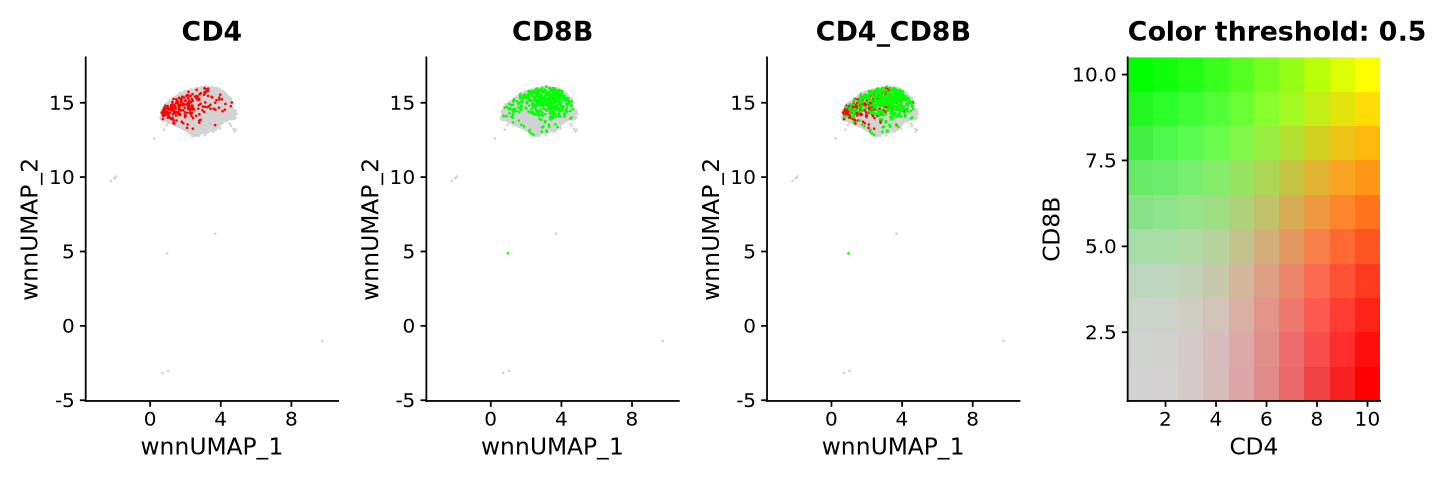

In [60]:
options(repr.plot.width=12, repr.plot.height=4)
DefaultAssay(adata.use) <- 'SCT'
FeaturePlot(adata.use,reduction = "umap.wnn",
            features = c("CD4", "CD8B"), blend = TRUE, order = TRUE)

In [61]:
adata.use <- SetIdent(adata.use, value = adata.use$sub.cluster)

# CD4
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata.use, ident = c("T_2", "T_3", "T_4")),
                                   celltype = "T-CD4")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# CD8
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata.use, ident = "T_1"),
                                   celltype = "T-CD8")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

## NK

In [62]:
cluster = "NK"
unique(adata$celltypes)

[1] "Fibroblast_HF"  "Cap-Endo"       "vCM"            "Ven-Endo"      
 [5] "Macrophage"     "Art-Endo"       "Pericyte"       "vCM_HF"        
 [9] "Fibroblast_CTR" "vCM_ICM"        "Mast"           "Endocardial"   
[13] "T-CD8"          "SM"             "DC"             "B"             
[17] "Neuronal"       "CM_NICM"        "T-CD4"          "NK-CD16"       
[21] "aFibroblast_1"  "Lymph-Endo"     "Plasma"         "aCM_2"         
[25] "NK-CD56"        "Epicardial"     "aFibroblast_2"  "Adipocyte"     
[29] "Erythroid"      "aCM_1"

In [63]:
gc(reset = TRUE)
adata <- SetIdent(adata, value = adata$major.celltypes)
# Subcluster
adata.use <- FindSubCluster(adata, 
                                 cluster=cluster,
                                 resolution = 0.2,
                                 algorithm = 4,
                                 graph.name = 'wsnn')
# Subset the tmp obj 4 visualization
adata.use <- subset(adata.use, subset=major.celltypes == cluster)

used        (Mb)     gc trigger  (Mb)     max used    (Mb)    
Ncells    14222272    759.6    26637987   1422.7    14222272    759.6
Vcells 13349661342 101849.9 37240421714 284121.9 13349661342 101849.9

2 singletons identified. 3 final clusters.



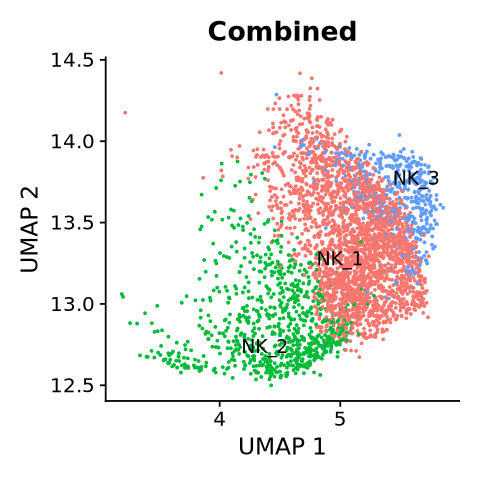

In [64]:
# Visualize clusters
options(repr.plot.width=4, repr.plot.height=4)
DimPlot(adata.use, group.by = "sub.cluster", reduction='umap.wnn', label=TRUE, label.size=4, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

In [65]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "NK-Markers.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]

cell.compartment = cell.markers[,-3]

gather: reorganized (Marker.1, Marker.2, Marker.3, Marker.4, Marker.5, …) into (Key, marker) [was 3x12, now 30x4]


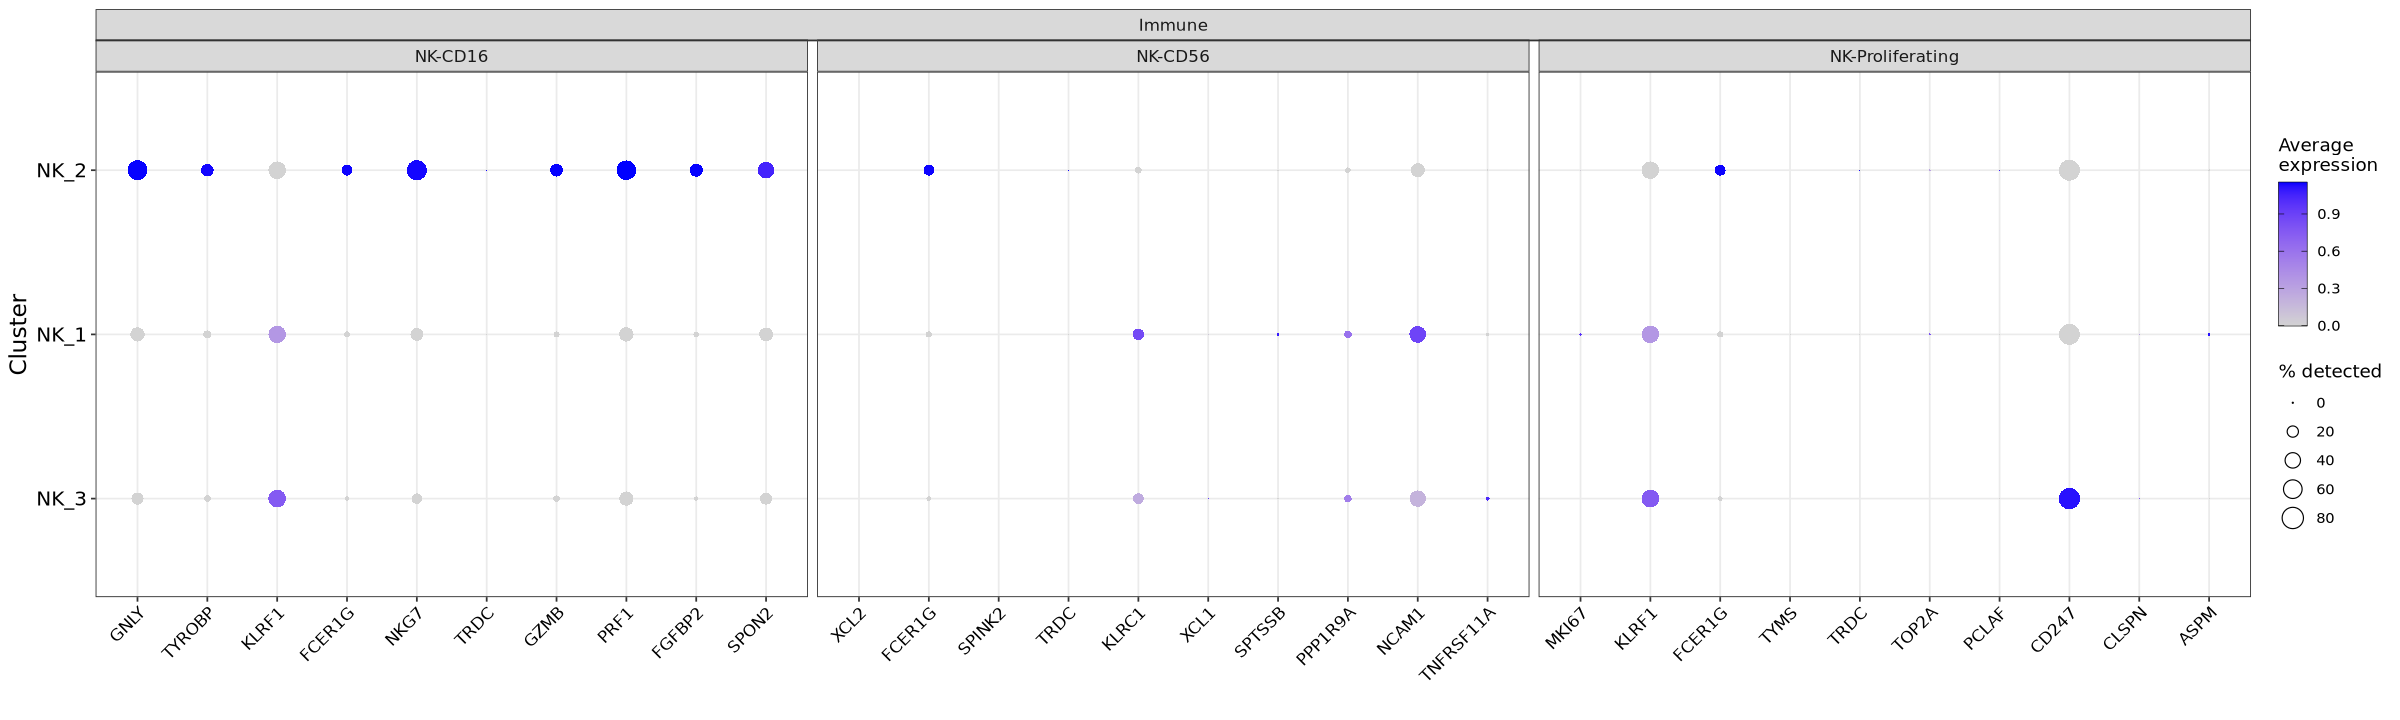

In [66]:
g = DotPlot(adata.use, assay='SCT', group.by = "sub.cluster", features = unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=20, repr.plot.height=6)
    ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")

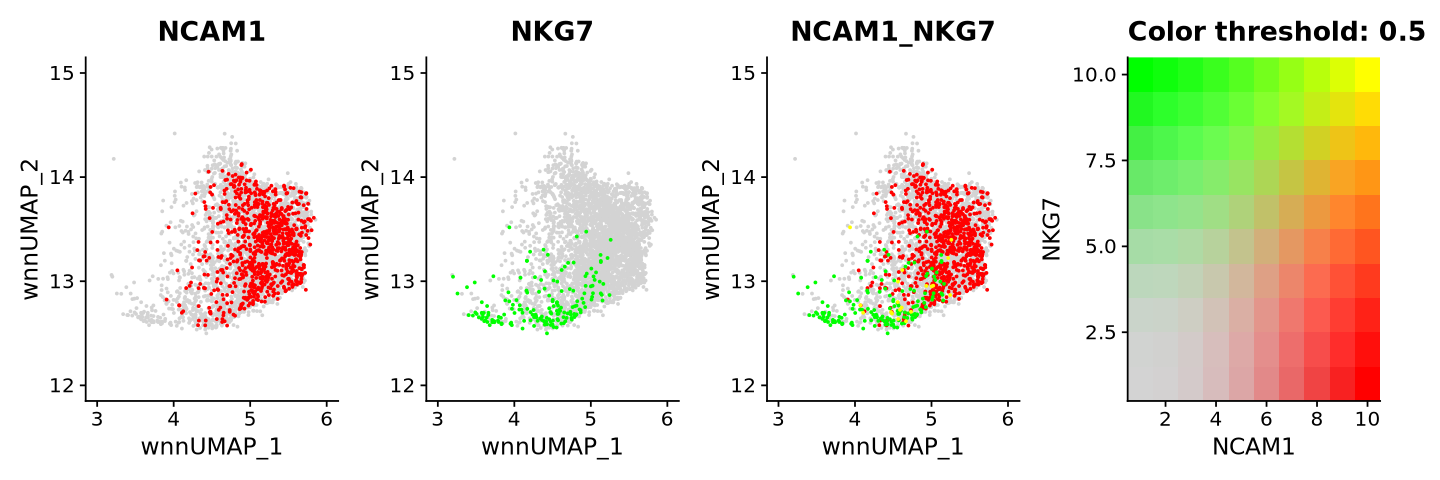

In [67]:
options(repr.plot.width=12, repr.plot.height=4)
DefaultAssay(adata.use) <- 'SCT'
FeaturePlot(adata.use, reduction = "umap.wnn",
            features = c("NCAM1", "NKG7"), blend = TRUE, order = TRUE)

In [68]:
adata.use <- SetIdent(adata.use, value = adata.use$sub.cluster)

# CD16
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata.use, ident = "NK_2"),
                                   celltype = "NK-CD16")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# CD56
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata.use, ident = c("NK_1", "NK_3")),
                                   celltype = "NK-CD56")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

## CM

In [118]:
adata.use = subset(adata, subset=major.celltypes == "CM")
adata.use <- SetIdent(adata.use, value = adata.use$seurat_clusters)

In [119]:
table(as.character(adata.use$seurat_clusters))


   10    12    15    16    19    21    27     4     5 
 9540  9075  6508  5729  2805  2462  1218 33790 25213 

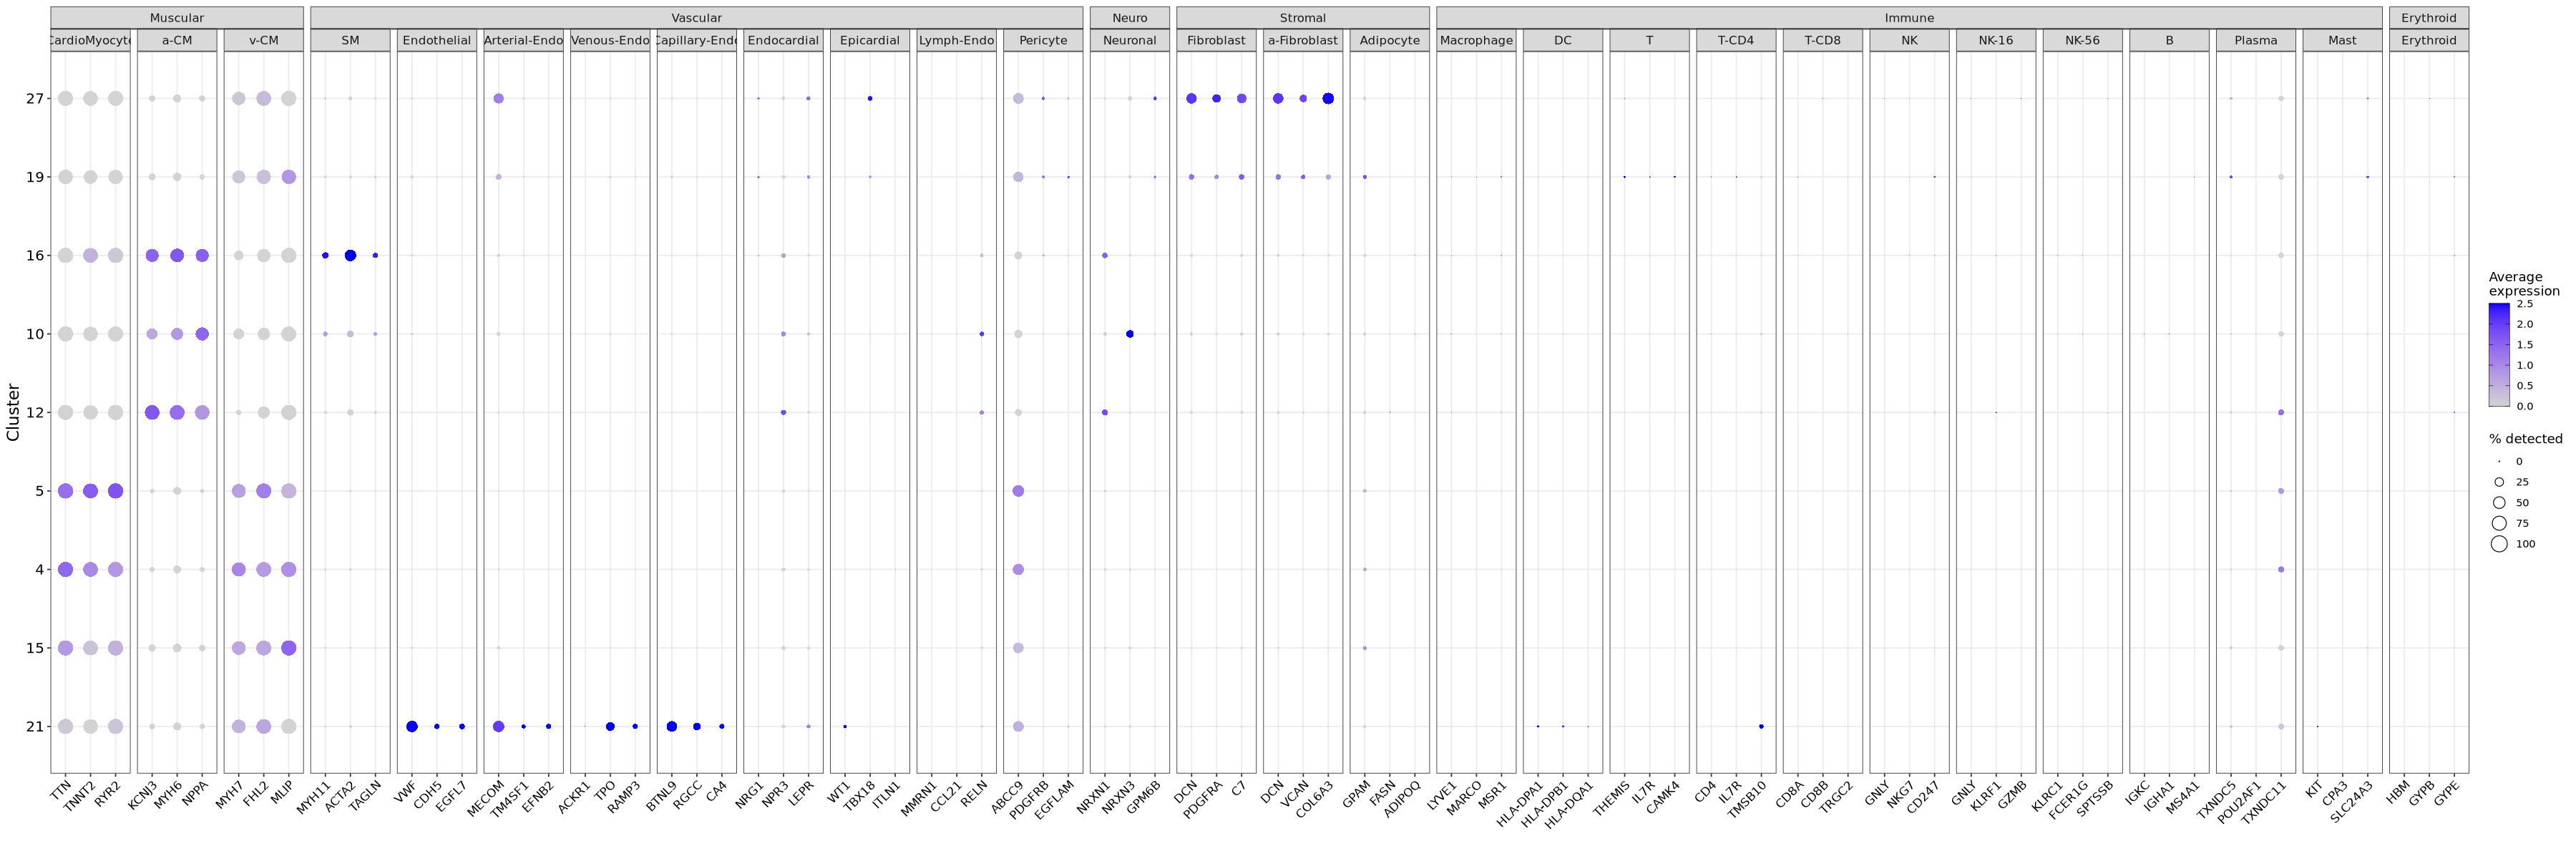

In [121]:
adata.use <- SetIdent(adata.use, value = adata.use$seurat_clusters)
g = DotPlot(adata.use, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=30, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

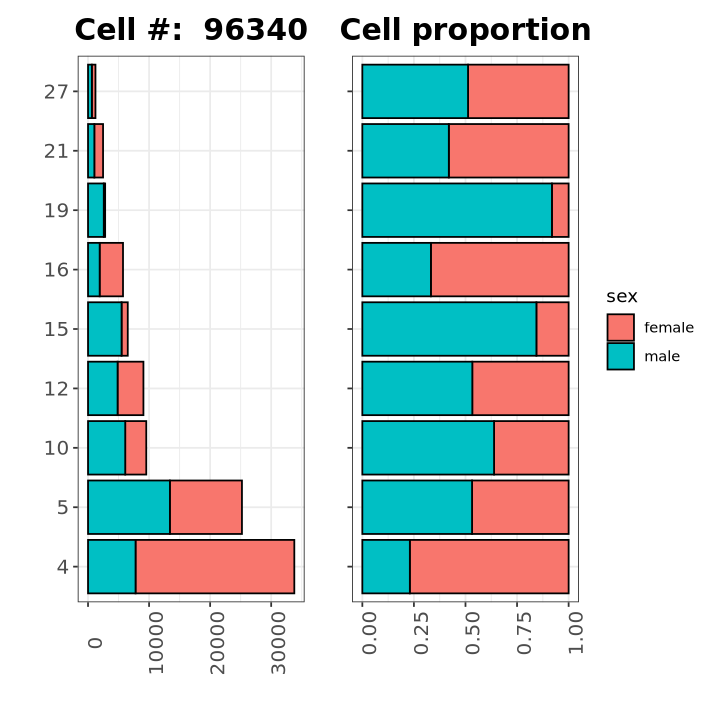

In [71]:
cell.sample = as.data.frame(table(adata.use$seurat_clusters, adata.use$sex))
colnames(cell.sample)[1] = "cluster_celltype"
colnames(cell.sample)[2] = "sex"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = cluster_celltype, y = Freq, fill = sex, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata.use[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= cluster_celltype, y = Freq, fill = sex, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=6, repr.plot.height=6)
gg1 + gg2

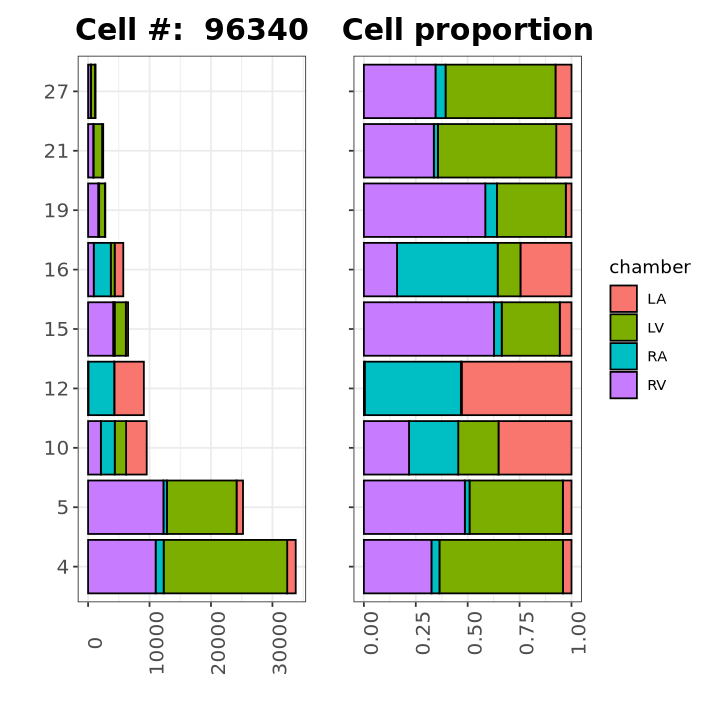

In [72]:
cell.sample = as.data.frame(table(adata.use$seurat_clusters, adata.use$chamber))
colnames(cell.sample)[1] = "cluster_celltype"
colnames(cell.sample)[2] = "chamber"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = cluster_celltype, y = Freq, fill = chamber, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata.use[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= cluster_celltype, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=6, repr.plot.height=6)
gg1 + gg2

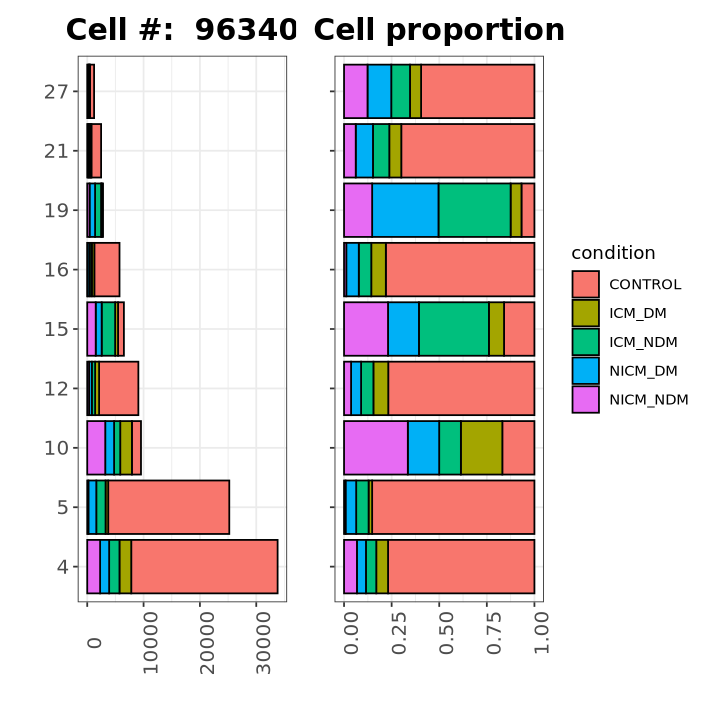

In [73]:
cell.sample = as.data.frame(table(adata.use$seurat_clusters, adata.use$condition))
colnames(cell.sample)[1] = "cluster_celltype"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = cluster_celltype, y = Freq, fill = condition, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata.use[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= cluster_celltype, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=6, repr.plot.height=6)
gg1 + gg2

### Figuring out atrial vs ventricular

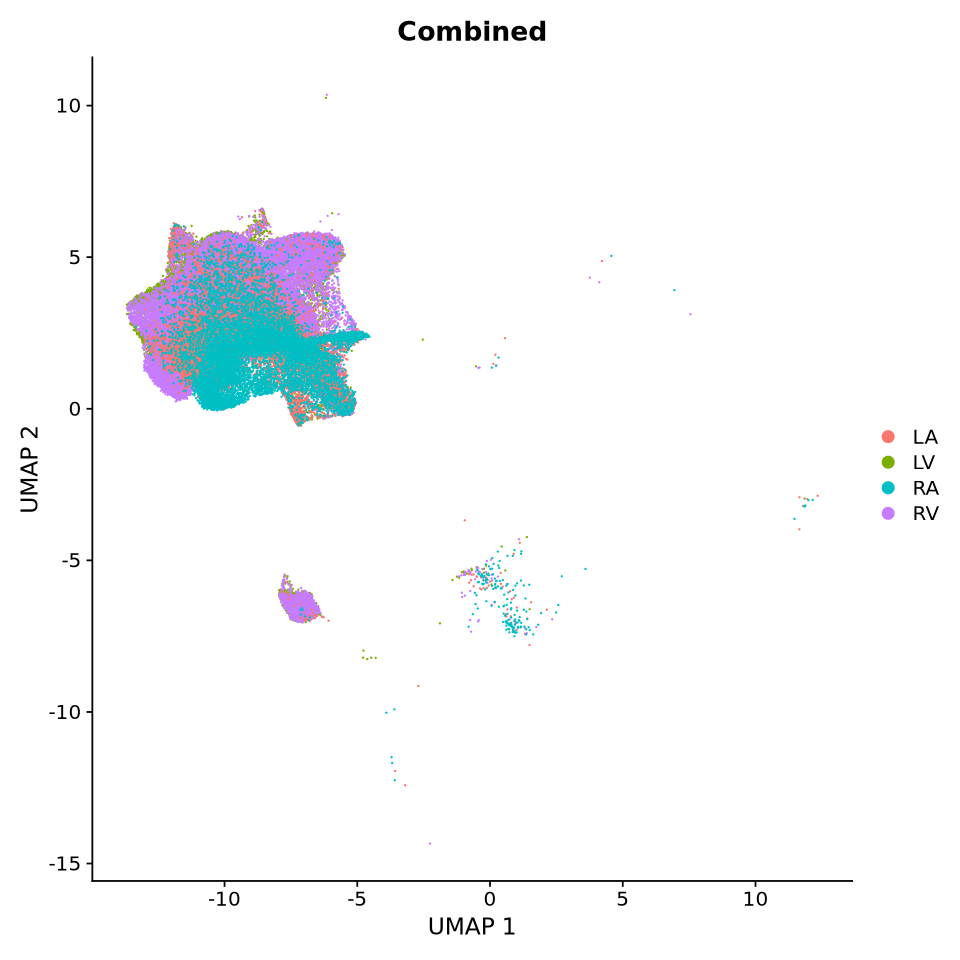

In [74]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata.use, reduction='umap.wnn',group.by = "chamber", label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

In [132]:
colors <- c("#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a")

# Define the markers
vCM_markers <- c("MYL2", "MYH7", "IRX4")
aCM_markers <- c("NR2F2", "KCNA5", "MYH6")

# Create a list of all markers
all_markers <- c(vCM_markers, aCM_markers)

# Subset the Seurat object for the specified markers
seurat_obj_subset <- subset(adata.use, features = all_markers)



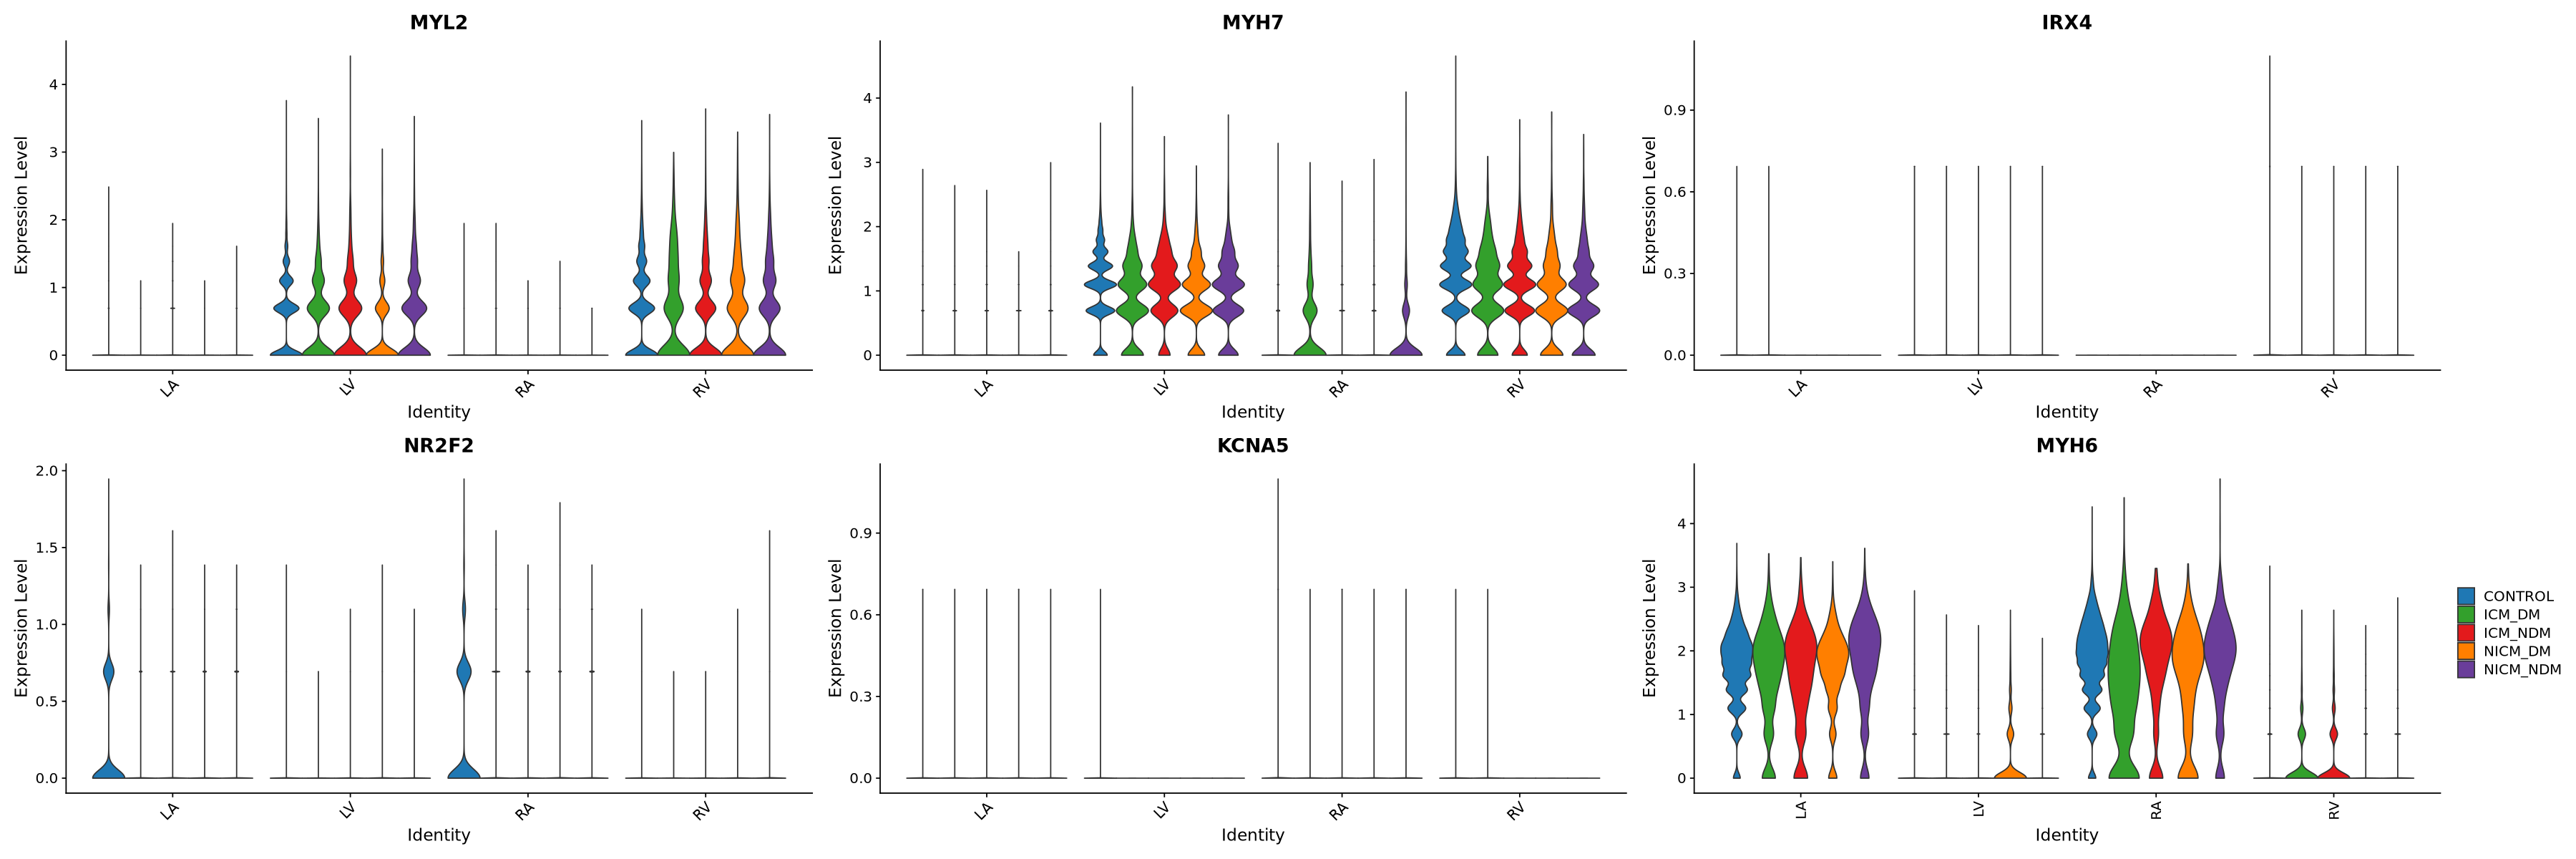

In [138]:
# Violin plot grouped by chamber and split by disease status
VlnPlot(
  object = seurat_obj_subset,
  features = all_markers,
  group.by = "chamber",      
  split.by = "condition", 
  pt.size = 0,               
  combine = TRUE,
  cols = colors
) + 
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
    legend.position = "right"
  )

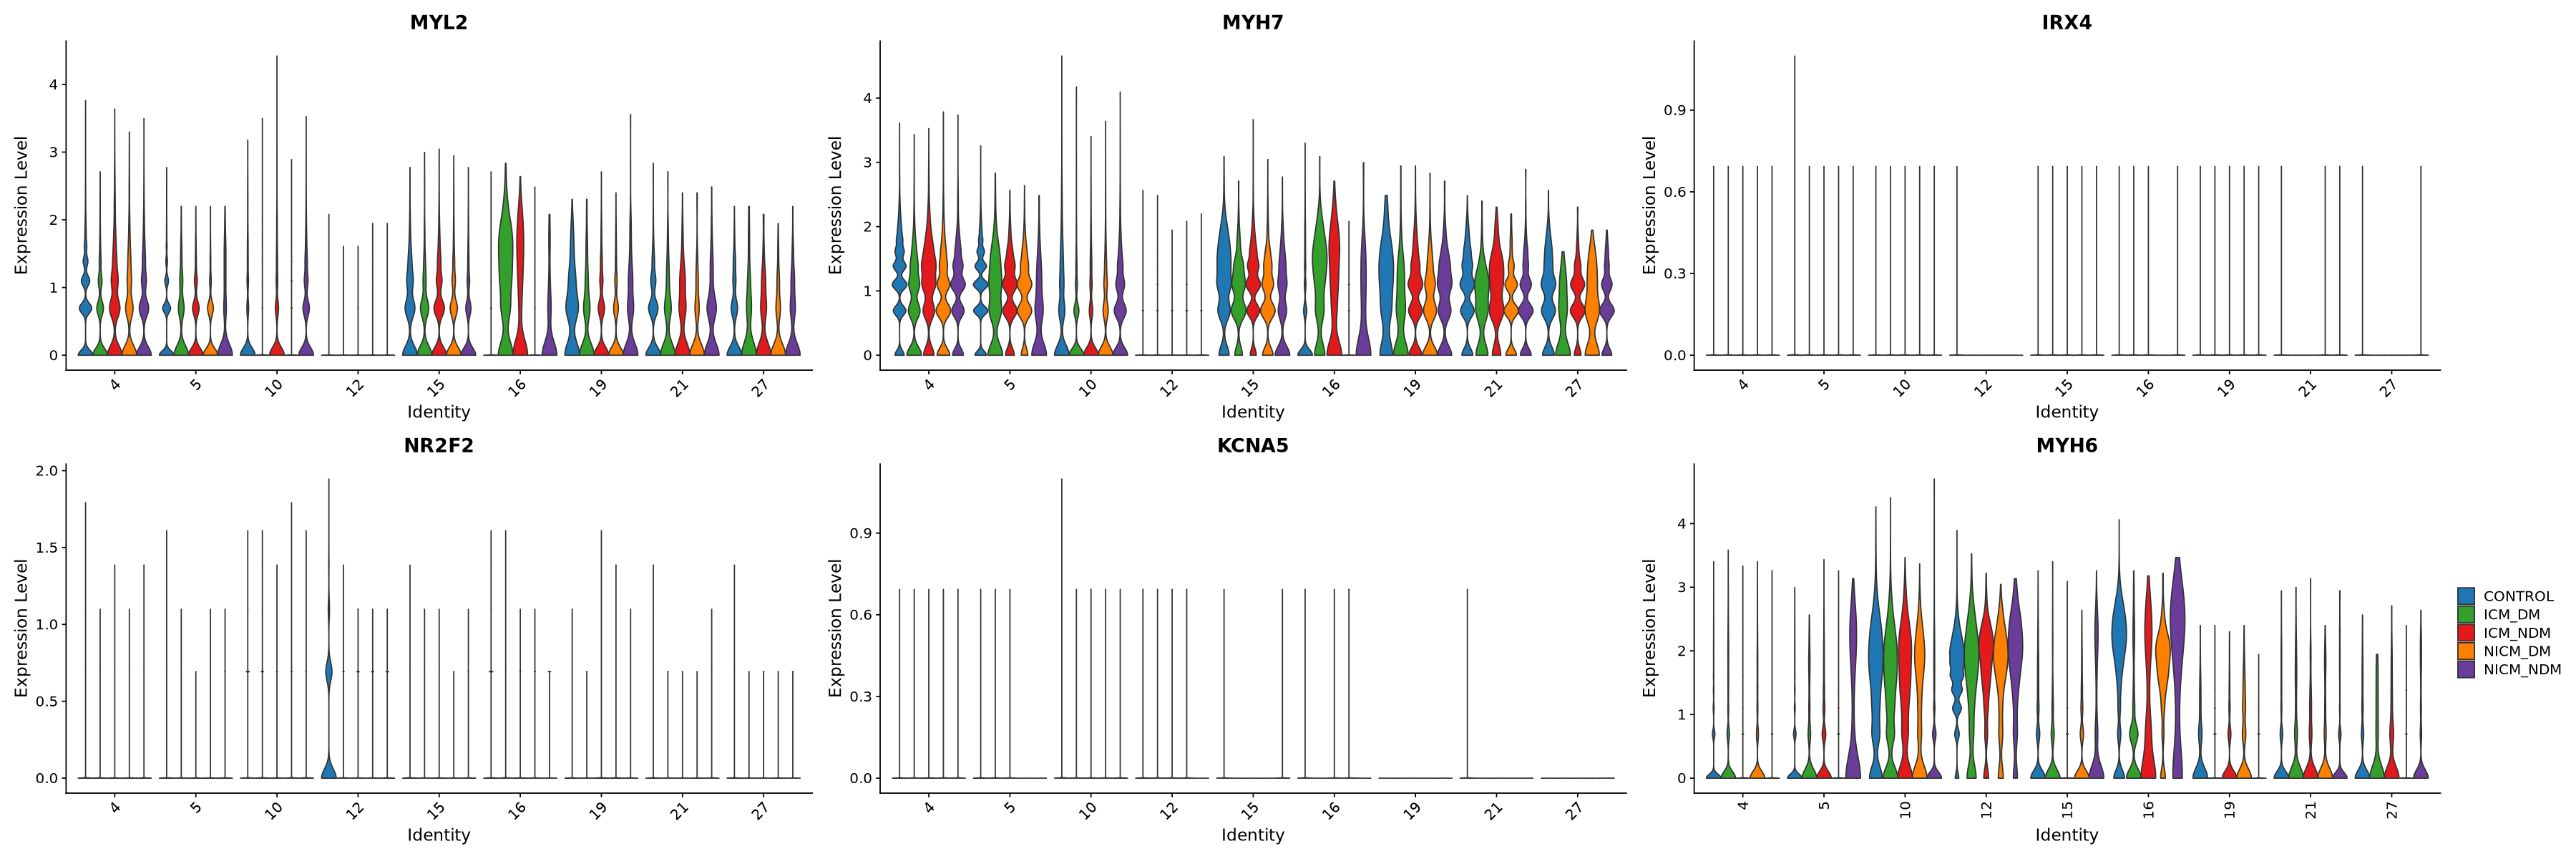

In [137]:
# Violin plot grouped by chamber and split by cluster
VlnPlot(
  object = seurat_obj_subset,
  features = all_markers,
  group.by = "seurat_clusters",      
  split.by = "condition",
  pt.size = 0,             
  combine = TRUE,
  cols = colors
) + 
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
    legend.position = "right"
  )

gather: reorganized (Marker.1, Marker.2, Marker.3, Marker.4, Marker.5, …) into (Key, marker) [was 5x9, now 35x4]


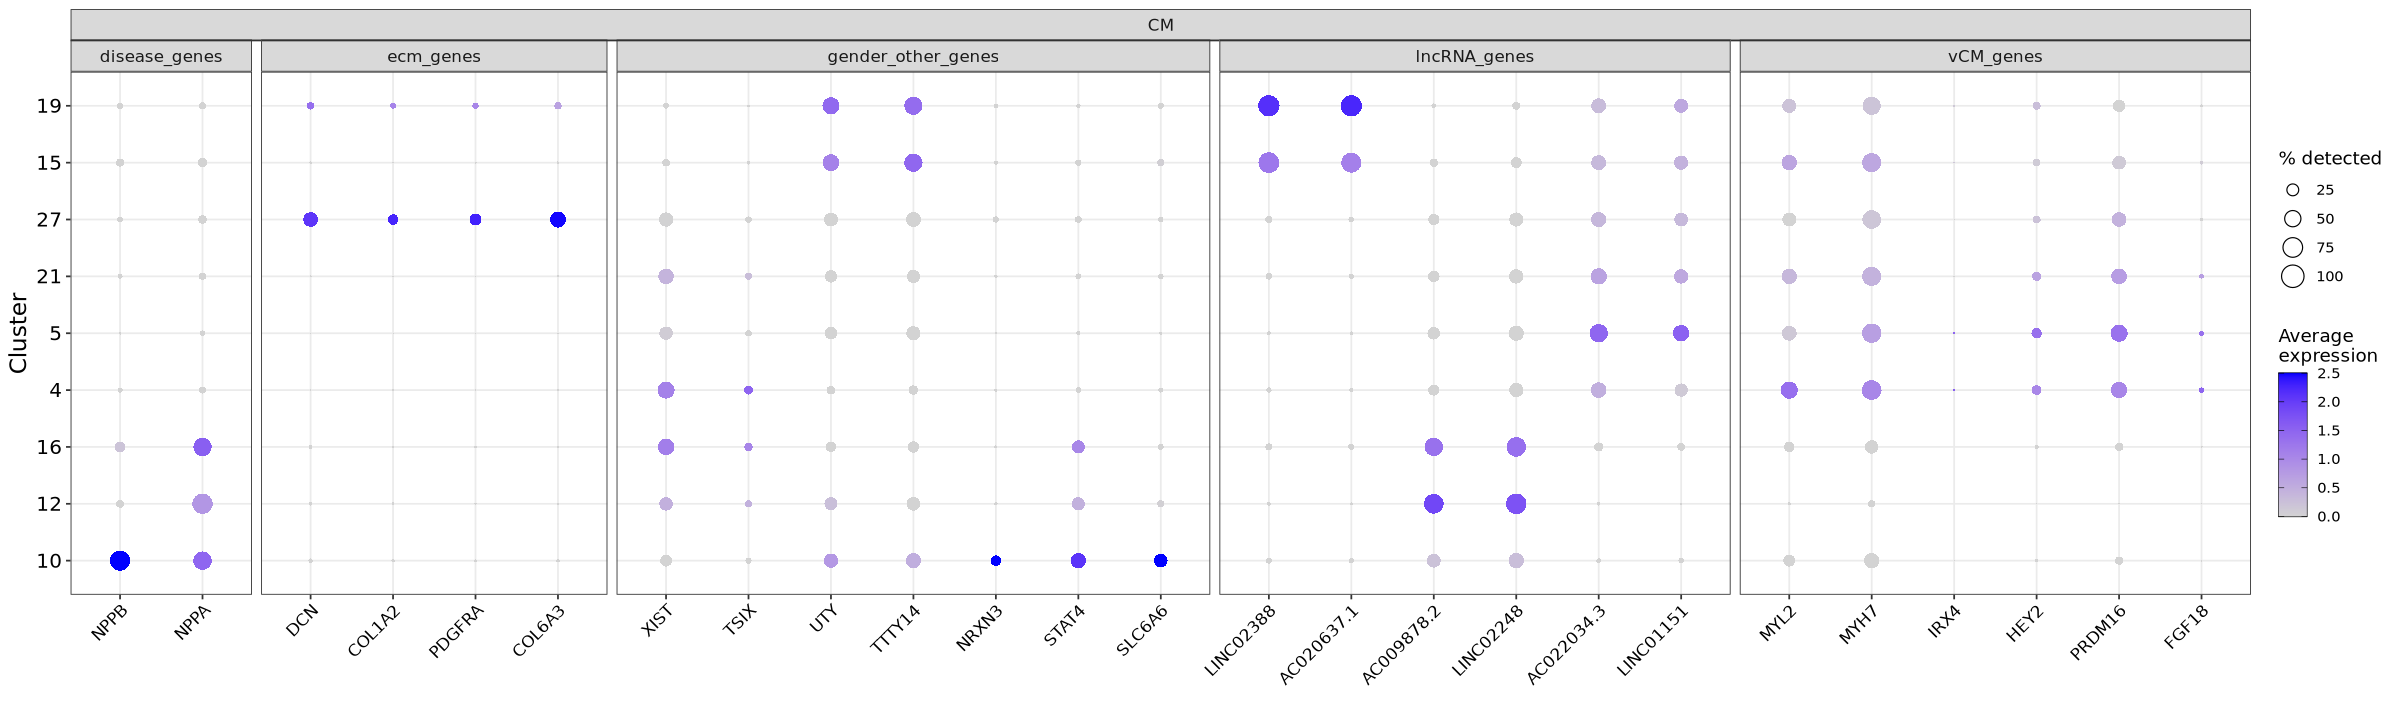

In [142]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "CM_Makers.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]

cell.compartment = cell.markers[,-3]

adata.use <- SetIdent(adata.use, value = adata.use$seurat_clusters)
g = DotPlot(adata.use, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=20, repr.plot.height=6)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [75]:
adata.use.plot = subset(adata.use, subset = chamber %in% c("LA", "RA"))
unique(adata.use.plot$chamber)

[1] "LA" "RA"

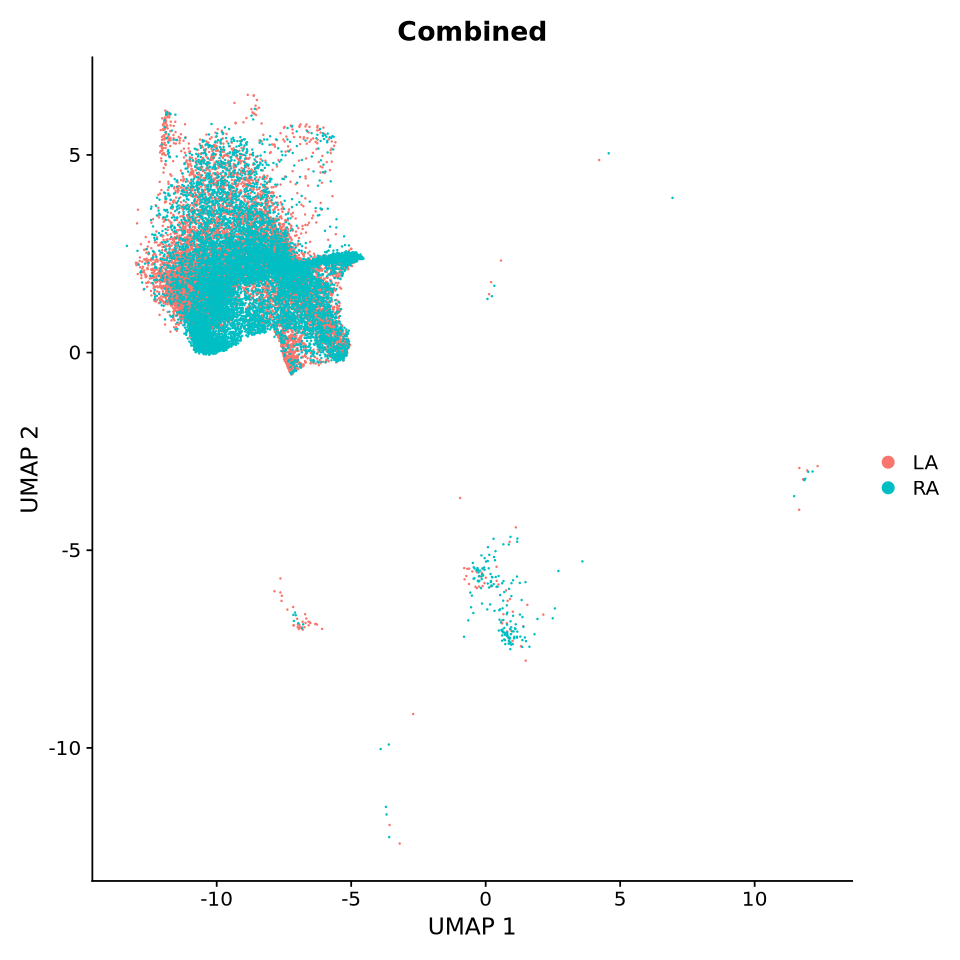

In [76]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata.use.plot, reduction='umap.wnn',group.by = "chamber", label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

In [77]:
adata.use.plot = subset(adata.use, subset = chamber %in% c("LV", "RV"))
unique(adata.use.plot$chamber)

[1] "LV" "RV"

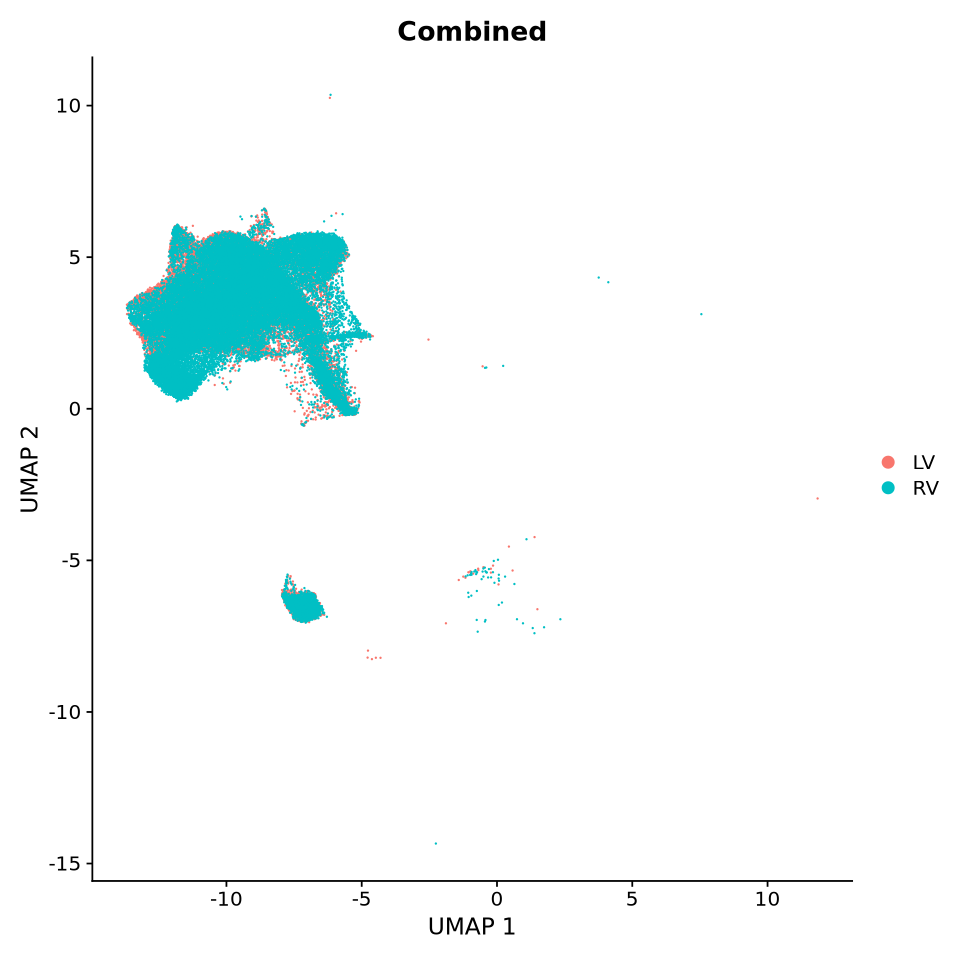

In [78]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata.use.plot, reduction='umap.wnn',group.by = "chamber", label.size=6, repel=TRUE, order = TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

## Fibroblasts

In [79]:
adata.use = subset(adata, subset=major.celltypes == "Fibroblast")
adata.use <- SetIdent(adata.use, value = adata.use$seurat_clusters)

In [80]:
table(as.character(adata.use$seurat_clusters))


    1    20    23    29     9 
53004  2758  2116   522 10105 

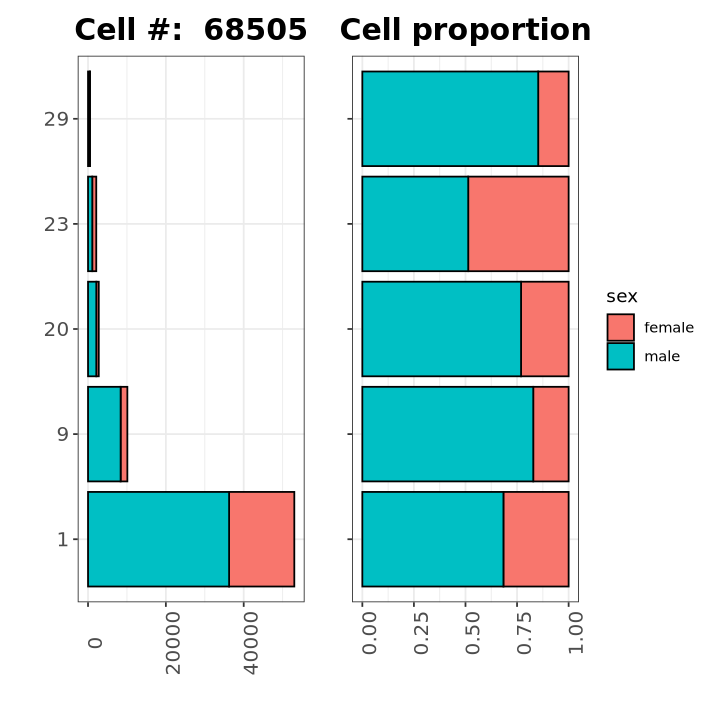

In [81]:
cell.sample = as.data.frame(table(adata.use$seurat_clusters, adata.use$sex))
colnames(cell.sample)[1] = "cluster_celltype"
colnames(cell.sample)[2] = "sex"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = cluster_celltype, y = Freq, fill = sex, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata.use[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= cluster_celltype, y = Freq, fill = sex, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=6, repr.plot.height=6)
gg1 + gg2

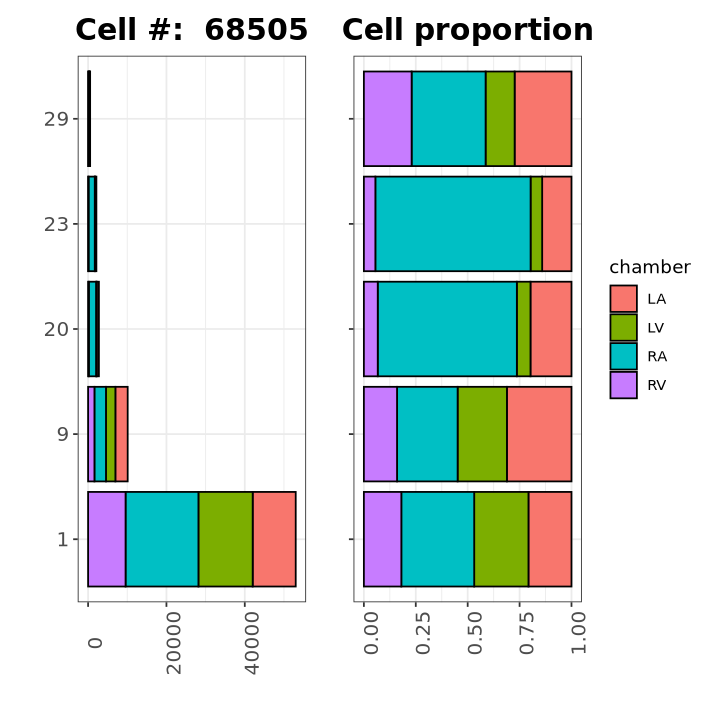

In [82]:
cell.sample = as.data.frame(table(adata.use$seurat_clusters, adata.use$chamber))
colnames(cell.sample)[1] = "cluster_celltype"
colnames(cell.sample)[2] = "chamber"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = cluster_celltype, y = Freq, fill = chamber, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata.use[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= cluster_celltype, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=6, repr.plot.height=6)
gg1 + gg2

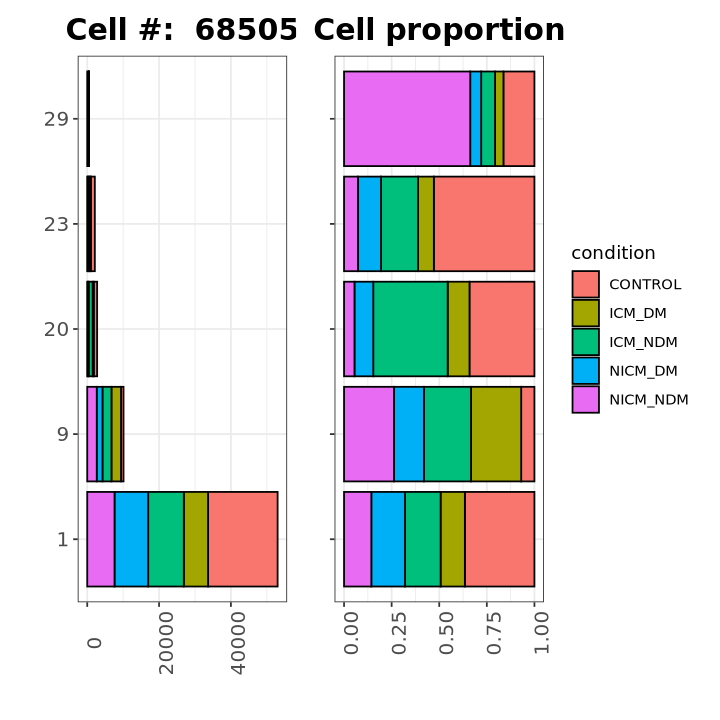

In [83]:
cell.sample = as.data.frame(table(adata.use$seurat_clusters, adata.use$condition))
colnames(cell.sample)[1] = "cluster_celltype"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = cluster_celltype, y = Freq, fill = condition, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata.use[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= cluster_celltype, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=6, repr.plot.height=6)
gg1 + gg2

### Figuring out atrial vs ventricular

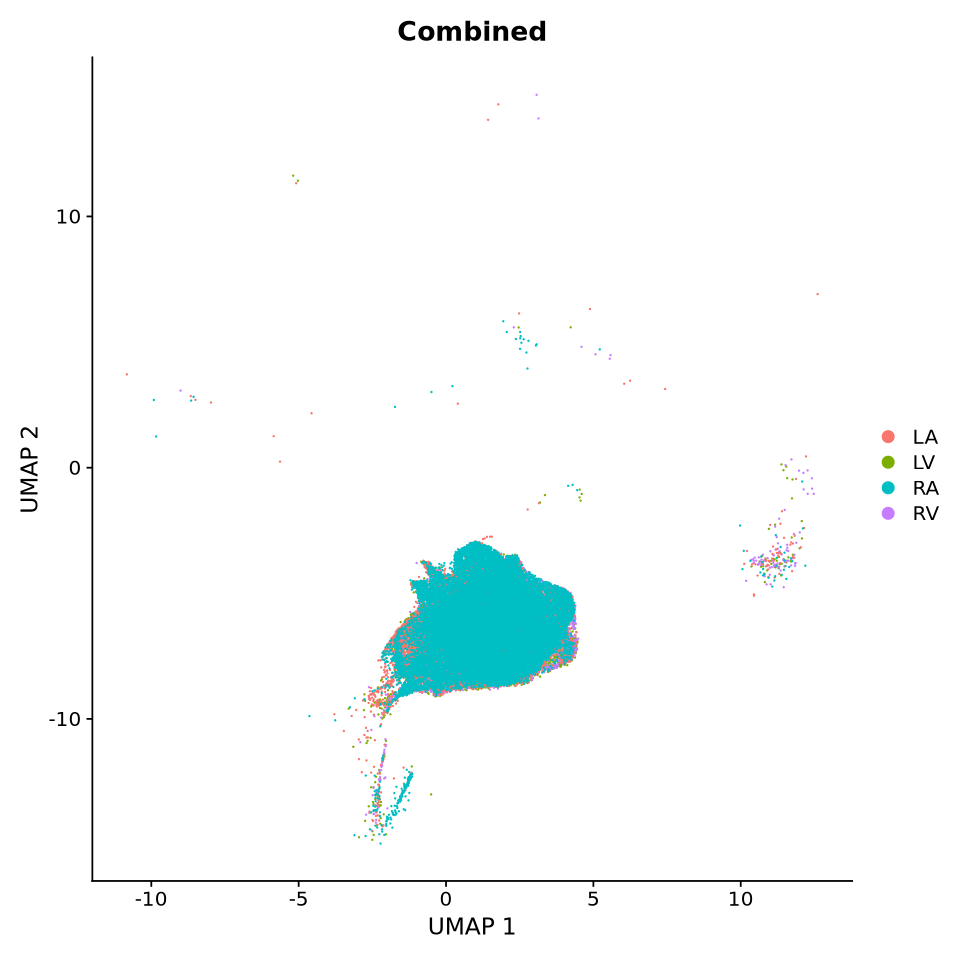

In [84]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata.use, reduction='umap.wnn',group.by = "chamber", label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

In [85]:
adata.use.plot = subset(adata.use, subset = chamber %in% c("LA", "RA"))
unique(adata.use.plot$chamber)

[1] "LA" "RA"

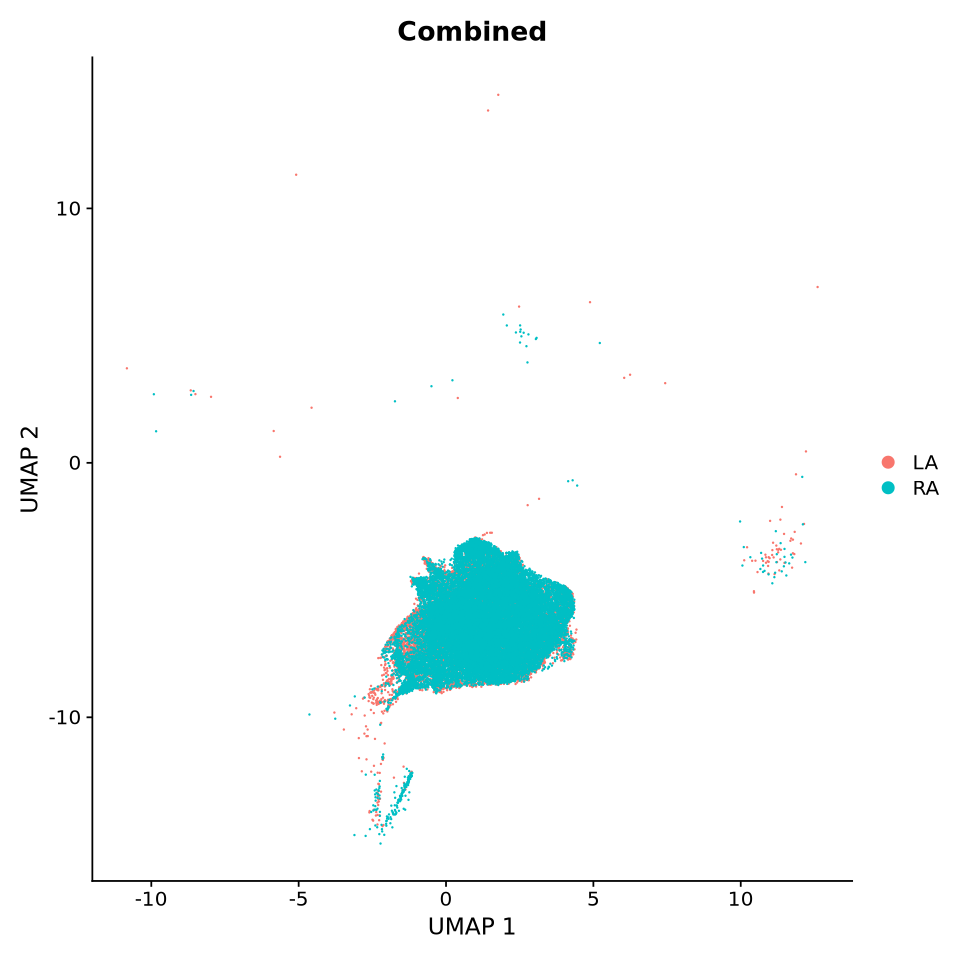

In [86]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata.use.plot, reduction='umap.wnn',group.by = "chamber", label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

In [87]:
adata.use.plot = subset(adata.use, subset = chamber %in% c("LV", "RV"))
unique(adata.use.plot$chamber)

[1] "LV" "RV"

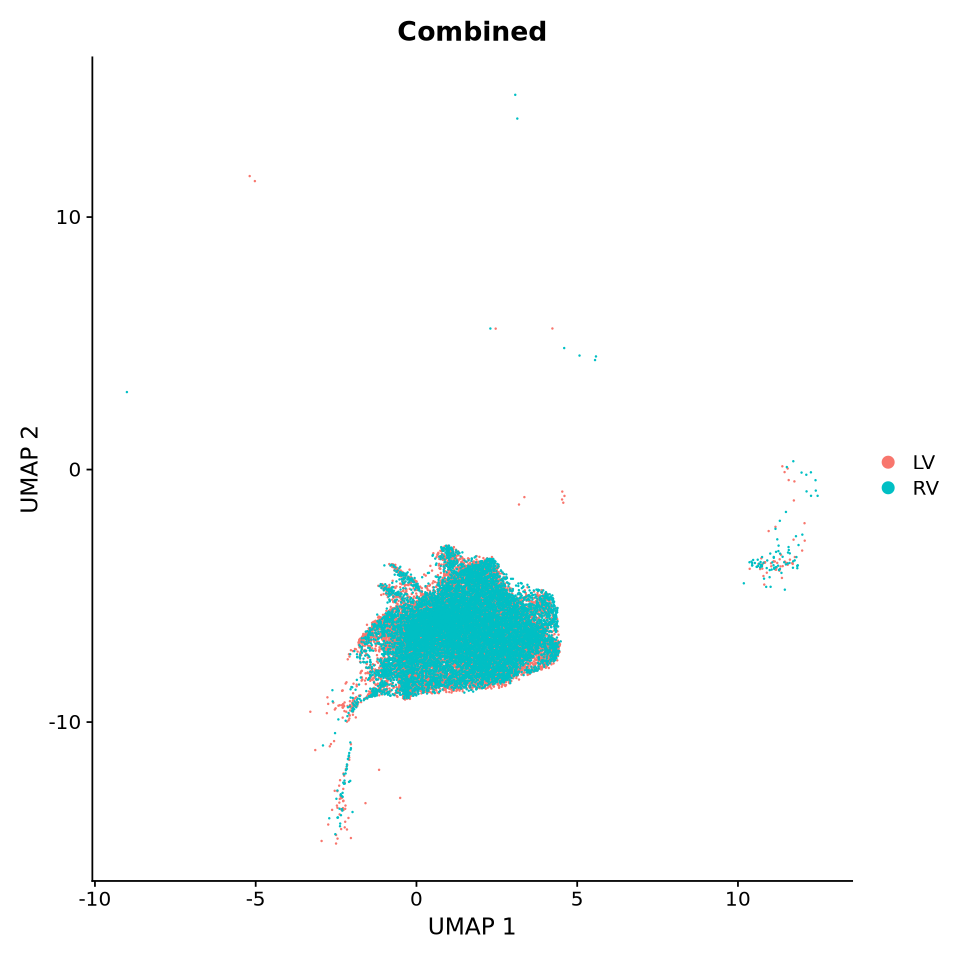

In [88]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata.use.plot, reduction='umap.wnn',group.by = "chamber", label.size=6, repel=TRUE, order = TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

## Finalize

In [96]:
setdiff(unique(adata$major.celltypes), unique(barcodes.celltype$celltype))

[1] "Endothelial" "T"           "NK"          "Erythroid"

In [95]:
adata <- SetIdent(adata, value = adata$major.celltypes)

# Mast
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Mast"),
                                   celltype = "Mast")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Macrophage
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Macrophage"),
                                   celltype = "Macrophage")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# DC
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "DC"),
                                   celltype = "DC")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# CM
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "CM"),
                                   celltype = "CM")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Fibroblast
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Fibroblast"),
                                   celltype = "Fibroblast")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Pericyte
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Pericyte"),
                                   celltype = "Pericyte")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# SM
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "SM"),
                                   celltype = "SM")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Endocardial
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Endocardial"),
                                   celltype = "Endocardial")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Neuronal
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Neuronal"),
                                   celltype = "Neuronal")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Lymph-Endo
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Lymph-Endo"),
                                   celltype = "Lymph-Endo")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Epicardial
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Epicardial"),
                                   celltype = "Epicardial")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

# Adipocyte
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Adipocyte"),
                                   celltype = "Adipocyte")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

In [103]:
# Mast
barcodes.celltype.tmp = data.frame(barcode = WhichCells(adata, ident = "Erythroid"),
                                   celltype = "Erythroid")
barcodes.celltype = rbind(barcodes.celltype, barcodes.celltype.tmp)

In [104]:
# Check that everything is there

In [105]:
adata

An object of class Seurat 
528053 features across 337206 samples within 5 assays 
Active assay: SCT (33901 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 4 other assays present: RNA, RNA_raw, ATAC_windows, ATAC
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [106]:
nrow(barcodes.celltype)

[1] 337206

In [107]:
unique(adata$major.celltypes)
unique(barcodes.celltype$celltype)

[1] "Fibroblast"  "Endothelial" "CM"          "Macrophage"  "Pericyte"   
 [6] "Mast"        "Endocardial" "T"           "Adipocyte"   "SM"         
[11] "DC"          "B"           "Neuronal"    "NK"          "Lymph-Endo" 
[16] "Epicardial"  "Erythroid"

[1] "Art-Endo"    "Cap-Endo"    "Ven-Endo"    "B"           "Plasma"     
 [6] "T-CD4"       "T-CD8"       "NK-CD16"     "NK-CD56"     "Mast"       
[11] "Macrophage"  "DC"          "CM"          "Fibroblast"  "Pericyte"   
[16] "SM"          "Endocardial" "Neuronal"    "Lymph-Endo"  "Epicardial" 
[21] "Adipocyte"   "Erythroid"

In [108]:
missing.barcodes = setdiff(names(Idents(adata)), barcodes.celltype$barcode)
length(missing.barcodes)

[1] 0

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, reduction='umap.wnn', cells =  missing.barcodes, label.size=6, repel=TRUE, order = TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

In [110]:
# Add a column metadata
adata@meta.data$celltypes <- barcodes.celltype$celltype[match(rownames(adata@meta.data), barcodes.celltype$barcode)]

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



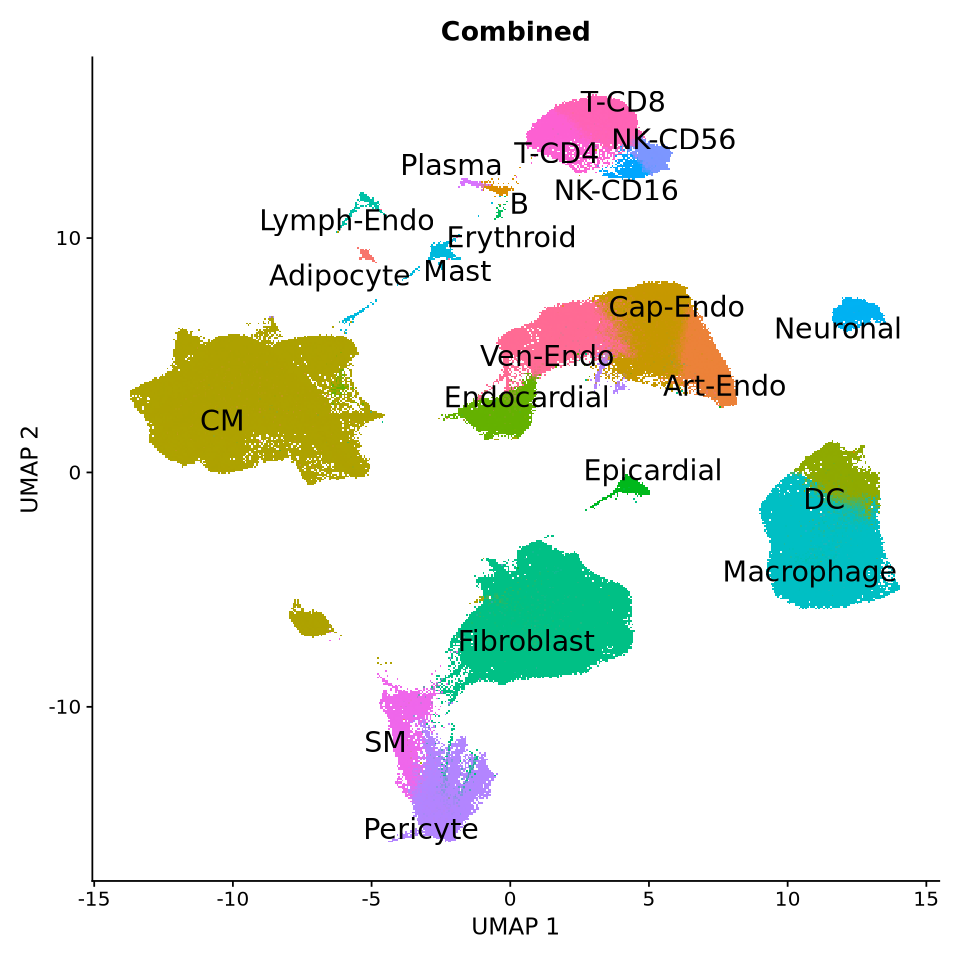

In [111]:
# Visualize clusters
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, group.by = "celltypes", reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

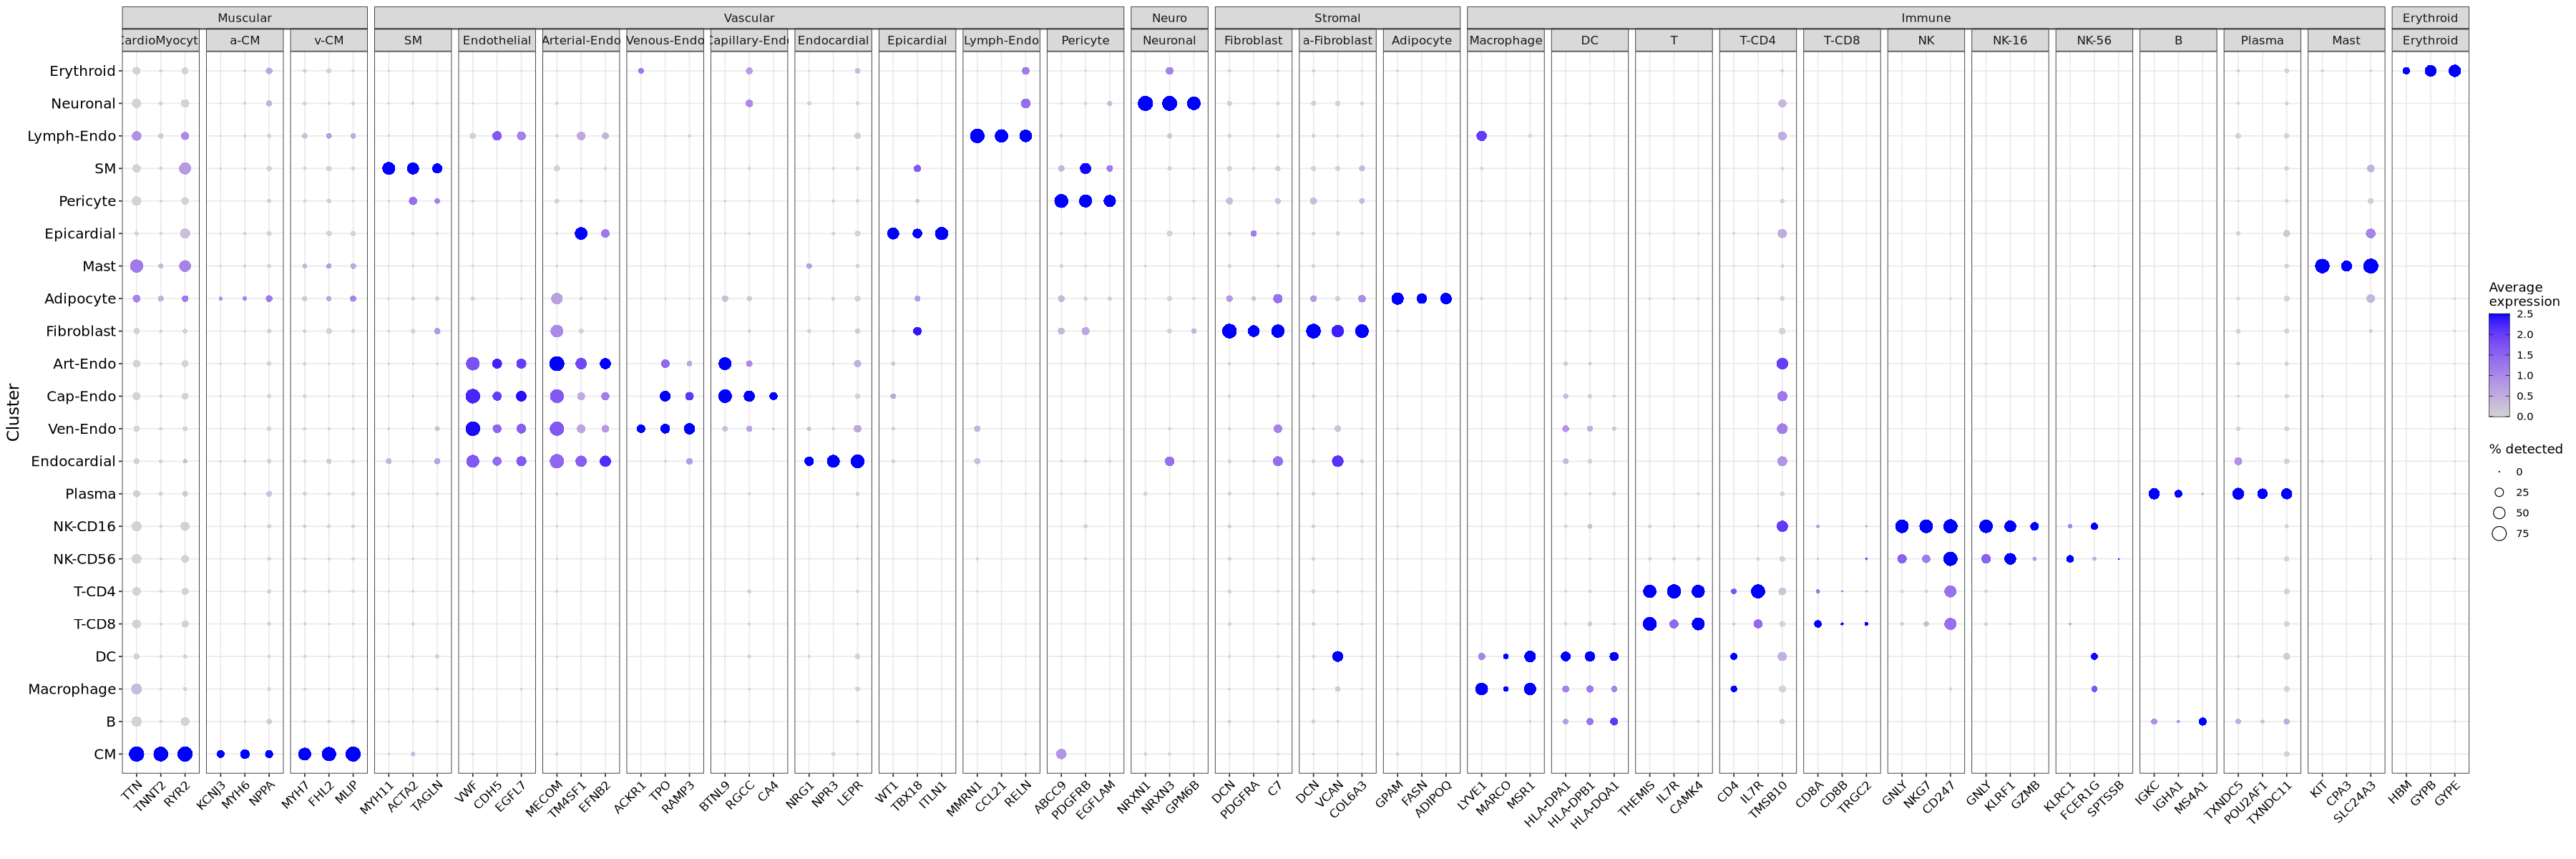

In [116]:
adata <- SetIdent(adata, value = adata$celltypes)
g = DotPlot(adata, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=30, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [164]:
cell.order <- c(
  'CM',      
  'SM',      
  'Cap-Endo',
  'Ven-Endo',
  'Art-Endo',
  'Endothelial',      
  'Endocardial',      
  'Epicardial',       
  'Lymph-Endo',       
  'Pericyte',
  'Fibroblast',       
  'Adipocyte',        
  'Neuronal',
  'Macrophage',       
  'DC',      
  'Mast',    
  'T-CD8',   
  'T-CD4',   
  'NK-CD56', 
  'NK-CD16', 
  'B',       
  'Plasma',  
  'Erythroid'
)

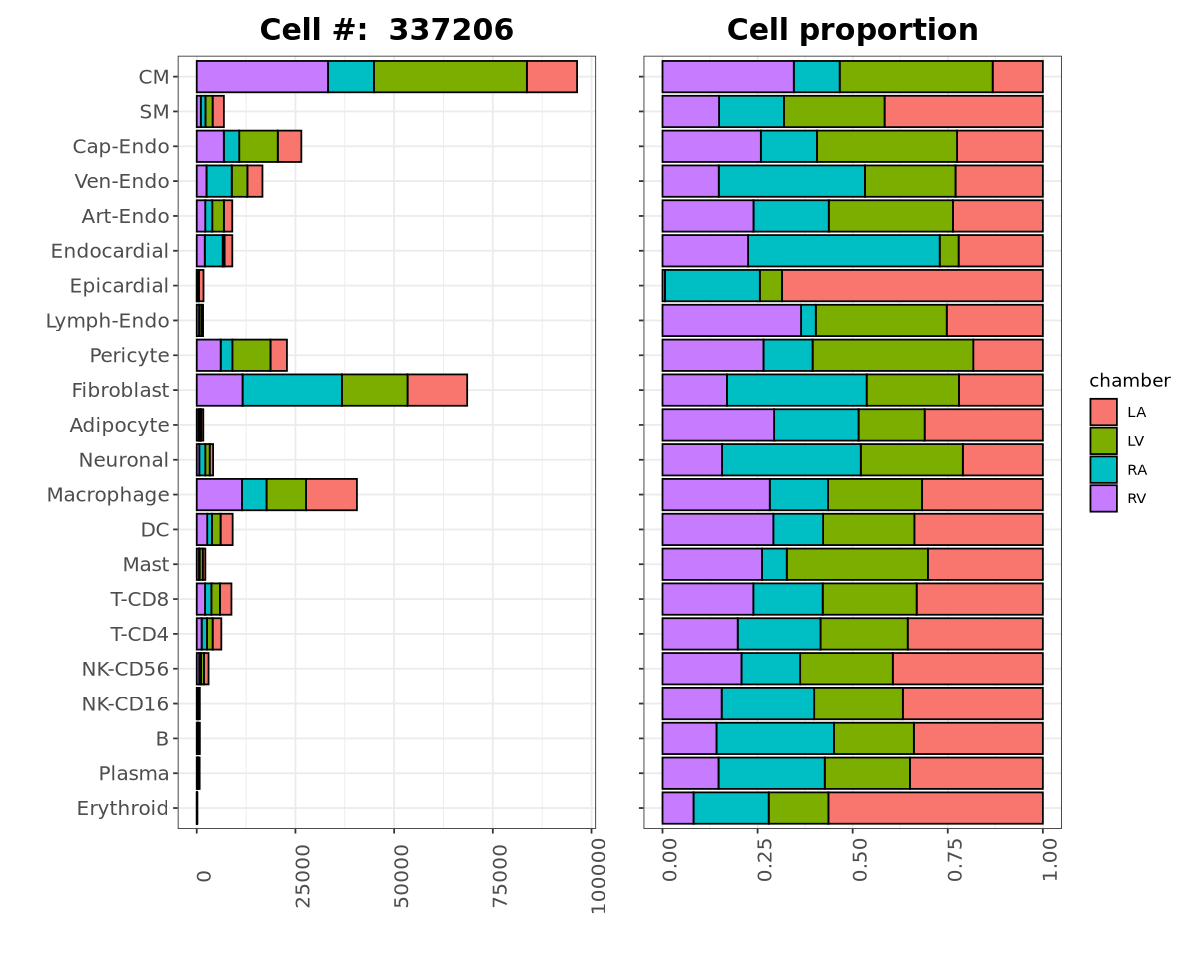

In [165]:
cell.sample = as.data.frame(table(adata$celltypes, adata$chamber))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "chamber"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$celltypes = factor(cell.sample$celltypes, levels = rev(cell.order))

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = celltypes, y = Freq, fill = chamber, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=10, repr.plot.height=8)
gg1 + gg2

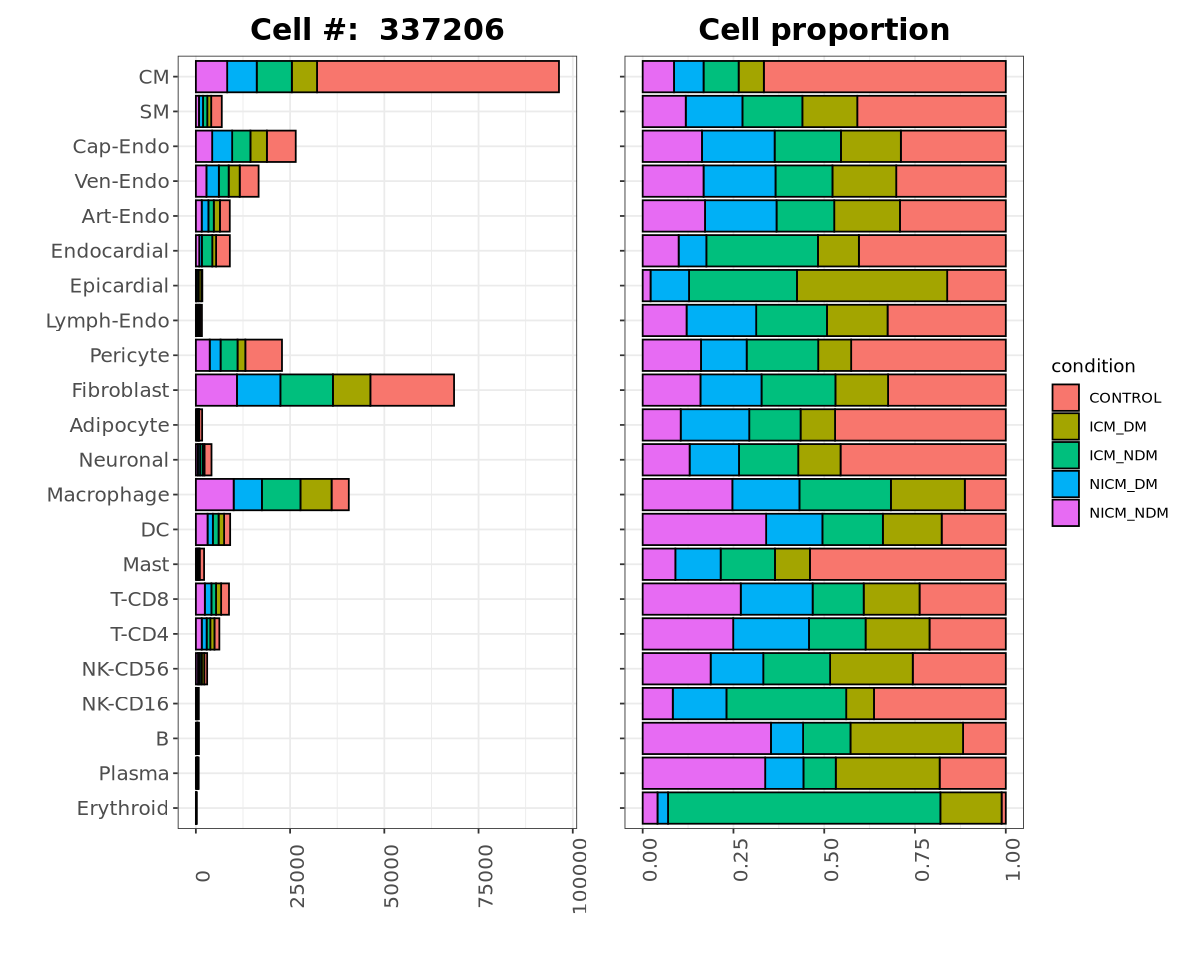

In [166]:
cell.sample = as.data.frame(table(adata$celltypes, adata$condition))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$celltypes = factor(cell.sample$celltypes, levels = rev(cell.order))

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = celltypes, y = Freq, fill = condition, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=10, repr.plot.height=8)
gg1 + gg2

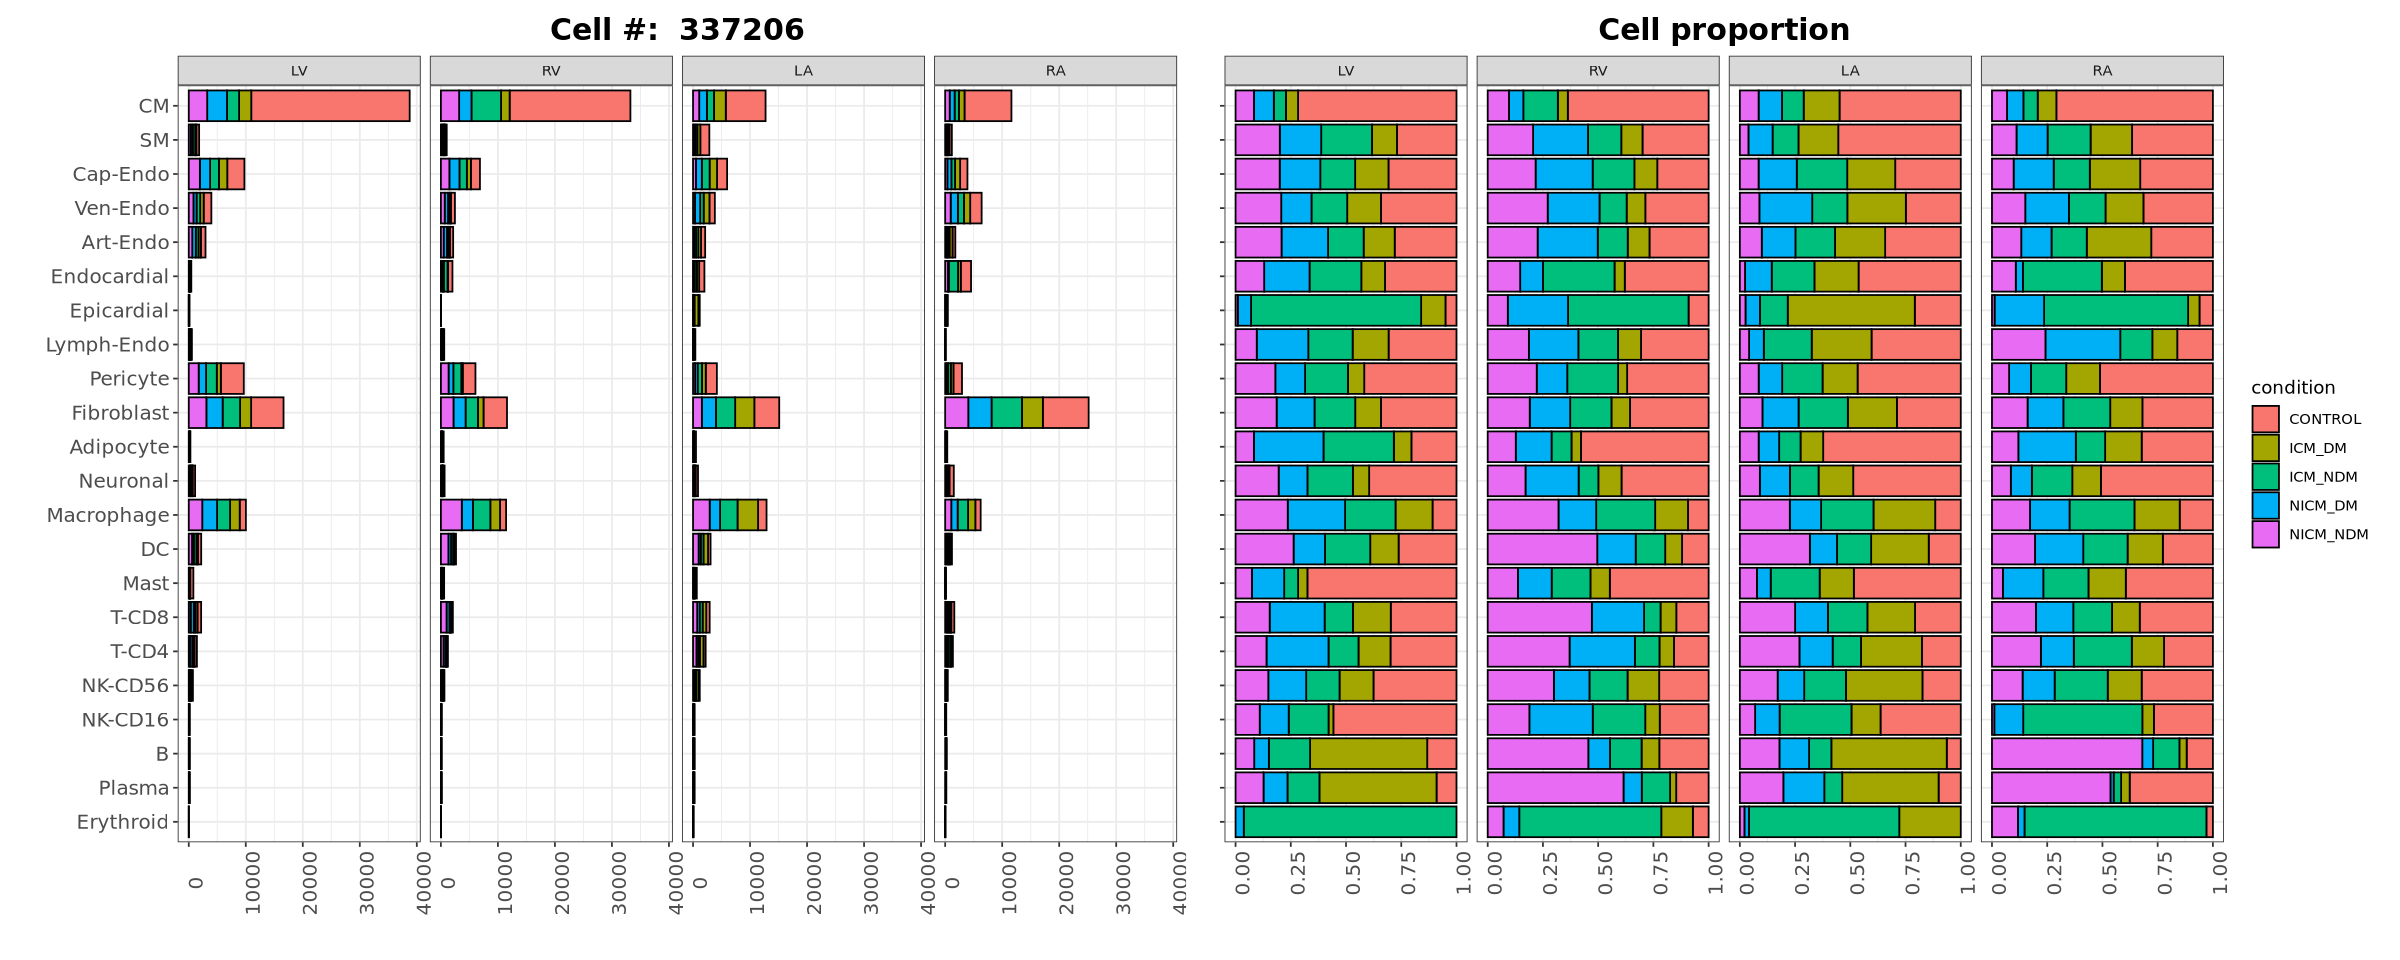

In [167]:
cell.sample = as.data.frame(table(adata$celltypes, adata$chamber, adata$condition))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "chamber"
colnames(cell.sample)[3] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$celltypes = factor(cell.sample$celltypes, levels = rev(cell.order))
cell.sample$chamber = factor(cell.sample$chamber, levels = c("LV", "RV", "LA", "RA"))

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = celltypes, y = Freq, fill = condition, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip() +
  facet_nested(cols = vars(chamber), scales = "fixed", space = "free")


gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip() +
  facet_nested(cols = vars(chamber), scales = "free", space = "free")

options(repr.plot.width=20, repr.plot.height=8)
gg1 + gg2

In [112]:
### Write  RDS
log_print("Saving RDS")
file = paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds", sep = "")
saveRDS(adata, file = file)
log_print("RDS - Saved")

[1] "Saving RDS"
[1] "RDS - Saved"


# Disease specific sub-types

In [171]:
# Create a combined metadata column to summarize clusters and celltypes
adata$cluster_celltype = paste0(adata$celltypes, "--", adata$seurat_clusters)

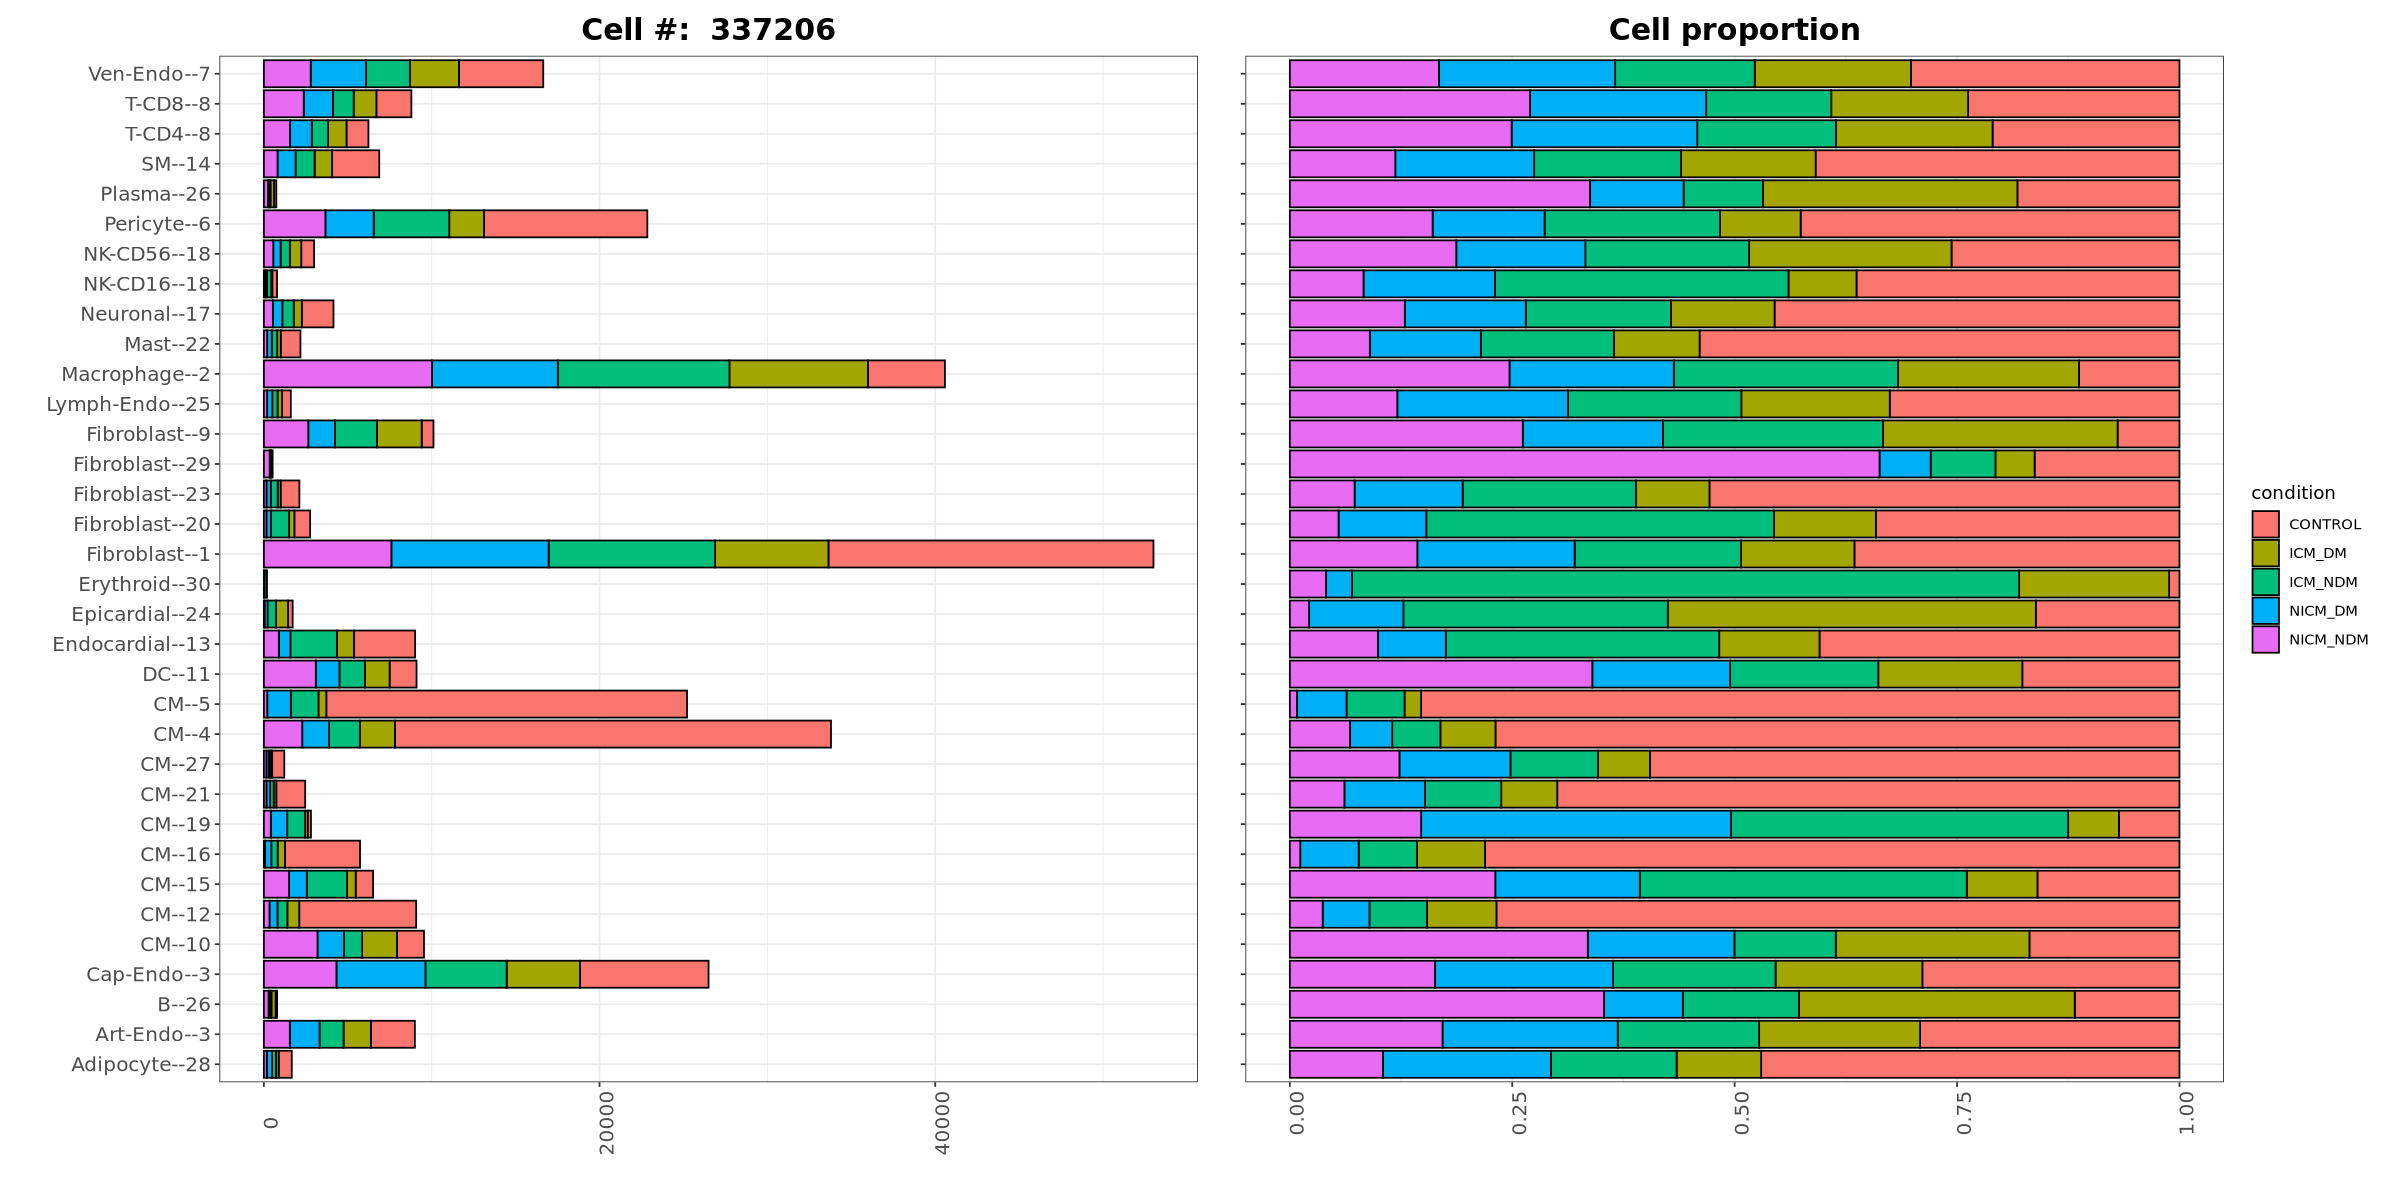

In [180]:
cell.sample = as.data.frame(table(adata$cluster_celltype, adata$condition))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

width = 0.8
gg1 <- ggplot(cell.sample, aes(x = celltypes, y = Freq, fill = condition, label = Freq)) + 
  theme_bw() +
  labs(y = "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
  geom_bar(stat = 'identity', color = 'black', size = 0.5) +
  theme(
    axis.text = element_text(size = 12), 
    axis.title = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 90),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5), 
    legend.position = "none"  
  ) +
  coord_flip()


gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

options(repr.plot.width=20, repr.plot.height=10)
gg1 + gg2

In [181]:
adata$cell.sub_disease_types = adata$celltypes

In [190]:
# Check current values
table(adata$seurat_clusters)


    1     2     3     4     5     6     7     8     9    10    11    12    13 
53004 40577 35492 33790 25213 22848 16646 15019 10105  9540  9097  9075  9013 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
 6875  6508  5729  4148  3778  2805  2758  2462  2180  2116  1716  1606  1531 
   27    28    29    30 
 1218  1663   522   172 

In [191]:
# Rename values in adata$cell.sub_disease_types where adata$seurat_clusters is "9"
adata$cell.sub_disease_types[adata$seurat_clusters == "9"] <- "Fibroblast_HF"
adata$cell.sub_disease_types[adata$seurat_clusters == "19"] <- "CM_HF_1"
adata$cell.sub_disease_types[adata$seurat_clusters == "15"] <- "CM_HF_2"
adata$cell.sub_disease_types[adata$seurat_clusters == "10"] <- "CM_HF_3"

In [192]:
# Check current values
table(adata$cell.sub_disease_types)


    Adipocyte      Art-Endo             B      Cap-Endo            CM 
         1663          8997           790         26495         77487 
      CM_HF_1       CM_HF_2       CM_HF_3            DC   Endocardial 
         2805          6508          9540          9097          9013 
   Epicardial     Erythroid    Fibroblast Fibroblast_HF    Lymph-Endo 
         1716           172         58400         10105          1606 
   Macrophage          Mast      Neuronal       NK-CD16       NK-CD56 
        40577          2180          4148           785          2993 
     Pericyte        Plasma            SM         T-CD4         T-CD8 
        22848           741          6875          6230          8789 
     Ven-Endo 
        16646 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



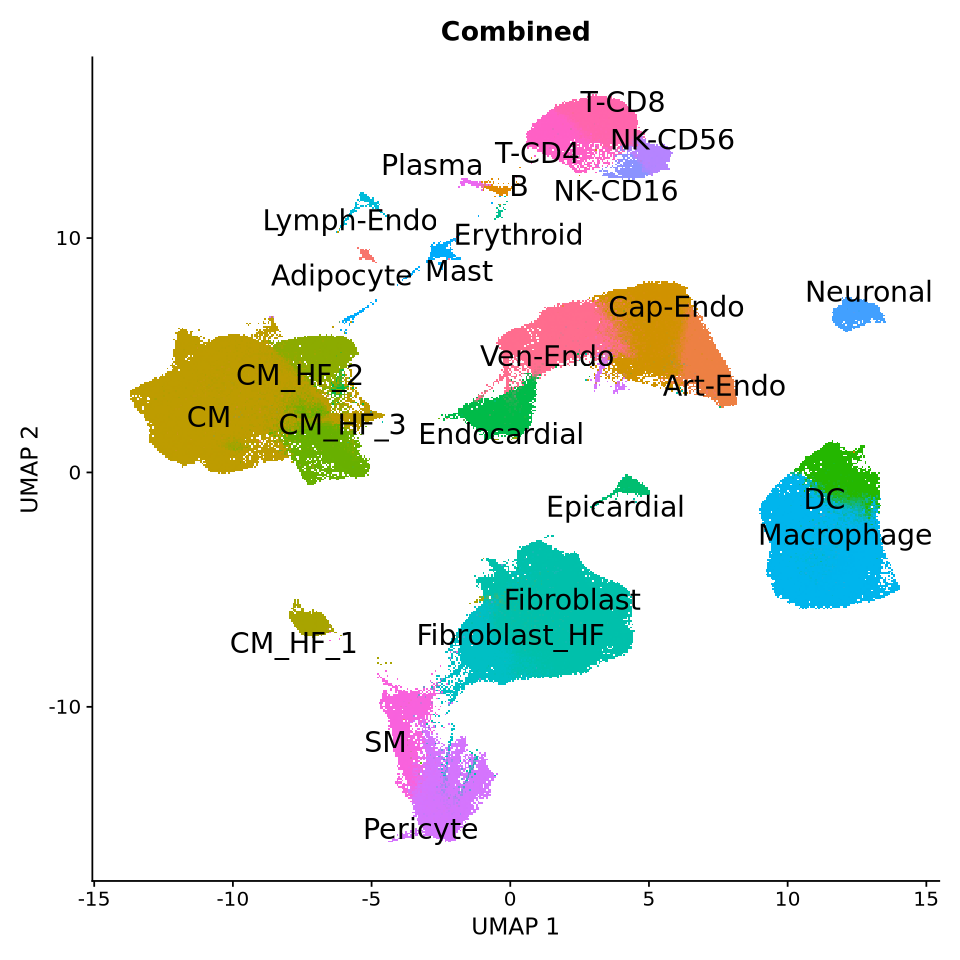

In [193]:
# Visualize clusters
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, group.by = "cell.sub_disease_types", reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

# Finalize metadata

In [195]:
adata$cell.major_types = adata$major.celltypes
adata$cell.sub_types = adata$celltypes
adata$cell.sub_types_disease = adata$cell.sub_disease_types

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



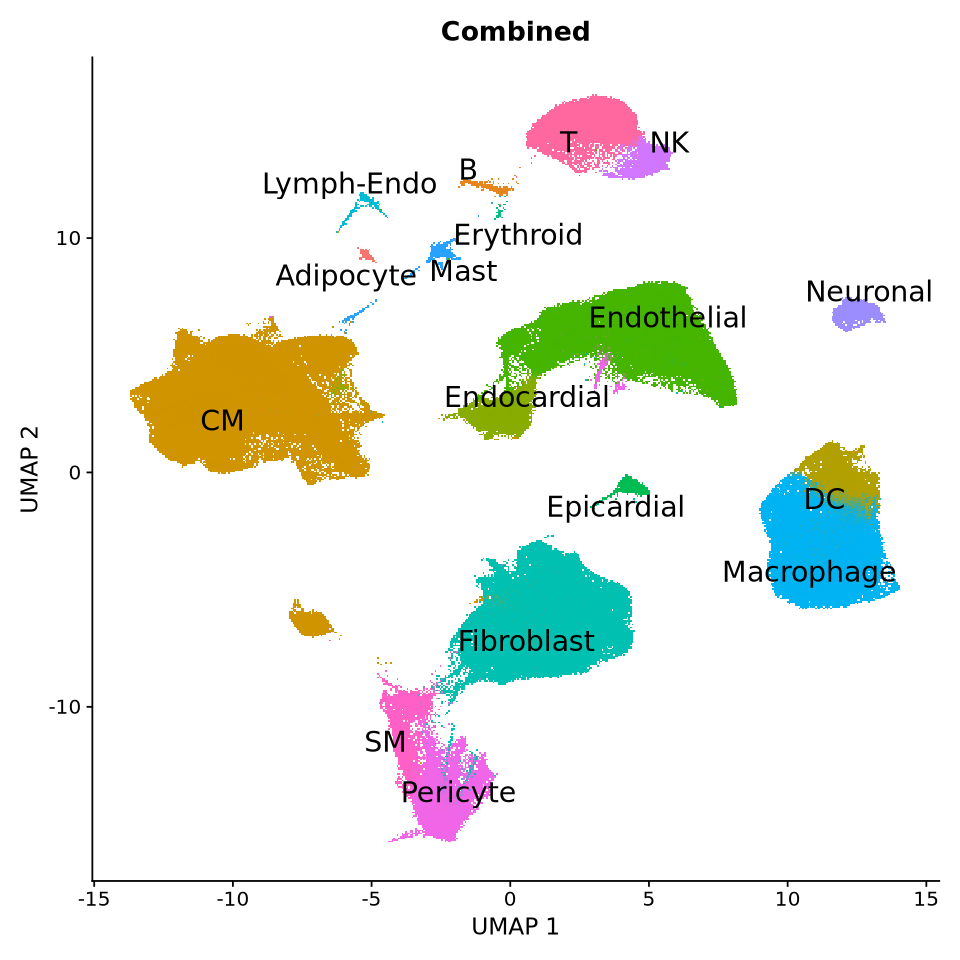

In [196]:
# Visualize clusters
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, group.by = "cell.major_types", reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



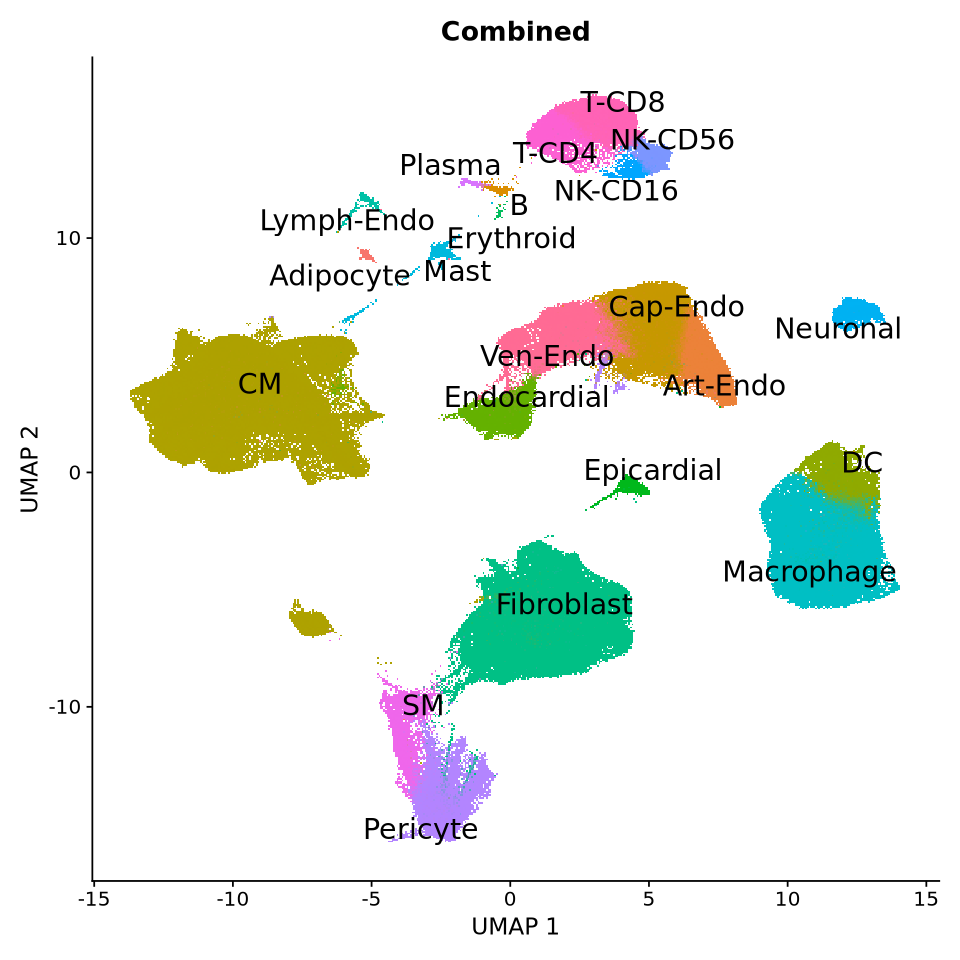

In [197]:
# Visualize clusters
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, group.by = "cell.sub_types", reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



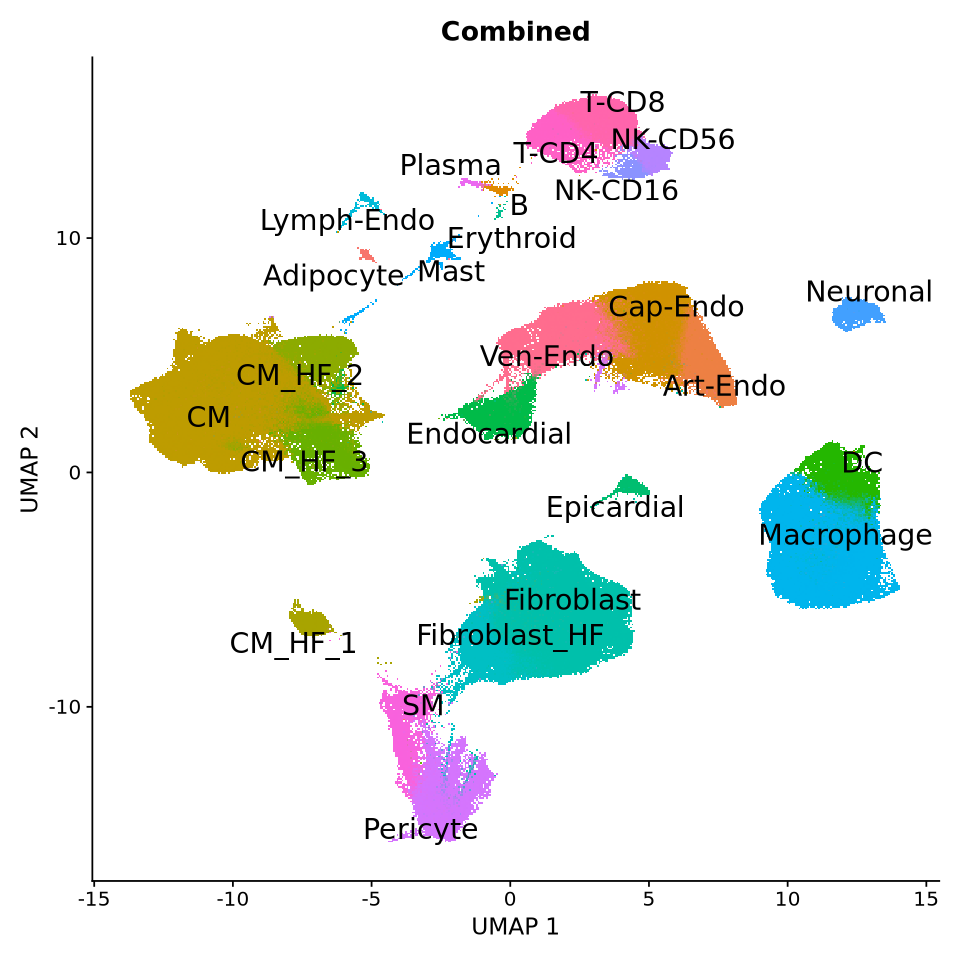

In [198]:
# Visualize clusters
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, group.by = "cell.sub_types_disease", reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

In [202]:
adata$celltypes = NULL
adata$major.celltypes = NULL
adata$donor_demux = NULL
adata$cell.sub_disease_types = NULL
adata$cell.subtypes = NULL
adata$sub.cluster = NULL
adata$cluster_celltype = NULL

In [203]:
unique(adata$disease_status_major)
unique(adata$disease_status_sub)
unique(adata$condition)

[1] "HF"     "NON_HF"

[1] "NICM_HF" "ICM_HF"  "NON_HF"

[1] "NICM_NDM" "ICM_NDM"  "CONTROL"  "NICM_DM"  "ICM_DM "

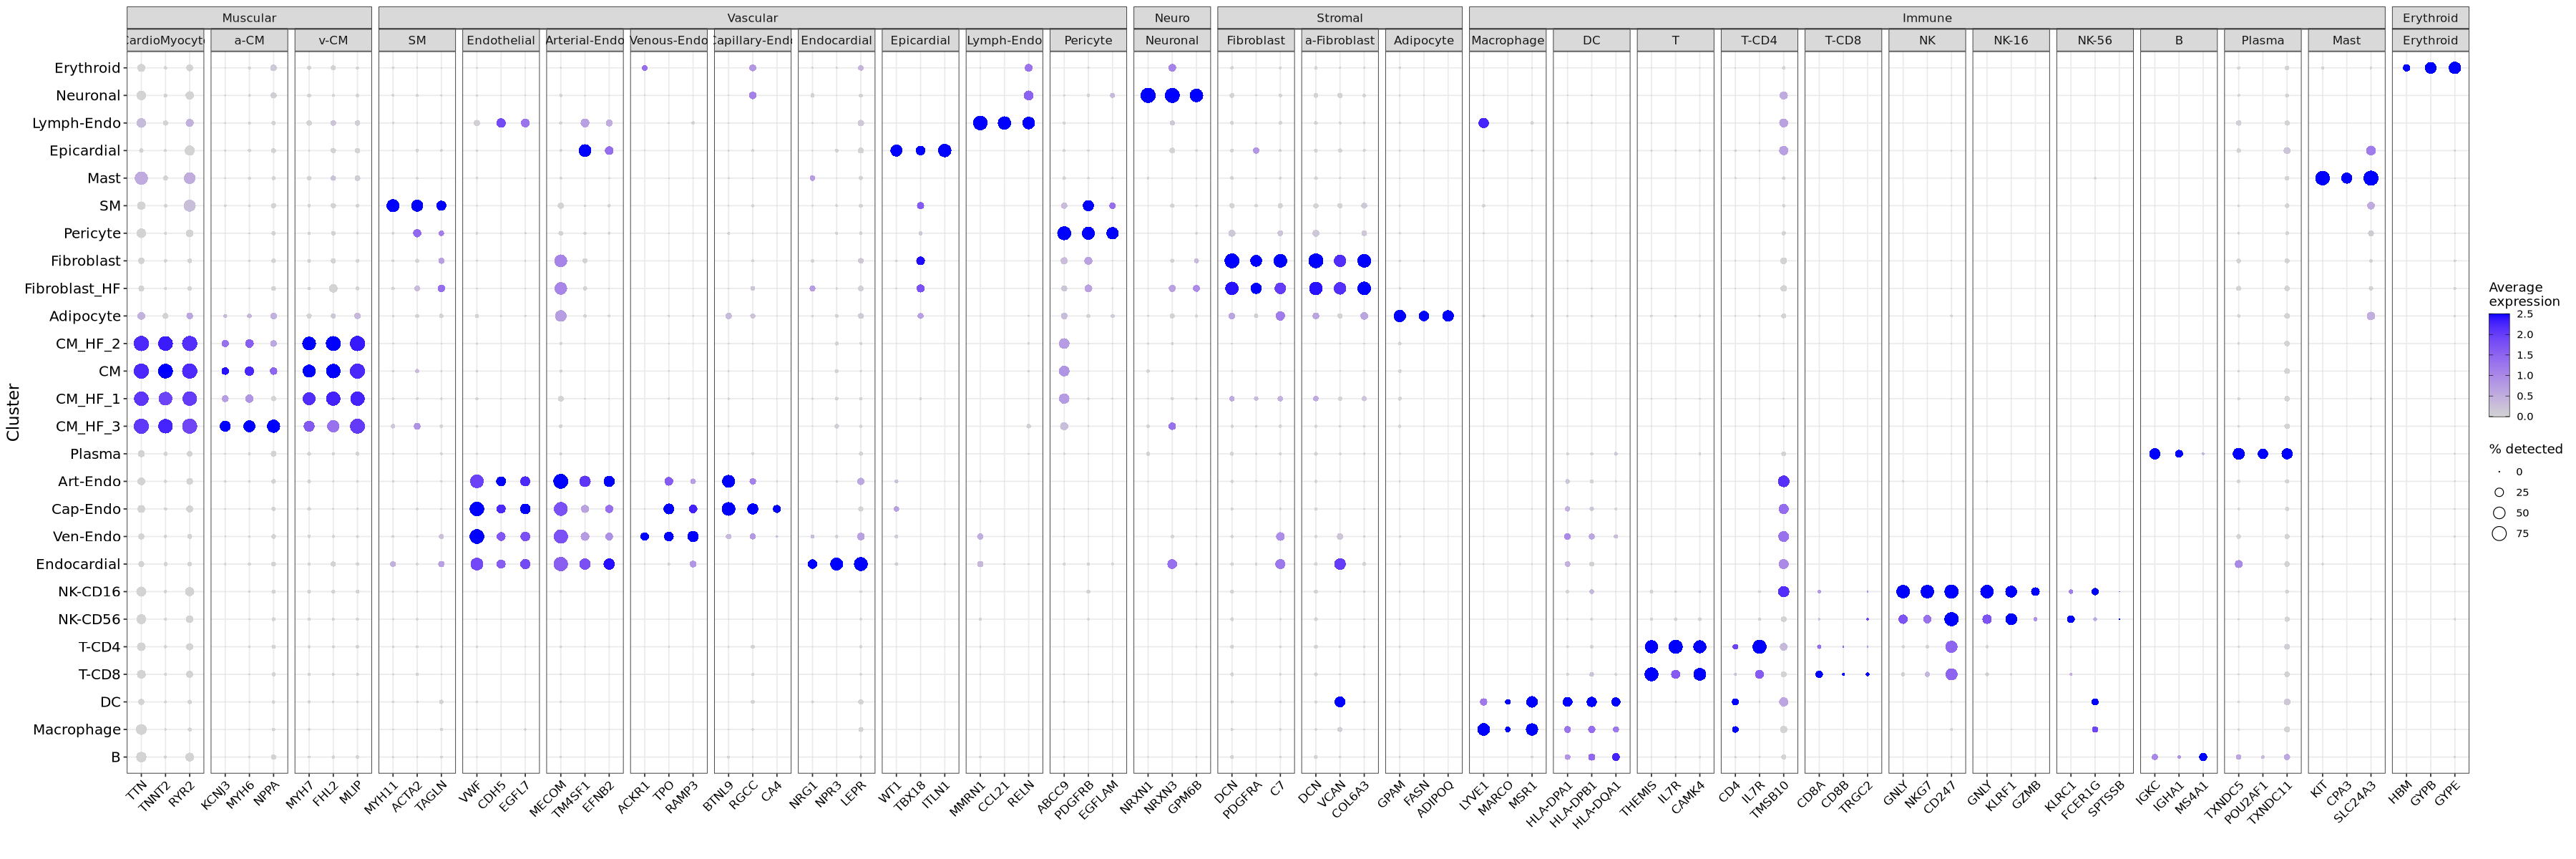

In [207]:
adata <- SetIdent(adata, value = adata$cell.sub_types_disease)
g = DotPlot(adata, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=30, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [208]:
# Plot dotplot for elie
adata.use = subset(adata, subset= cell.major_types == "CM")
adata.use <- SetIdent(adata.use, value = adata.use$cell.sub_types_disease)

gather: reorganized (Marker.1, Marker.2, Marker.3, Marker.4, Marker.5, …) into (Key, marker) [was 5x9, now 35x4]


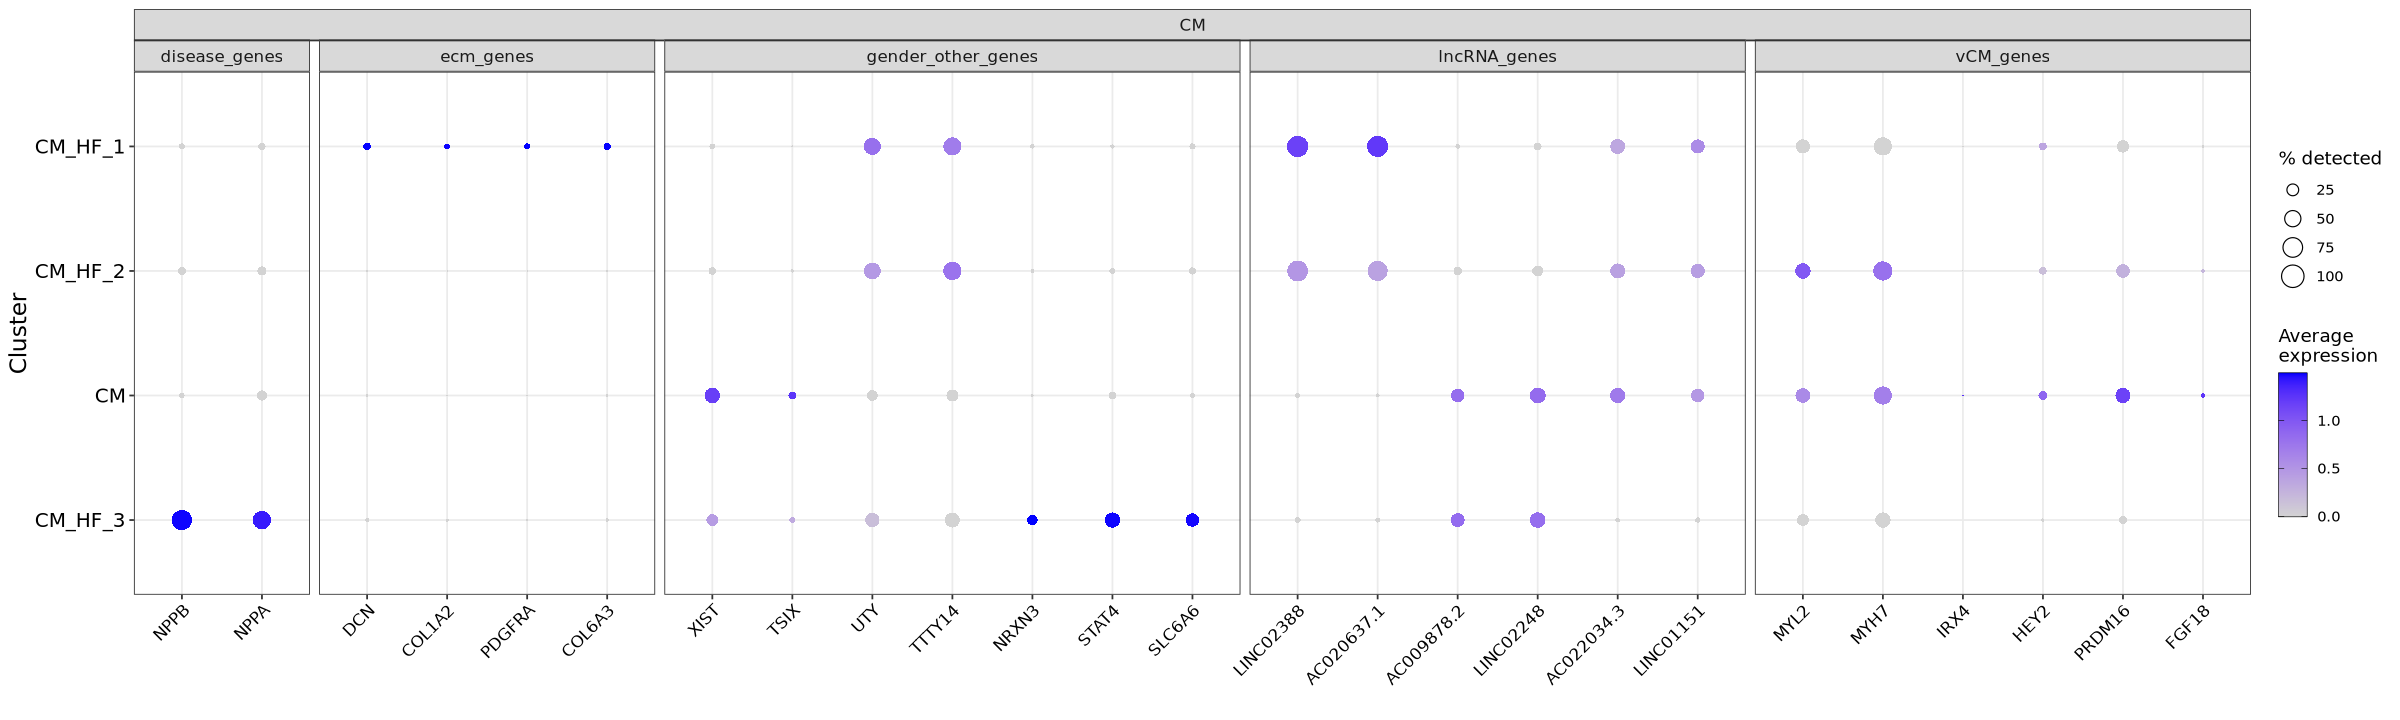

In [210]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "CM_Makers.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]

cell.compartment = cell.markers[,-3]

adata.use <- SetIdent(adata.use, value = adata.use$cell.sub_types_disease)
g = DotPlot(adata.use, assay='SCT', features=unique(cell.markers$marker), cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=20, repr.plot.height=6)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
figure

In [204]:
### Write  RDS
log_print("Saving RDS")
file = paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds", sep = "")
saveRDS(adata, file = file)
log_print("RDS - Saved")

[1] "Saving RDS"
[1] "RDS - Saved"


# Fix metadata

In [14]:
"Some cells had atac_fragments = NA"

[1] "Some cells had atac_fragments = NA"

In [15]:
adata = readRDS(paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds", sep = ""))

In [16]:
# Load sample info
sample.info = read.table(paste("/nfs/lab/projects/mega_heart/FNIH/multiome/Assets/", "sample.info", sep = ""), sep = "\t", header = TRUE)
# Build variables
sample.ls = sample.info$ID
seurat.obj.ls = paste0(sample.info$Seurat,
                       sample.info$ID, 
                       sample.info$rds)
cellranger.outs.ls = paste0(sample.info$CellRanger,
                            sample.info$Chamber, "/",
                            sample.info$ID, "/")

# Check the paths r right
sample.ls[1]
seurat.obj.ls[1]
cellranger.outs.ls[1]

[1] "QY_2193_1_2_QY_2192_1_2"

[1] "/nfs/lab/projects/fnih_heart_pool/LV/pipeline_output/QY_2193_1_2_QY_2192_1_2/rscript2outs/postSoupX_windows_postDemux_catlas_popscle.rds"

[1] "/nfs/lab/projects/mega_heart/FNIH/multiome/cellranger/LV/QY_2193_1_2_QY_2192_1_2/"

In [19]:
# add qc metrics from 10x
qcs <- list()
counter = 0
for (sample in sample.ls) {
    message("processing: ", sample)
    counter = counter + 1
    sample.dir <- paste0(cellranger.outs.ls[counter], "outs/")
    qc <- read.table(file.path(sample.dir, 'per_barcode_metrics.csv'), sep=',', header=TRUE, stringsAsFactors=1)
    qc$gex_barcode <- paste0(sample, '_', qc$gex_barcode)
    qcs[[sample]] <- qc
}

processing: QY_2193_1_2_QY_2192_1_2

processing: QY_2195_1_2_QY_2194_1_2

processing: QY_2197_1_2_QY_2196_1_2

processing: QY_2199_1_2_QY_2198_1_2

processing: QY_2201_1_2_QY_2200_1_2

processing: QY_2203_1_2_QY_2202_1_2

processing: QY_2205_1_2_QY_2204_1_2

processing: QY_2207_1_2_QY_2206_1_2

processing: QY_2254_1_2_QY_2253_1_2

processing: QY_2256_2_QY_2255_2

processing: QY_2258_2_QY_2257_2

processing: QY_2260_1_2_QY_2259_1_2

processing: QY_2262_2_QY_2261_2

processing: QY_2264_1_2_QY_2263_1_2

processing: QY_2266_2_QY_2265_2

processing: QY_2268_1_2_QY_2267_1_2

processing: QY_2336_2_QY_2335_2

processing: QY_2338_2_QY_2337_2

processing: QY_2340_2_QY_2339_2

processing: QY_2342_2_QY_2341_2

processing: QY_2344_2_QY_2343_2

processing: QY_2346_1_2_QY_2345_1_2

processing: QY_2348_1_2_QY_2347_1_2

processing: QY_2350_2_QY_2349_2

processing: QY_2364_2_QY_2363_2

processing: QY_2366_1_2_QY_2365_1_2

processing: QY_2368_2_QY_2367_2

processing: QY_2370_2_QY_2369_2

processing: QY_2

In [24]:
qc <- as.data.frame(rbindlist(qcs))
rownames(qc) = qc$gex_barcode
qc %>%
    dplyr::filter(gex_barcode %in% Cells(adata)) %>%
    dplyr::select(6:length(colnames(qc)))

gex_raw_reads gex_mapped_reads
QY_2193_1_2_QY_2192_1_2_AAACAGCCAACTAGGG-1  5705          5485           
QY_2193_1_2_QY_2192_1_2_AAACAGCCACTTACAG-1 12748         12206           
QY_2193_1_2_QY_2192_1_2_AAACAGCCAGTTTGTG-1 76755         74238           
QY_2193_1_2_QY_2192_1_2_AAACAGCCATCCGTAA-1 13548         13038           
QY_2193_1_2_QY_2192_1_2_AAACAGCCATGCATAT-1 43422         41868           
QY_2193_1_2_QY_2192_1_2_AAACATGCAGGCCTTG-1 14408         13918           
QY_2193_1_2_QY_2192_1_2_AAACATGCAGGCTTCG-1  6171          5925           
QY_2193_1_2_QY_2192_1_2_AAACATGCATTGTGAT-1 10602         10269           
QY_2193_1_2_QY_2192_1_2_AAACCAACAATAACCT-1  7034          6704           
QY_2193_1_2_QY_2192_1_2_AAACCAACACCAACCG-1 82290         79307           
QY_2193_1_2_QY_2192_1_2_AAACCAACACCTCAGG-1  3825          3665           
QY_2193_1_2_QY_2192_1_2_AAACCAACAGCACGAA-1 35468         33867           
QY_2193_1_2_QY_2192_1_2_AAACCAACAGGATAAC-1 52110         50269           
QY_2193_1_2_QY_2192_1_2_AAACCAACAGGTTACC-1  6885          6645           
QY_2193_1_2_QY_2192_1_2_AAACCAACATCATGGC-1 40004         38718           
QY_2193_1_2_QY_2192_1_2_AAACCAACATGCATAT-1 80531         77665           
QY_2193_1_2_QY_2192_1_2_AAACCAACATTGCAGC-1  9873          9529           
QY_2193_1_2_QY_2192_1_2_AAACCAACATTGTGTG-1 10476         10094           
QY_2193_1_2_QY_2192_1_2_AAACCGAAGCATTATG-1 39438         38039           
QY_2193_1_2_QY_2192_1_2_AAACCGAAGCTGCACA-1 44233         42624           
QY_2193_1_2_QY_2192_1_2_AAACCGAAGGAGCAAC-1 10173          9770           
QY_2193_1_2_QY_2192_1_2_AAACCGAAGTCACTAA-1  5942          5685           
QY_2193_1_2_QY_2192_1_2_AAACCGAAGTGGCGGA-1 31545         30526           
QY_2193_1_2_QY_2192_1_2_AAACCGCGTACAAAGA-1 34503         33289           
QY_2193_1_2_QY_2192_1_2_AAACCGCGTCCCGGAA-1 64247         62275           
QY_2193_1_2_QY_2192_1_2_AAACCGCGTGAAGCCT-1 26436         25506           
QY_2193_1_2_QY_2192_1_2_AAACCGCGTGATCAGC-1 51433         49698           
QY_2193_1_2_QY_2192_1_2_AAACCGCGTGCTGTAA-1 33885         32653           
QY_2193_1_2_QY_2192_1_2_AAACCGCGTGGTTAGC-1  8586          8206           
QY_2193_1_2_QY_2192_1_2_AAACCGCGTTGCGCGA-1 16308         15744           
⋮                                          ⋮             ⋮               
QY_2378_2_QY_2377_2_TTTGGTGCATGGCCCA-1      17354         16852          
QY_2378_2_QY_2377_2_TTTGTCCCAACAGCCT-1      39838         38575          
QY_2378_2_QY_2377_2_TTTGTCCCAATGAAGC-1      26583         25623          
QY_2378_2_QY_2377_2_TTTGTCCCATAGCTTG-1      10650         10277          
QY_2378_2_QY_2377_2_TTTGTCCCATTGTCCT-1      56277         54711          
QY_2378_2_QY_2377_2_TTTGTCTAGAATCTCA-1      17654         17093          
QY_2378_2_QY_2377_2_TTTGTCTAGGTGAAGC-1      32390         31357          
QY_2378_2_QY_2377_2_TTTGTCTAGGTTACAC-1      57564         55766          
QY_2378_2_QY_2377_2_TTTGTGAAGAGAGCCG-1      17302         16779          
QY_2378_2_QY_2377_2_TTTGTGAAGAGAGGCT-1      11281         10803          
QY_2378_2_QY_2377_2_TTTGTGAAGCCTAATA-1     110348        106826          
QY_2378_2_QY_2377_2_TTTGTGAAGCTCAAAC-1     105195        101137          
QY_2378_2_QY_2377_2_TTTGTGAAGGATTTGC-1      24685         23504          
QY_2378_2_QY_2377_2_TTTGTGAAGTTTGTCT-1      21177         20502          
QY_2378_2_QY_2377_2_TTTGTGGCAAAGGTAC-1      18504         17854          
QY_2378_2_QY_2377_2_TTTGTGGCACACAATT-1      30972         30019          
QY_2378_2_QY_2377_2_TTTGTGGCACACCAAC-1      36887         35787          
QY_2378_2_QY_2377_2_TTTGTGGCACGAACAG-1       9354          8934          
QY_2378_2_QY_2377_2_TTTGTGTTCACCAATA-1     178309        172009          
QY_2378_2_QY_2377_2_TTTGTGTTCATCCTCA-1      23511         22839          
QY_2378_2_QY_2377_2_TTTGTGTTCCGTTATT-1      48103         46663          
QY_2378_2_QY_2377_2_TTTGTGTTCGGCTATG-1      31237         30336          
QY_2378_2_QY_2377_2_TTTGTGTTCGTGCCTT-1      241

In [25]:
adata

An object of class Seurat 
528053 features across 337206 samples within 5 assays 
Active assay: SCT (33901 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 4 other assays present: RNA, RNA_raw, ATAC_windows, ATAC
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [26]:
adata <- AddMetaData(adata, qc)
qc <- qcs <- NULL
gc(reset = TRUE)

used        (Mb)    gc trigger  (Mb)     max used    (Mb)   
Ncells    15363380   820.5   110213184   5886.1    15363380   820.5
Vcells 13013804680 99287.5 24038958952 183402.8 13013804680 99287.5

In [27]:
mean(adata$atac_fragments)

[1] 16528.51

In [28]:
### Write  RDS
log_print("Saving RDS")
file = paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.rds", sep = "")
saveRDS(adata, file = file)
log_print("RDS - Saved")

[1] "Saving RDS"


Log is not open.



[1] "RDS - Saved"


Log is not open.

